In [2]:
%load_ext autoreload
%autoreload 2

## Set up environment
### Import libraries

In [172]:
import numpy as np
import pandas as pd
import random
import re
import scipy as sp
import seaborn as sns
import yaml
import shutil

from copy import deepcopy
from pathlib import Path
from collections import namedtuple, defaultdict
from typing import Literal

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import rcParams

from scipy.signal import find_peaks, argrelextrema

import sys
import os

# Get the path of the parent directory and add it to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)


from assistive_arm.utils.data_preprocessing import read_headers, smooth_dataframe
from assistive_arm.utils.emg_processing import filter_emg, interpolate_dataframe_to_length
from assistive_arm.utils.emg_plotting import plot_every_muscle, plot_muscle_emg
from assistive_arm.utils.optimum_length_utils import get_jacobian, get_rotation_matrix
from assistive_arm.utils.printing import print_dict_structure


np.set_printoptions(precision=3, suppress=True)

### Plotting settings

In [2]:
# Plot settings
plt.style.use('fivethirtyeight')

rcParams['font.size'] = 12

rcParams['figure.titlesize'] = 16
rcParams['figure.titleweight'] = 'normal'

rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 16
rcParams['axes.titleweight'] = 'normal'

rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16

rcParams['axes.grid'] = False
rcParams['grid.linewidth'] = 0.5

# make background white
rcParams['figure.facecolor'] = 'white'
rcParams['axes.facecolor'] = 'white'
rcParams['savefig.facecolor'] = 'white'

rcParams['lines.linewidth'] = 1.5
rcParams['lines.markersize'] = 10

# Box around plot
rcParams['axes.linewidth'] = 0.4
rcParams['axes.edgecolor'] = 'black'

# Add ticks
rcParams['xtick.major.size'] = 5
rcParams['ytick.major.size'] = 5

rcParams['legend.fontsize'] = 12
rcParams['legend.edgecolor'] = 'black'

In [4]:
# Add an extra color to the default cycle to avoid reusing colors
current_colors = rcParams['axes.prop_cycle'].by_key()['color']

# Add a new color
new_color = '#6a0dad'  # Example color, replace with the color you want to add
updated_colors = current_colors + [new_color]

# Set the updated color cycle
plt.rc('axes', prop_cycle=(plt.cycler('color', updated_colors)))

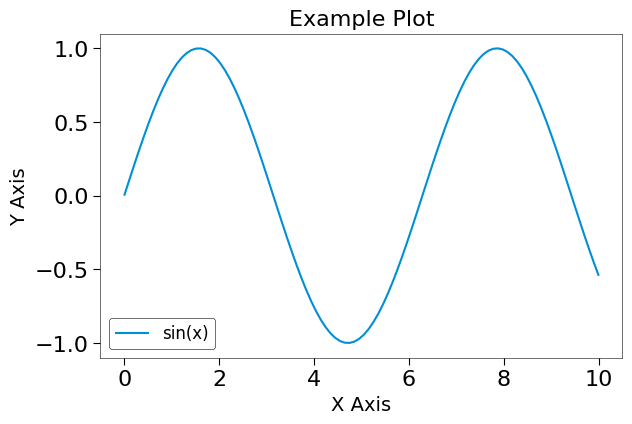

In [5]:
# Only for seeing what the plots look like
x = np.linspace(0, 10, 100)
y = np.sin(x)

plt.figure(figsize=(6, 4))
plt.plot(x, y, label='sin(x)')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Example Plot')
plt.legend()
plt.show()

## Data preparation

In [3]:
# Only to be used for EMG plots 
latex_figure_dir = Path("/Users/nathanirniger/Desktop/MA/Project/Written/Figures_plots/")

In [4]:
# Load simulation profile
profiles_dir = Path("../torque_profiles")

with open(profiles_dir / "simulation_profile.csv", "r") as file:
    sim_profile = pd.read_csv(file)

FileNotFoundError: [Errno 2] No such file or directory: '../torque_profiles/simulation_profile.csv'

### Load Data

In [119]:
target_splines = []

for file in sorted((profiles_dir).iterdir()):
    if 'Camille' in file.name:
        target_splines.append(pd.read_csv(file))

In [257]:
subject_dir = Path(f"../subject_logs/")
subjects = sorted([subject for subject in subject_dir.iterdir() if subject.is_dir()])

subject_data = {}

subject_dirs = {}

for subject in subjects:
    subject_name = subject.name
    subject_data[subject_name] = {}
    subject_dirs[subject_name] = {}

    for session in subject.iterdir():
        if session.is_dir():
            session_dir = session
            subject_data[subject_name][session.name] = {}
            subject_dirs[subject_name][session.name] = {}

            with open("../motor_config.yaml", "r") as f:
                motor_config = yaml.load(f, Loader=yaml.FullLoader)
            
            motor_dir = session_dir / "Motor"
            emg_dir = session_dir / "EMG"
            log_dir = session_dir / "Log"
            plot_dir = session_dir / "plots"
            plot_dir.mkdir(exist_ok=True)

            angle_calibration_path = motor_dir / "device_height_calibration.yaml"

            subject_dirs[subject_name][session.name]["emg_dir"] = emg_dir
            subject_dirs[subject_name][session.name]["plot_dir"] = plot_dir
            subject_dirs[subject_name][session.name]["motor_dir"] = motor_dir
            subject_dirs[subject_name][session.name]["log_dir"] = log_dir
            subject_dirs[subject_name][session.name]["angle_calibration_path"] = angle_calibration_path


            # Read EMG file to extract configuration
            # What/where are those files -> just to extract one header?
            emg_raw = emg_dir / "Raw" 

            # Get a random emg file containing the string "EMG" in the file name
            emg_file = next(emg_raw.glob("*EMG*.csv"))

            emg_config = dict()

            for i, header in enumerate(read_headers(emg_file, 1, delimiter="\t")):
                print(i, header)
                if i == 0:
                    emg_config["CHANNEL_NAMES"] = header
                    emg_config["FREQUENCY"] = float(2148.259)

            subject_data[subject_name][session.name]["emg_config"] = emg_config

0 ['EMG IMU,EMG RF_R,EMG VM_R,EMG BF_R,EMG G_R,EMG RF_L,EMG VM_L,EMG BF_L,EMG G_L,EMG SO_R,EMG TA_R']


In [258]:
mapping = {}
# The mapping converts the col name from the csv. output file to a muscle name
for channel in emg_config["CHANNEL_NAMES"][0].split(','):
    info = channel.split(" ")[1:2]

    # muscle = "".join([word[0] for word in muscle_part])
    # letters = re.findall(r'[a-zA-Z]', muscle)
    # if len(letters) == 1:
    #     muscle = letters[0]
    if info[0] == "IMU":
        mapping[channel] = "IMU"
        
    else:
        muscle, side = info[0].split("_")

        if side == "L":
            side_prefix = "LEFT"
        else:
            side_prefix = "RIGHT"

        mapping[channel] = "_".join([muscle, side_prefix])
mapping

{'EMG IMU': 'IMU',
 'EMG RF_R': 'RF_RIGHT',
 'EMG VM_R': 'VM_RIGHT',
 'EMG BF_R': 'BF_RIGHT',
 'EMG G_R': 'G_RIGHT',
 'EMG RF_L': 'RF_LEFT',
 'EMG VM_L': 'VM_LEFT',
 'EMG BF_L': 'BF_LEFT',
 'EMG G_L': 'G_LEFT',
 'EMG SO_R': 'SO_RIGHT',
 'EMG TA_R': 'TA_RIGHT'}

In [259]:
#  Write EMG-config yaml files
for subject in subject_data:
    for session in subject_data[subject]:

        session_dir = subject_dir / subject / session

        subject_data[subject][session]["emg_config"]["MAPPING"] = mapping

        if not (session_dir / "emg_config.yaml").exists():
            print("Writing EMG config...")
            with open(session_dir / "emg_config.yaml", "w") as f:
                yaml.dump(emg_config, f)
        else:
            print("EMG config already exists")
            # Open existing config
            with open(session_dir / "emg_config.yaml", "r") as f:
                emg_config = yaml.load(f, Loader=yaml.FullLoader)

        with open(subject_dirs[subject][session]["angle_calibration_path"] , 'r') as f:
            angle_calibration = yaml.load(f, Loader=yaml.FullLoader)

        subject_data[subject][session]["angle_calibration"] = angle_calibration

EMG config already exists


In [260]:
# LOAD MOTOR DATA

session_dict = {}
session_dict["MVIC"] = {}
session_dict["MVIC"]["LEFT"] = None
session_dict["MVIC"]["RIGHT"] = None

data_dict = {"EMG": [],
             "MOTOR_DATA": [],
             "IMU": [],
             "LOG": []
             }

session_dict["UNPOWERED"] = {}
session_dict["ASSISTED"] = {}
session_dict["UNPOWERED"]["BEFORE"] = deepcopy(data_dict)
session_dict["UNPOWERED"]["AFTER"] = deepcopy(data_dict)

# Load all session data
profile_to_num = {}
profile_infos = {}

# Skip first 0.5s to avoid initial noise
skip_first = 0.0 #s
remove_unpowered_after = False

# Counter for the number of profiles
# profile_counter = 0

# Handle all motor data
for subject in subjects:
    for session in subject.iterdir():
        if not session.is_dir():
            continue
        session_data = deepcopy(session_dict)
        motor_dir = subject_dirs[subject.name][session.name]["motor_dir"]
        for file_path in sorted(motor_dir.iterdir()):
            if file_path.suffix == ".csv":
                if "unassisted" in file_path.stem:
                    df = pd.read_csv(file_path, index_col="time").loc[skip_first:]
                    
                    match = re.search(r'unpowered_device_(\d+)', file_path.stem)
                    if match:
                        num = match.group(1)
                    if "before" in file_path.stem:
                        session_data["UNPOWERED"]["BEFORE"]["MOTOR_DATA"].append(df)
                        # if not isinstance(session_data["UNPOWERED"]["BEFORE"]["MOTOR_DATA"], dict):
                        #     session_data["UNPOWERED"]["BEFORE"]["MOTOR_DATA"] = {}
                        # session_data["UNPOWERED"]["BEFORE"]["MOTOR_DATA"][num] = df
                    else:
                        remove_unpowered_after = False
                        session_data["UNPOWERED"]["AFTER"]["MOTOR_DATA"].append(df)
                        # if not isinstance(session_data["UNPOWERED"]["AFTER"]["MOTOR_DATA"], dict):
                        #     session_data["UNPOWERED"]["AFTER"]["MOTOR_DATA"] = {}
                        # session_data["UNPOWERED"]["AFTER"]["MOTOR_DATA"][num] = df



                elif "scaled" or "no_counter" in file_path.stem:
                    df = pd.read_csv(file_path, index_col="time").loc[skip_first:]

                    match = re.search(r'scaled_(\d+)_([^_]+)_', file_path.stem)
                    if match:
                        num = match.group(1)

                    match = re.search(r'scaled_\d+_(.*)_\d+$', file_path.stem)
                    if match:
                        profile = match.group(1)

                    if profile not in session_data["ASSISTED"].keys():
                        session_data["ASSISTED"][profile] = deepcopy(data_dict)
                    #     session_data["ASSISTED"][profile]["MOTOR_DATA"] = {}
                    # session_data["ASSISTED"][profile]["MOTOR_DATA"][num] = df

                    session_data["ASSISTED"][profile]["MOTOR_DATA"].append(df)

        subject_data[subject.name][session.name]["session_data"] = session_data

In [261]:
# LOAD EMG DATA

sampling_freq =  emg_config["FREQUENCY"]  # Frequency in Hz
sampling_interval = 1 / sampling_freq  # Time interval between samples

IMU_sampling_freq = 518.519  # Frequency in Hz
IMU_sampling_interval = 1 / IMU_sampling_freq  # Time interval between samples


for subject in subjects:
    for session in subject.iterdir():
        if not session.is_dir():
            continue
        emg_dir = subject_dirs[subject.name][session.name]["emg_dir"]
        raw_dir = emg_dir / "Raw"

        session_data = subject_data[subject.name][session.name]["session_data"]
        emg_config = subject_data[subject.name][session.name]["emg_config"]
        
        relevant_cols = list(emg_config["MAPPING"].keys())
        
        # Handle second EMG data
        for file_path in sorted(raw_dir.iterdir()):
            if file_path.suffix == ".csv":
                if "EMG" in file_path.stem:
                    if "unassisted" in file_path.stem:
                        # n = int(file_path.stem.split("_")[1])
        
                        df = pd.read_csv(file_path, sep=",", usecols=relevant_cols, engine='python')                    
                        df.rename(columns=emg_config["MAPPING"], inplace=True)
                        df.sort_index(axis=1, inplace=True)

                        # Create the "TIME" column
                        num_samples = len(df)
                        time_column = pd.Series([i * sampling_interval for i in range(num_samples)], name="TIME")
                        # df.insert(0, "TIME", time_column)  # Insert at the first column
                        df.set_index(time_column, inplace=True)  # Set time as index

                        num = re.search(r'\d+$', file_path.stem).group()

                        # Add fake TA and SO data
                        df["TA_LEFT"] = df["TA_RIGHT"]
                        df["SO_LEFT"] = df["SO_RIGHT"]

                        if "before" in file_path.stem:
                            session_data["UNPOWERED"]["BEFORE"]["EMG"].append(df)
                            # if not isinstance(session_data["UNPOWERED"]["BEFORE"]["EMG"], dict):
                            #     session_data["UNPOWERED"]["BEFORE"]["EMG"] = {}
                            # session_data["UNPOWERED"]["BEFORE"]["EMG"][num] = df
                        else:
                            session_data["UNPOWERED"]["AFTER"]["EMG"].append(df)
                            # if not isinstance(session_data["UNPOWERED"]["AFTER"]["EMG"], dict):
                            #     session_data["UNPOWERED"]["AFTER"]["EMG"] = {}
                            # session_data["UNPOWERED"]["AFTER"]["EMG"][num] = df

                            
                    elif "MVIC" in file_path.stem:
                        df = pd.read_csv(file_path, sep=",", usecols=relevant_cols, engine='python')
                        df.rename(columns=emg_config["MAPPING"], inplace=True)
                        df.sort_index(axis=1, inplace=True)
                        
                        # Create the "TIME" column
                        num_samples = len(df)
                        time_column = pd.Series([i * sampling_interval for i in range(num_samples)], name="TIME")
                        df.set_index(time_column, inplace=True)  # Set time as index            

                        if "BF_L" in file_path.name:  # If it's the BF file
                            side = "LEFT"
                            bf_col = [col for col in df.columns if "BF_" + side in col]  # Adjust this if your naming convention is different
                            df = df[bf_col]
                        elif "RF_L" in file_path.name:
                            side = "LEFT"
                            rf_vm_cols = [col for col in df.columns if any(sub in col for sub in ["RF_" + side, "VM_" + side])]
                            df = df[rf_vm_cols]
                        elif "G_L" in file_path.name:
                            side = "LEFT"
                            g_col = [col for col in df.columns if "G_" + side in col]
                            df = df[g_col]

                        elif "BF_R" in file_path.name:  # If it's the BF file
                            side = "RIGHT"
                            bf_col = [col for col in df.columns if "BF_" + side in col]  # Adjust this if your naming convention is different
                            df = df[bf_col]
                        elif "RF_R" in file_path.name:
                            side = "RIGHT"
                            rf_vm_cols = [col for col in df.columns if any(sub in col for sub in ["RF_" + side, "VM_" + side])]
                            df = df[rf_vm_cols]
                        elif "G_R" in file_path.name:
                            side = "RIGHT"
                            g_col = [col for col in df.columns if "G_" + side in col]
                            df = df[g_col]

                        # Aditional muscles
                        elif "SO_R" in file_path.name:
                            side = "RIGHT"
                            so_col = [col for col in df.columns if "SO_" + side in col]
                            df = df[so_col]
                            # continue
                        elif "TA_R" in file_path.name:
                            side = "RIGHT"
                            ta_col = [col for col in df.columns if "TA_" + side in col]
                            df = df[ta_col]
                            # continue

                        if session_data["MVIC"][side] is not None:
                            # Merge with existing data
                            session_data["MVIC"][side] = pd.merge(session_data["MVIC"][side], df, left_index=True, right_index=True, how='outer')
                        else:
                            # Initialize with the new data
                            session_data["MVIC"][side] = df


                    else:
                        df = pd.read_csv(file_path, sep=",", usecols=relevant_cols, engine='python')
                        df.rename(columns=emg_config["MAPPING"], inplace=True)
                        df.sort_index(axis=1, inplace=True)
                        data_type = "EMG"
                        # print(file_path.stem)

                        # Create the "TIME" column
                        num_samples = len(df)
                        time_column = pd.Series([i * sampling_interval for i in range(num_samples)], name="TIME")
                        df.set_index(time_column, inplace=True)  # Set time as index

                        num = re.search(r'\d+$', file_path.stem).group()
                        match = re.search(r'Profile_(.*?)_Trial', file_path.stem)

                        if match:
                            profile = match.group(1)

                        # Add fake TA and SO data
                        df["TA_LEFT"] = df["TA_RIGHT"]
                        df["SO_LEFT"] = df["SO_RIGHT"]
                        
                        # if not isinstance(session_data["ASSISTED"][profile]["EMG"], dict):
                        #     session_data["ASSISTED"][profile]["EMG"] = {} 
                        # session_data["ASSISTED"][profile]["EMG"][num] = df

                        session_data["ASSISTED"][profile]["EMG"].append(df)
                
                if "ACC" in file_path.stem:
                    df_acc = pd.read_csv(file_path, delimiter=',', usecols=[0, 1, 2])
                    # Rename the columns based on the file format
                    df_acc.columns = ['ACC IMU X', 'ACC IMU Y', 'ACC IMU Z']
                    df_acc = df_acc.apply(pd.to_numeric, errors='coerce')
                    # Remove columns with nan values
                    df_acc = df_acc.dropna()

                    # Replace "ACC" with "GYRO" in the file name
                    file_path = file_path.with_name(file_path.name.replace("ACC", "GYRO"))

                    # Read the GYRO data
                    df_gyro = pd.read_csv(file_path, delimiter=',', usecols=[0, 1, 2])
                    # Rename the columns based on the file format
                    df_gyro.columns = ['GYRO IMU X', 'GYRO IMU Y', 'GYRO IMU Z']
                    # Remove columns with nan values
                    df_gyro = df_gyro.dropna()

                    # Merge the ACC and GYRO data
                    df = pd.concat([df_acc, df_gyro], axis=1) 

                    # Create the "TIME" column
                    num_samples = len(df)
                    time_column = pd.Series([i * IMU_sampling_interval for i in range(num_samples)], name="TIME")
                    df.set_index(time_column, inplace=True)

                    num = re.search(r'\d+$', file_path.stem).group()

                    if "unassisted" in file_path.stem:
                        if "before" in file_path.stem:
                            # if not isinstance(session_data["UNPOWERED"]["BEFORE"]["IMU"], dict):
                            #     session_data["UNPOWERED"]["BEFORE"]["IMU"] = {}
                            # session_data["UNPOWERED"]["BEFORE"]["IMU"][num] = df
                            session_data["UNPOWERED"]["BEFORE"]["IMU"].append(df)
                        else:
                            # if not isinstance(session_data["UNPOWERED"]["AFTER"]["IMU"], dict):
                            #     session_data["UNPOWERED"]["AFTER"]["IMU"] = {}
                            # session_data["UNPOWERED"]["AFTER"]["IMU"][num] = df
                            session_data["UNPOWERED"]["AFTER"]["IMU"].append(df)

                    elif "MVIC" in file_path.stem:
                        # Nothing
                        continue

                    else:
                        match = re.search(r'Profile_(.*?)_Trial', file_path.stem)
                        if match:
                            profile = match.group(1)
                        # if not isinstance(session_data["ASSISTED"][profile]["IMU"], dict):
                        #     session_data["ASSISTED"][profile]["IMU"] = {} 
                        # session_data["ASSISTED"][profile]["IMU"][num] = df
                        session_data["ASSISTED"][profile]["IMU"].append(df)

        subject_data[subject.name][session.name]["session_data"] = session_data

In [275]:
# LOAD LOG DATA

for subject in subjects:
    for session in subject.iterdir():
        if not session.is_dir():
            continue
        log_dir = subject_dirs[subject.name][session.name]["log_dir"]
        session_data = subject_data[subject.name][session.name]["session_data"]
        
        # Handle second EMG data
        for file_path in sorted(log_dir.iterdir()):
            if file_path.suffix == ".csv":
                # File size should be larger than 5 bytes to avoid empty files
                if os.stat(file_path).st_size > 5:
                    if "unassisted" in file_path.stem:
                        df = pd.read_csv(file_path)
                        print(df)
                        
                        if "before" in file_path.stem:
                            session_data["UNPOWERED"]["BEFORE"]["LOG"].append(df)
                        else:
                            remove_unpowered_after = False
                            session_data["UNPOWERED"]["AFTER"]["LOG"].append(df)

                    else:
                        print(df)
                        df = pd.read_csv(file_path)
                        match = re.search(r'Profile_(.*?)_Trial', file_path.stem)
                        if match:
                            profile = match.group(1)
                            session_data["ASSISTED"][profile]["LOG"].append(df)


        subject_data[subject.name][session.name]["session_data"] = session_data

   Segment Start Index  Segment End Index  Start Time  End Time  \
0                    0               3325        1862      2639   

   Unassisted Mean  Assisted Mean  
0         0.001264              0  
   Segment Start Index  Segment End Index  Start Time  End Time  \
0                    0               2954        1897      2626   

   Unassisted Mean  Assisted Mean  
0                0       0.001477  
   Segment Start Index  Segment End Index  Start Time  End Time  \
0                    0               3395        1717      2440   

   Unassisted Mean  Assisted Mean  
0                0       0.001376  
   Segment Start Index  Segment End Index  Start Time  End Time  \
0                    0               3598        2073      2761   

   Unassisted Mean  Assisted Mean  
0                0       0.001781  
   Segment Start Index  Segment End Index  Start Time  End Time  \
0                    0               3164        1690      2375   

   Unassisted Mean  Assisted Mean  
0

In [263]:
# Duplicate data for SO and TA to the other side
for subject in subjects:
    for session in subject.iterdir():
        if not session.is_dir():
            continue
        session_data = subject_data[subject.name][session.name]["session_data"]
        
        # MVIC
        fake_data = session_data["MVIC"]["RIGHT"].iloc[:, -2:].copy()
        # Rename the columns
        fake_data.columns = ["SO_LEFT", "TA_LEFT"]
        session_data["MVIC"]["LEFT"] = pd.merge(session_data["MVIC"]["LEFT"], fake_data, left_index=True, right_index=True, how='outer')

        # # Unpowered
        # fake_data = session_data["UNPOWERED"]["AFTER"]["EMG"][0].iloc[:, -2:].copy()
        # # Rename the columns
        # fake_data.columns = ["SO_LEFT", "TA_LEFT"]
        # session_data["UNPOWERED"]["AFTER"]["EMG"][0] = pd.merge(session_data["UNPOWERED"]["AFTER"]["EMG"][0], fake_data, left_index=True, right_index=True, how='outer')
        
        # fake_data = session_data["UNPOWERED"]["BEFORE"]["EMG"][0].iloc[:, -2:].copy()
        # # Rename the columns
        # fake_data.columns = ["SO_LEFT", "TA_LEFT"]
        # session_data["UNPOWERED"]["BEFORE"]["EMG"][0] = pd.merge(session_data["UNPOWERED"]["BEFORE"]["EMG"][0], fake_data, left_index=True, right_index=True, how='outer')

        # # Assisted
        # for profile in session_data["ASSISTED"].keys():
        #     fake_data = session_data["ASSISTED"][profile]["EMG"][0].iloc[:, -2:].copy()
        #     # Rename the columns
        #     fake_data.columns = ["SO_LEFT", "TA_LEFT"]
        #     session_data["ASSISTED"][profile]["EMG"][0] = pd.merge(session_data["ASSISTED"][profile]["EMG"][0], fake_data, left_index=True, right_index=True, how='outer')

In [273]:
# Print the whole structure
# print_dict_structure(subject_data)
# print(subject_data["subject_Nathan"]["October_31"].keys())
# print(subject_data["subject_Nathan"]["October_31"]["session_data"]["ASSISTED"])

### Drop unnecessary muscles

The idea here is that the recording from some EMG sensors can be noisy, hence we choose the one that shows consistent results with literature.

IMPORTANT: This can only be done after analyzing the data, so make sure to first look at MVIC and corresponding muscle activations

In [99]:
def get_unique_muscles(session_data):
    unique_muscles = [
        re.sub(pattern=r"(_LEFT|LEFT_|_RIGHT|RIGHT_)", repl="", string=col)  # Remove LEFT/RIGHT variations
        for col in session_data["MVIC"]["LEFT"].columns
    ]
    return unique_muscles

In [100]:
# Just to check if the function works

for subject in subjects:
    for session in subject.iterdir():
        if not session.is_dir():
            continue
        session_data = subject_data[subject.name][session.name]["session_data"]
        unique_muscles = get_unique_muscles(session_data)
        print(f"Subject: {subject.name}, Session: {session.name}, Unique Muscles: {unique_muscles}")

Subject: subject_Nathan, Session: October_31, Unique Muscles: ['BF', 'G', 'RF', 'VM', 'SO', 'TA']


## Filter EMG data

In [264]:
for subject in subjects:
    for session in subject.iterdir():
        if not session.is_dir():
            continue
        session_data = subject_data[subject.name][session.name]["session_data"]
        subject_data[subject.name][session.name]["filtered_session_data"] = deepcopy(session_data)
        
        filtered_session_data = subject_data[subject.name][session.name]["filtered_session_data"]

        session_data["MVIC"]["LEFT"] = session_data["MVIC"]["LEFT"].apply(pd.to_numeric, errors='coerce')
        session_data["MVIC"]["RIGHT"] = session_data["MVIC"]["RIGHT"].apply(pd.to_numeric, errors='coerce')
        filtered_session_data["MVIC"]["LEFT"], _ = filter_emg(session_data["MVIC"]["LEFT"], sfreq=emg_config["FREQUENCY"])
        filtered_session_data["MVIC"]["RIGHT"], _ = filter_emg(session_data["MVIC"]["RIGHT"], sfreq=emg_config["FREQUENCY"])

        for profile, emg_data in session_data["ASSISTED"].items():
            for i, emg_df in enumerate(session_data["ASSISTED"][profile]["EMG"]):
                emg_df = emg_df.apply(pd.to_numeric, errors='coerce')
                filtered_session_data["ASSISTED"][profile]["EMG"][i], _ = filter_emg(emg_df, sfreq=emg_config["FREQUENCY"])

        for unpow_key in session_data["UNPOWERED"].keys():
            for i, emg_df in enumerate(session_data["UNPOWERED"][unpow_key]["EMG"]):
                emg_df = emg_df.apply(pd.to_numeric, errors='coerce')
                filtered_session_data["UNPOWERED"][unpow_key]["EMG"][i], _ = filter_emg(emg_df, sfreq=emg_config["FREQUENCY"])

### Plot MVIC data

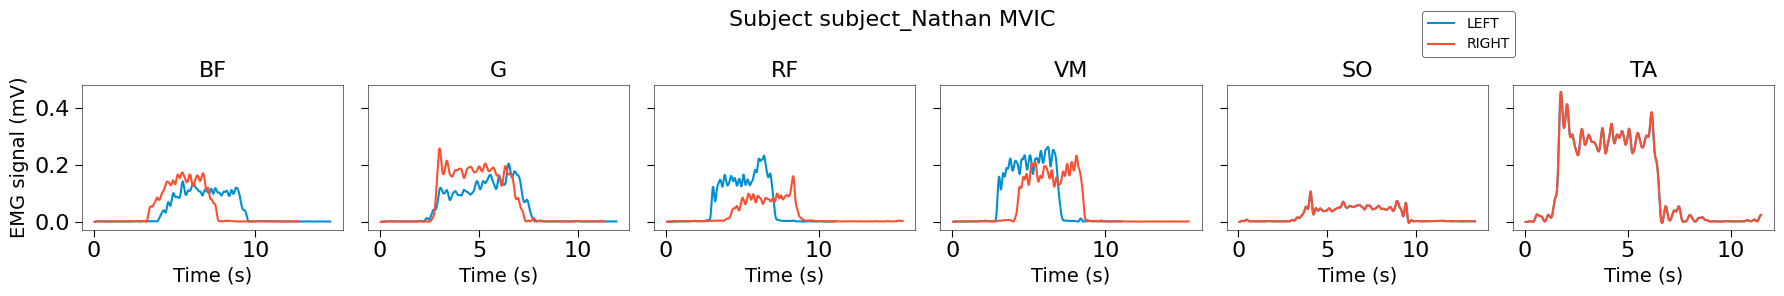

In [128]:
# Frequency of the data in Hz
sampling_freq =  emg_config["FREQUENCY"]  # Frequency in Hz
sampling_interval = 1 / sampling_freq  # Time interval between samples

for subject in subject_data.keys():
    for session in subject_data[subject].keys():    
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]

        n_cols = filtered_session_data["MVIC"]["LEFT"].shape[1]

        fig, axs = plt.subplots(1, n_cols, figsize=(3*n_cols, 3), sharey=True)
        fig.suptitle(f"Subject {subject} MVIC")

        for i, side in enumerate(filtered_session_data["MVIC"].keys()):
            for j, col in enumerate(filtered_session_data["MVIC"][side].columns):
                
                # Create a time array based on the sampling frequency
                num_samples = len(filtered_session_data["MVIC"][side].index)
                time_array = [k * sampling_interval for k in range(num_samples)]  # Time in seconds
                
                if n_cols == 1:
                    axs.plot(time_array, filtered_session_data["MVIC"][side][col], label=side)
                    axs.set_title(f"{col}")
                    axs.set_xlabel("Time (s)")
                    axs.set_ylabel("EMG signal (mV)")
                    handles, labels = axs.get_legend_handles_labels()
                else:
                    axs[j].plot(time_array, filtered_session_data["MVIC"][side][col], label=side)
                    axs[j].set_title(f"{col.split('_')[0]}")
                    axs[j].set_xlabel("Time (s)")
                    axs[0].set_ylabel("EMG signal (mV)")
                    handles, labels = axs[0].get_legend_handles_labels()

        fig.legend(handles, labels, loc='upper right', fontsize=10, bbox_to_anchor=(0.85, 1))

        plt.tight_layout()
        plt.savefig(subject_dirs[subject][session]['plot_dir'] / f"{subject}_MVIC.svg", dpi=500, bbox_inches='tight', format='svg')
        plt.savefig(latex_figure_dir / "emg_plots" / f"{subject}_MVIC.png", dpi=500, format="png")

### Plot UNFILTERED vs FILTERED EMG

### Plot every muscle activations across iterations and profiles

In [ ]:
def limit_range(df, lower_bound=-0.001, upper_bound=0.001):
    """Limit the values in the DataFrame to the given range, after ensuring all data is numeric."""
    df_numeric = df.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, non-numeric values become NaN
    df_limited = df_numeric.clip(lower=lower_bound, upper=upper_bound)  # Limit the range
    return df_limited

subject = "subject_Nathan"
session = "October_31"
plot_dir = subject_dirs[subject][session]["plot_dir"]
unscaled_emg_dir = plot_dir / "unscaled_emg"
unscaled_emg_dir.mkdir(exist_ok=True)

session_data = subject_data[subject][session]["session_data"]
filtered_session_data = subject_data[subject][session]["filtered_session_data"]

unique_muscles = get_unique_muscles(session_data)


for muscle in ["SO"]: # unique_muscles:
    for profile in session_data["ASSISTED"].keys():
        filename = unscaled_emg_dir / f"EMG_{muscle}_{profile}.svg"

        # Apply the range limiting function here before plotting
        unfiltered_dfs = [limit_range(df) for df in session_data["ASSISTED"][profile]["EMG"]]
        filtered_dfs = [limit_range(df) for df in filtered_session_data["ASSISTED"][profile]["EMG"]]

        plot_muscle_emg(title=f"{muscle} EMG data (unscaled)\n{profile}", 
                target_muscle=muscle,
                unfiltered_dfs=session_data["ASSISTED"][profile]["EMG"],
                filtered_dfs=filtered_session_data["ASSISTED"][profile]["EMG"], 
                freq=emg_config["FREQUENCY"],
                fig_path=filename,
                show=False)

#### Scale based on MVIC

In [171]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]
        left_mvic_cols = list(filtered_session_data["MVIC"]["LEFT"].columns)
        right_mvic_cols = list(filtered_session_data["MVIC"]["RIGHT"].columns)

        max_left = list(filtered_session_data["MVIC"]["LEFT"].max())
        max_right = list(filtered_session_data["MVIC"]["RIGHT"].max())

        # Create dataframe containing the max values for each muscle, should be 1 row
        mvic_df = pd.DataFrame(data=[max_left + max_right], columns=left_mvic_cols + right_mvic_cols)
        # mvic_df = mvic_df[filtered_session_data["UNPOWERED"]["BEFORE"]["EMG"][0].columns]
        mvic_df = mvic_df[['BF_LEFT', 'BF_RIGHT', 'G_LEFT', 'G_RIGHT', 'RF_LEFT', 'RF_RIGHT', 'VM_LEFT', 'VM_RIGHT', 'SO_LEFT', 'SO_RIGHT', 'TA_LEFT', 'TA_RIGHT']]
        
        for t_unpowered in filtered_session_data["UNPOWERED"].keys():
            for i, unpowered_df in enumerate(filtered_session_data["UNPOWERED"][t_unpowered]["EMG"]):
                unpowered_df /= mvic_df.iloc[0]

        for profile in filtered_session_data["ASSISTED"].keys():
            for i, filtered_emg in enumerate(filtered_session_data["ASSISTED"][profile]["EMG"]):
                filtered_emg /= mvic_df.iloc[0]

In [ ]:
subject = "subject_Nathan"
session = "October_31"

session_data = subject_data[subject][session]["session_data"]
filtered_session_data = subject_data[subject][session]["filtered_session_data"]

plot_dir = subject_dirs[subject][session]["plot_dir"]
scaled_emg_dir = plot_dir / "scaled_emg"
scaled_emg_dir.mkdir(exist_ok=True)

unique_muscles = get_unique_muscles(session_data)

print(unique_muscles)
for muscle in ["SO", "TA"]: #unique_muscles:
    for profile in session_data["ASSISTED"].keys():
        filename = scaled_emg_dir / f"EMG_{muscle}_{profile}.svg"

        plot_muscle_emg(title=f"{muscle} EMG data (scaled)\n{profile}", 
                target_muscle=muscle,
                unfiltered_dfs=session_data["ASSISTED"][profile]["EMG"],
                filtered_dfs=filtered_session_data["ASSISTED"][profile]["EMG"], 
                freq=emg_config["FREQUENCY"],
                fig_path=filename,
                show=False)

#### Scale EMG based on reported peak activation (based on papers)

### Plot UNFILTERED vs FILTERED EMG

In [ ]:
enable_paper_scaling = False

# Based on target muscles
muscle_values = {
    "RF": 1,#0.46,
    "BF":1,# 0.16,
    "VM": 0.9,
    "G": 1
}

activation_scaling_factor = {
    "RF_RIGHT": 1,
    "RF_LEFT": 1,
    "BF_RIGHT": 1,
    "BF_LEFT": 1,
    "VM_RIGHT": 1,
    "VM_LEFT": 1,
    "G_RIGHT": 1,
    "G_LEFT": 1
}

subject = "Nathan"
session = "Septmeber_26"

filtered_session_data = subject_data[subject][session]["filtered_session_data"]

if enable_paper_scaling:
    for emg_data in filtered_session_data["UNPOWERED"]["BEFORE"]["EMG"]:
        for muscle in emg_data.columns:
            # if "RF" in muscle:
            #     activation_scaling_factor[muscle] = emg_data[muscle].max() / muscle_values["RF"]
            #     emg_data[muscle] /= activation_scaling_factor[muscle] 
            # elif "BF" in muscle:
            #     activation_scaling_factor[muscle] = emg_data[muscle].max() / muscle_values["BF"]
            #     emg_data[muscle] /= activation_scaling_factor[muscle] 
            if "VM" in muscle:
                activation_scaling_factor[muscle] = emg_data[muscle].max() / muscle_values["VM"]
                emg_data[muscle] /= activation_scaling_factor[muscle] 

    for profile in filtered_session_data["ASSISTED"].keys():
        for emg_data in filtered_session_data["ASSISTED"][profile]["EMG"]:
            for muscle in emg_data.columns:
                emg_data[muscle] /= activation_scaling_factor[muscle]

## Process MOTOR data

In [ ]:
subject = "subject_Nathan"
session = "October_31"
# profile = "Camille_no_counter"

for profile in subject_data[subject][session]["filtered_session_data"]["ASSISTED"].keys():
    motor_log = subject_data[subject][session]["filtered_session_data"]["ASSISTED"][profile]["MOTOR_DATA"][0]

    colors = iter(rcParams['axes.prop_cycle'].by_key()['color'])

    plot_dir = subject_dirs[subject][session]["plot_dir"] / "motor_plots"
    plot_dir.mkdir(exist_ok=True)
    filename = plot_dir / f"motor_unfiltered_{profile}.svg"

    fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 5))
    fig.suptitle(profile)

    ax[0].plot(motor_log.index, motor_log["theta_2"], label=r"$\theta_2$", color=colors.__next__())
    # ax[0].axhline(y=angle_calibration["new_range"]["min"], linestyle="--", color="black")
    # ax[0].axhline(y=angle_calibration["new_range"]["max"], linestyle="--", color="black")
    handles0, labels0 = ax[0].get_legend_handles_labels()
    ax[0].set_ylabel(r"$\theta_2$ (rad)")


    ax[1].plot(motor_log.index, motor_log["target_tau_1"], label=r"Target $\tau_1$", color=colors.__next__())
    ax[1].plot(motor_log.index, motor_log["measured_tau_1"], label=r"Measured $\tau_1$", color=colors.__next__())
    ax[1].plot(motor_log.index, motor_log["target_tau_2"], label=r"Target $\tau_2$", color=colors.__next__())
    ax[1].plot(motor_log.index, motor_log["measured_tau_2"], label=r"Measured $\tau_2$", color=colors.__next__())
    handles1, labels1 = ax[1].get_legend_handles_labels()
    ax[1].set_ylabel("Torques (Nm)", fontsize=12)

    ax[2].plot(motor_log.index, motor_log["Percentage"], label="STS %", color=colors.__next__())
    ax[2].axhline(y=100, linestyle="--", color="black")
    ax[2].axhline(y=0, linestyle="--", color="black")
    handles2, labels2 = ax[2].get_legend_handles_labels()
    ax[2].set_ylabel("STS %")
    ax[2].set_xlabel('time(s)')

    handles = handles0 + handles1 + handles2
    labels = labels0 + labels1 + labels2
    fig.legend(handles, labels, loc='upper center', ncols=6, bbox_to_anchor=(0.5, 0.93), fontsize=10)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(filename, dpi=500, format='svg')
    plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
    plt.show()

### Fix wrap-around from motor measurements

In [145]:
# Control variable to toggle the sign
torque_limits = [motor_config[motor]["T_max"] for motor in motor_config.keys()]

for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]

        for profile in filtered_session_data["ASSISTED"].keys():
            motor_data = filtered_session_data["ASSISTED"][profile]["MOTOR_DATA"]

            measured_torques = [column for column in motor_data[0].columns if "measured_tau" in column]

            for motor_df in motor_data:
                for torque, jump_threshold in zip(measured_torques, torque_limits):
                    differences = motor_df[torque].diff().fillna(0)

                    # Threshold for detecting a jump
                    toggle_sign = 1

                    corrected_values = []

                    for diff in differences:
                        if abs(diff) > jump_threshold:
                            toggle_sign *= -1
                        corrected_values.append(toggle_sign)
                    motor_df[torque] *= corrected_values

In [ ]:
subject = "subject_Nathan"
session = "October_31"
# profile = "peak_77%_62N"

for profile in subject_data[subject][session]["filtered_session_data"]["ASSISTED"].keys():
    motor_log = subject_data[subject][session]["filtered_session_data"]["ASSISTED"][profile]["MOTOR_DATA"][0]

    colors = iter(rcParams['axes.prop_cycle'].by_key()['color'])

    plot_dir = subject_dirs[subject][session]["plot_dir"] / "motor_plots"
    filename = plot_dir / f"motor_filtered_{profile}.svg"


    fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 5))
    fig.suptitle(profile)

    ax[0].plot(motor_log.index, motor_log["theta_2"], label=r"$\theta_2$", color=colors.__next__())
    handles0, labels0 = ax[0].get_legend_handles_labels()
    ax[0].set_ylabel(r"$\theta_2$ (rad)")


    ax[1].plot(motor_log.index, motor_log["target_tau_1"], label=r"Target $\tau_1$", color=colors.__next__())
    ax[1].plot(motor_log.index, motor_log["measured_tau_1"], label=r"Measured $\tau_1$", color=colors.__next__())
    ax[1].plot(motor_log.index, motor_log["target_tau_2"], label=r"Target $\tau_2$", color=colors.__next__())
    ax[1].plot(motor_log.index, motor_log["measured_tau_2"], label=r"Measured $\tau_2$", color=colors.__next__())
    handles1, labels1 = ax[1].get_legend_handles_labels()
    ax[1].set_ylabel("Torques (Nm)", fontsize=12)

    ax[2].plot(motor_log.index, motor_log["Percentage"], label="STS %", color=colors.__next__())
    ax[2].axhline(y=100, linestyle="--", color="black")
    ax[2].axhline(y=0, linestyle="--", color="black")
    handles2, labels2 = ax[2].get_legend_handles_labels()
    ax[2].set_ylabel("STS %")
    ax[2].set_xlabel('time(s)')

    handles = handles0 + handles1 + handles2
    labels = labels0 + labels1 + labels2
    fig.legend(handles, labels, loc='upper center', ncols=6, bbox_to_anchor=(0.5, 0.93), fontsize=10)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(filename, dpi=500, format='svg')
    plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
    plt.show()

### Calculate force from torques

In [314]:
rotate_90 = get_rotation_matrix(90)

for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]
                
        for profile in filtered_session_data["ASSISTED"].keys():
            for motor_log in filtered_session_data["ASSISTED"][profile]["MOTOR_DATA"]:
                measured_torques = motor_log[["measured_tau_1", "measured_tau_2"]].to_numpy()
                measured_torques = measured_torques.reshape(*measured_torques.shape, 1)

                jacobians = get_jacobian(l1=0.44, l2=0.41, theta_1=motor_log["theta_1"].to_numpy(), theta_2=motor_log["theta_2"].to_numpy())
                F = - np.linalg.inv(jacobians.T) @ measured_torques
                # F = - rotate_90[:2, :2] @ np.linalg.inv(jacobians.T) @ measured_torques

                motor_log["F_X"] = F[:, 0]
                motor_log["F_Y"] = F[:, 1]
                

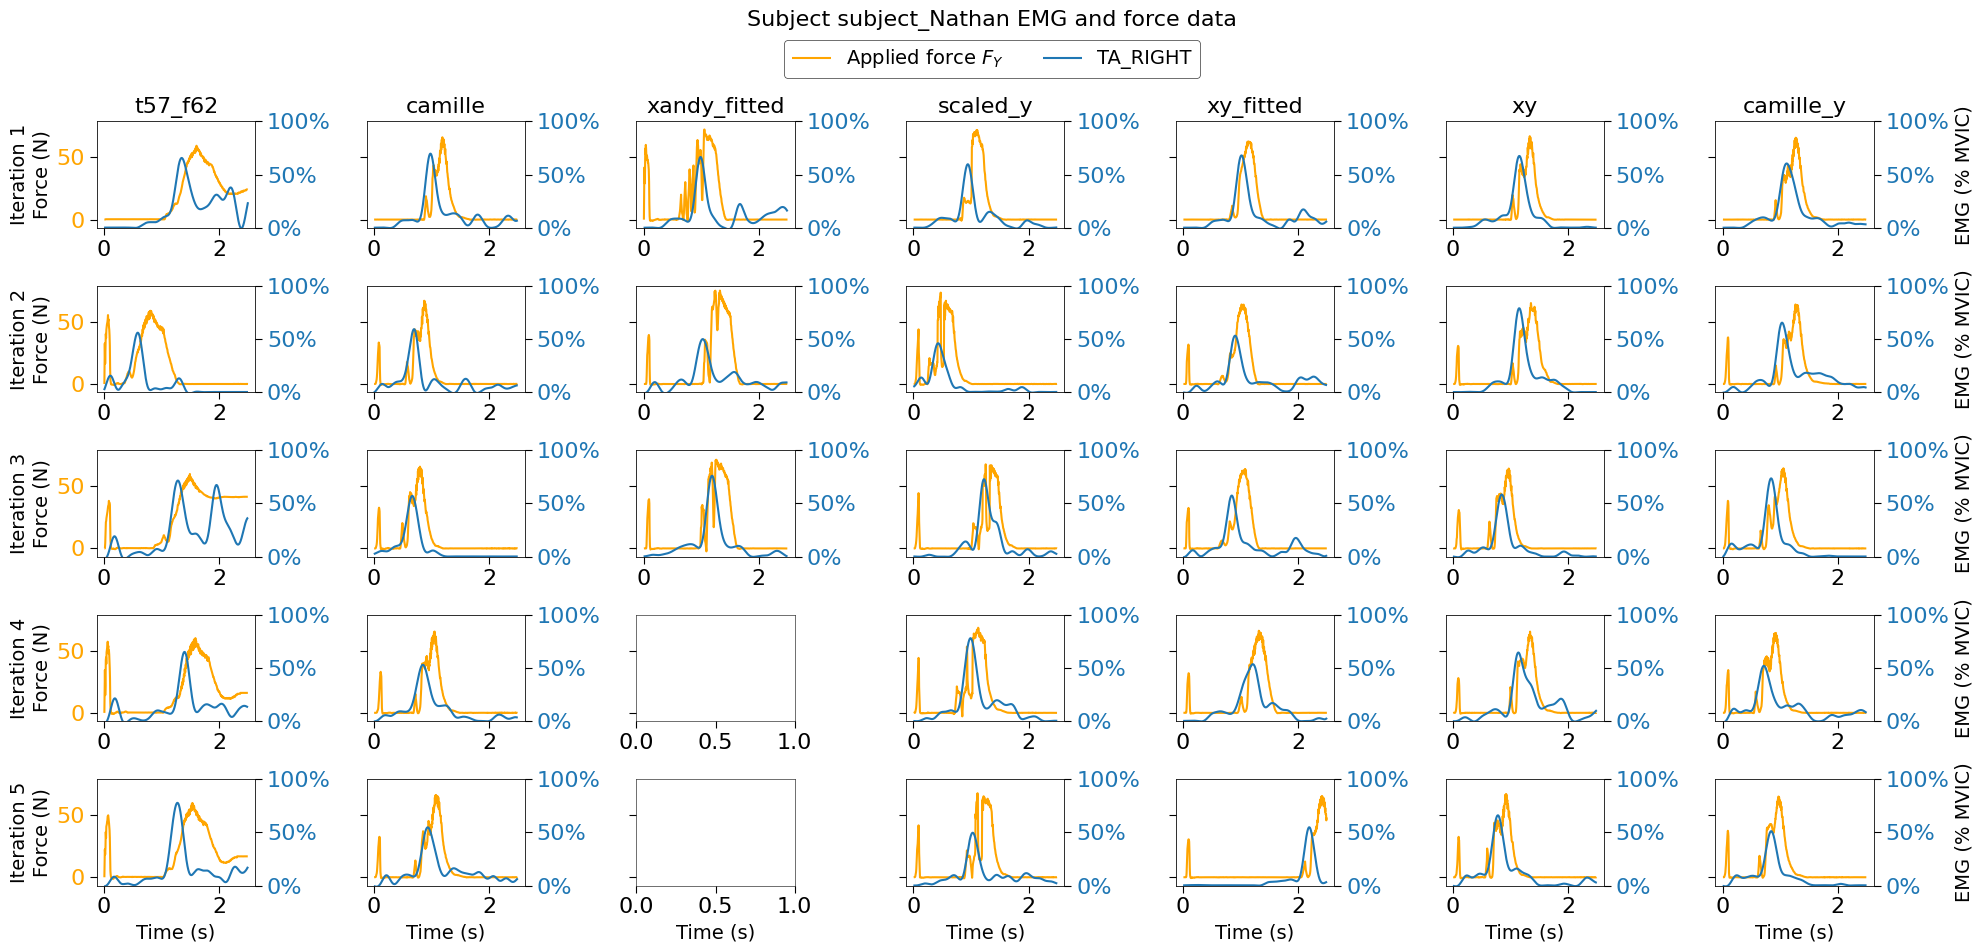

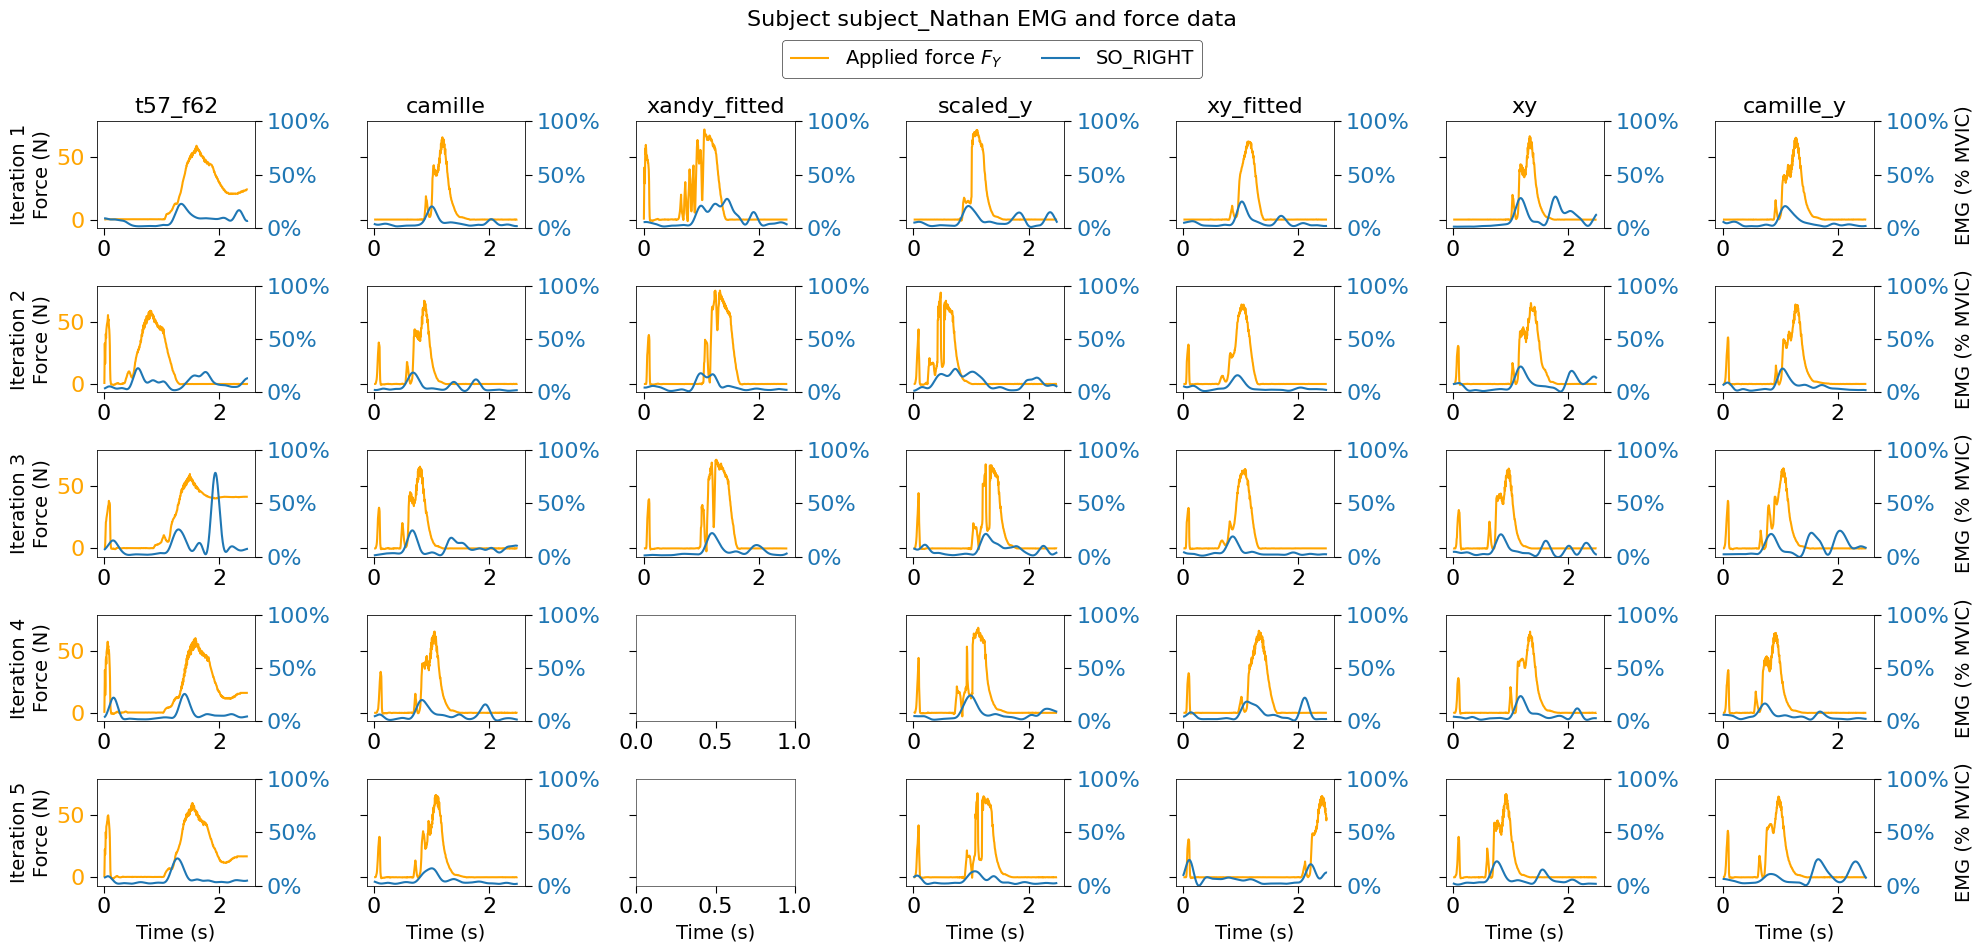

In [148]:
subject = "subject_Nathan"
session = "October_31"

# target_muscle = "BF_RIGHT"
# profile = "peak_77%_62N"

filtered_session_data = subject_data[subject][session]["filtered_session_data"]

plot_dir = subject_dirs[subject][session]["plot_dir"] / "force_muscle"
plot_dir.mkdir(exist_ok=True)
filename = plot_dir / f"overview_force_muscle.svg"

n_cols = len(filtered_session_data["ASSISTED"].keys())
n_rows = len(filtered_session_data["ASSISTED"][profile]["MOTOR_DATA"])

for target_muscle in ["TA_RIGHT", "SO_RIGHT"]: # ["BF_LEFT", "BF_RIGHT", "VM_LEFT", "VM_RIGHT", "G_LEFT", "G_RIGHT", "RF_LEFT", "RF_RIGHT", "TA_RIGHT", "SO_RIGHT"]:
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 10), sharey=True)
    fig.suptitle(f"Subject {subject} EMG and force data")   
    for i, profile in enumerate(filtered_session_data["ASSISTED"].keys()):
        words = profile.split('_')
        axs[0, i].set_title('_'.join(words[-2:]))
        for j, motor_df in enumerate(filtered_session_data["ASSISTED"][profile]["MOTOR_DATA"]):
            emg_data = filtered_session_data["ASSISTED"][profile]["EMG"][j]

            # Remove the first 3 seconds of EMG data
            emg_data = emg_data[emg_data.index >= 3]  # Keep data from 3 seconds onwards
            emg_data = emg_data[emg_data.index <= 5.5]  # Crop data after 2.5 seconds (3s to 5.5s)
            emg_data.index = emg_data.index - 3  # Reset index to start from 0

            # Remove everything after 2.5 Seconds in the motor data
            motor_df = motor_df[motor_df.index <= 2.5]  # Crop data after 2.5 seconds

            # Plot force values on the primary y-axis
            axs[j, i].plot(motor_df.index, motor_df.F_Y, label=r"Applied force $F_Y$", color='orange')
            axs[j, i].tick_params(axis='y', labelcolor='orange')

            # Create a secondary y-axis for EMG data
            ax2 = axs[j, i].twinx()
            ax2.plot(emg_data.index, emg_data[target_muscle], label=target_muscle, color=u'#1f77b4')
            ax2.set_ylim(0, 1)  # Set EMG activation scale from 0 to 1
            
            if i == len(filtered_session_data["ASSISTED"].keys()) - 1:
                ax2.set_ylabel('EMG (% MVIC)', color='black')
            ax2.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
            ax2.tick_params(axis='y', labelcolor=u'#1f77b4')

            axs[j, 0].set_ylabel(f"Iteration {j+1}\nForce (N)")
            axs[-1, i].set_xlabel("Time (s)")

            handles, labels = axs[j, i].get_legend_handles_labels()
            handles2, labels2 = ax2.get_legend_handles_labels()
            handles += handles2
            labels += labels2

    fig.legend(handles, labels, loc='upper center', ncols=2, bbox_to_anchor=(0.5, 0.96), fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # plt.savefig(filename, dpi=500, format='svg')
    plt.savefig(plot_dir / f"{target_muscle}_{filename.with_suffix('.png').name}", dpi=500, format="png")
    plt.show()

#### Overview of what motor data looks like

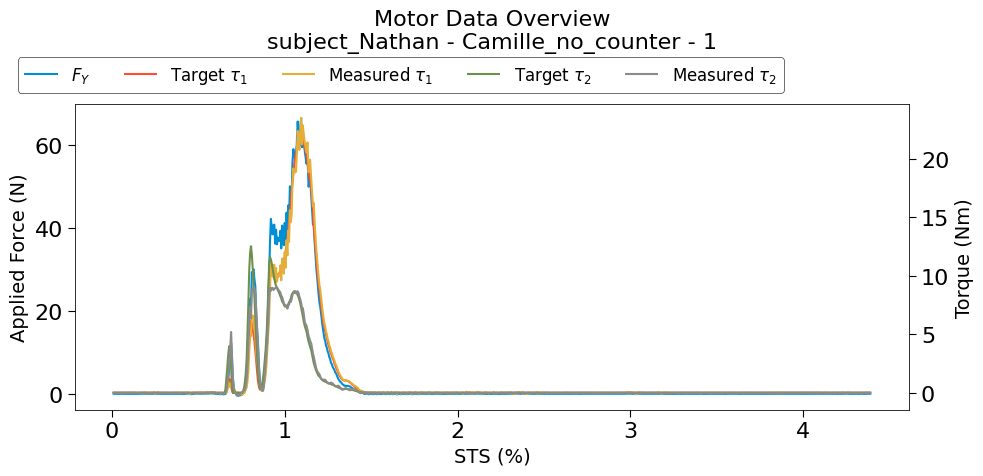

In [23]:
profile = "Camille_no_counter"
iteration = 1

motor_df = filtered_session_data["ASSISTED"][profile]["MOTOR_DATA"][iteration-1]

plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = plot_dir / f"motor_data_overview.svg"

colors = iter(rcParams['axes.prop_cycle'].by_key()['color'])

fig, ax = plt.subplots(1, figsize=(10, 5))
fig.suptitle(f"Motor Data Overview\n{subject} - {profile} - {iteration}")

ax.plot(motor_df.index, motor_df.F_Y, label=r"$F_Y$", color=colors.__next__())

ax2 = ax.twinx()
ax2.plot(motor_df.index, motor_df.target_tau_1, label=r"Target $\tau_1$", color=colors.__next__())
ax2.plot(motor_df.index, motor_df.measured_tau_1, label=r"Measured $\tau_1$", color=colors.__next__())
ax2.plot(motor_df.index, motor_df.target_tau_2, label=r"Target $\tau_2$", color=colors.__next__())
ax2.plot(motor_df.index, motor_df.measured_tau_2, label=r"Measured $\tau_2$", color=colors.__next__())
ax2.set_ylabel("Torque (Nm)")


ax.set_ylabel("Applied Force (N)")
ax.set_xlabel("STS (%)")

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

handles = handles1 + handles2
labels = labels1 + labels2

fig.legend(handles, labels, ncols=len(handles), bbox_to_anchor=[0.8, 0.9])
plt.savefig(filename, dpi=500, format='svg')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

### Calculate relevant time window based on percentage

In [149]:
time_range = namedtuple("TimeRange", ["min", "max"])

for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]              

        relevant_time_ranges = {}

        # ASSISTED
        for profile in filtered_session_data["ASSISTED"].keys():
            relevant_time_ranges[profile] = {"ranges": []}
            motor_data_dfs = filtered_session_data["ASSISTED"][profile]["MOTOR_DATA"]

            for j, motor_df in enumerate(motor_data_dfs):
                # Filter out data to look only for indices after 0.1 seconds
                motor_df_after_01s = motor_df[motor_df.index > 0.2]

                # Find the start index where the percentage exceeds 5
                start_index = motor_df_after_01s[motor_df_after_01s['Percentage'] > 10].index.min()
                if isinstance(start_index, float) and pd.isna(start_index):
                    start_index = motor_df_after_01s.index[0]  # Take the first index if start_index is NaN
                else:
                    start_index = start_index - 0.05 if start_index is not None else motor_df_after_01s.index[0]

                # Find the stop index where the percentage exceeds 95
                stop_index = motor_df_after_01s[motor_df_after_01s['Percentage'] > 85].index.min()
                if isinstance(stop_index, float) and pd.isna(stop_index):
                    stop_index = motor_df_after_01s.index[-1]  # Take the last index if stop_index is NaN
                else:
                    stop_index = stop_index + 0.15 if stop_index is not None else motor_df_after_01s.index[-1]

                # Store the relevant time ranges
                relevant_time_ranges[profile]["ranges"].append(time_range(start_index, stop_index))

        # UNPOWERED
        for unpowered_time in filtered_session_data["UNPOWERED"].keys():
            relevant_time_ranges[f"UNPOWERED_{unpowered_time}"] = {"ranges": []}
            motor_data_dfs = filtered_session_data["UNPOWERED"][unpowered_time]["MOTOR_DATA"]

            for j, motor_df in enumerate(motor_data_dfs):
                if unpowered_time == "BEFORE":
                    start_index = 0.6
                    stop_index = 1.5
                else:
                    # Filter out data to look only for indices after 0.1 seconds
                    motor_df_after_01s = motor_df[motor_df.index > 0.2]
                    
                    # print(motor_df_after_01s['Percentage'])
                    # Find the start index where the percentage exceeds 5
                    start_index = motor_df_after_01s[motor_df_after_01s['Percentage'] > 10].index.min()
                    if isinstance(start_index, float) and pd.isna(start_index):
                        start_index = motor_df_after_01s.index[0]  # Take the first index if start_index is NaN
                    else:
                        start_index = start_index - 0.05 if start_index is not None else motor_df_after_01s.index[0]

                    # Find the stop index where the percentage exceeds 95
                    stop_index = motor_df_after_01s[motor_df_after_01s['Percentage'] > 85].index.min()
                    if isinstance(stop_index, float) and pd.isna(stop_index):
                        stop_index = motor_df_after_01s.index[-1]  # Take the last index if stop_index is NaN
                    else:
                        stop_index = stop_index + 0.15 if stop_index is not None else motor_df_after_01s.index[-1]


                # Store the relevant time ranges
                relevant_time_ranges[f"UNPOWERED_{unpowered_time}"]["ranges"].append(time_range(start_index, stop_index))
            
        subject_data[subject][session]["relevant_time_ranges"] = relevant_time_ranges

        

### Try to calculated the start and end through IMU


In [280]:
def apply_lowpass_filter(df: pd.DataFrame, cutoff_freq: float, sampling_freq: float, filter_order=4) -> pd.DataFrame:
    """
    Apply a low-pass filter to the first 7 columns of the given DataFrame.

    Parameters:
    - df: pandas.DataFrame with the data to be filtered.
    - cutoff_freq: The cutoff frequency for the low-pass filter (in Hz).
    - sampling_freq: The sampling frequency of the data (in Hz).
    - filter_order: The order of the Butterworth filter (default is 4).

    Returns:
    - df_filtered: DataFrame with the low-pass filtered values.
    """
    # Normalize the cutoff frequency with respect to Nyquist frequency
    nyquist_freq = sampling_freq / 2
    normalized_cutoff = cutoff_freq / nyquist_freq

    # Design a Butterworth low-pass filter
    b, a = sp.signal.butter(filter_order, normalized_cutoff, btype='low')

    # Create a copy of the DataFrame to hold the filtered data
    df_filtered = df.copy()

    # Apply the filter to data
    for col in df.columns:
        df_filtered[col] = sp.signal.filtfilt(b, a, df[col])

    return df_filtered


def extract_time(df):
    """
    Detect the start and end of a sit-to-stand motion based on angular acceleration in z-axis.
    
    Parameters:
    - df: pandas.DataFrame with the data
    Returns:
    start_time (float): Time when the motion starts.
    end_time (float): Time when the motion ends.
    """
    # Find the global minimum in X velocity
    minimum = np.argmin(df['GYRO IMU X'])

    # First derivative (rate of change) to detect where the acceleration starts decreasing
    acc_z_diff = np.diff(df['ACC IMU Z'])
    # Find all acceleration-change extremas
    maxima = argrelextrema(acc_z_diff, np.greater)[0]
    # Get the two maxima closest to the global minimum
    maxima.sort()

    try:
        # Maximum in acc z diff before global minimum is a good way to detect the start of the motion
        start_idx = maxima[np.searchsorted(maxima, minimum) - 1]

        # Less conservative (stops earlier)
        gyro_x_diff = np.diff(df['GYRO IMU X'])
        gyro_x_diff_diff = np.diff(gyro_x_diff)
        minima = argrelextrema(gyro_x_diff_diff, np.less)[0]
        end_idx = minima[np.searchsorted(minima, minimum)]
    except Exception as e:
        print(e)
        start_idx = None
        end_idx = None

    return df.iloc[start_idx].name, df.iloc[end_idx].name



def segmentation(imu_df):
    """
    Segmentation of incoming data based on angular acceleration in z-axis.
    Parameters:
    - imu_df: pandas.DataFrame with the imu data
    Returns:
    - df_segmented: DataFrame with the segmented data.
    """

    intermediate_df = imu_df.copy()
    filtered_intermediate_df = apply_lowpass_filter(intermediate_df, 1, 519)

    # Find maxima in angular velocity in x-axis, that exceed a certain threshold
    maxima = find_peaks(filtered_intermediate_df['GYRO IMU X'], height=50)[0]

    # Add first and last index to the maxima list
    maxima = np.insert(maxima, 0, 0)
    maxima = np.append(maxima, len(imu_df)-1)
    
    # Extract relevant times between two maxima
    for i in range(len(maxima)-1):
        start_idx = maxima[i]
        end_idx = maxima[i+1]

        # Create a new dataframe with the relevant data
        imu_df_segmented = imu_df.iloc[start_idx:end_idx]

        # Extract the start and end index of the motion
        start_time, end_time = extract_time(imu_df_segmented)

        if start_time is not None and end_time is not None:
            return start_time, end_time
        
        return None, None


def plot_collected_and_calculated_data(imu_df, emg_df, log_df, plot_path, start, end, profile, iteration):
    # Plotting
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    # Subplot for angular accelerations (ACC X, ACC Y, ACC Z)
    ax1.plot(imu_df.index, imu_df['ACC IMU X'], label='ACC X (G)')
    ax1.plot(imu_df.index, imu_df['ACC IMU Y'], label='ACC Y (G)')
    ax1.plot(imu_df.index, imu_df['ACC IMU Z'], label='ACC Z (G)')
    if start is not None and end is not None:
        ax1.axvline(x=start, color='r', linestyle='solid', label='Start')
        ax1.axvline(x=end, color='g', linestyle='solid', label='End')
    if not log_df.empty:
        for _, row in log_df.iterrows():
            ax1.axvline(x=row['Start Time'], color='b', linestyle='--', label='LOG Start')
            ax1.axvline(x=row['End Time'], color='y', linestyle='--', label='LOG End')
    ax1.set_ylabel('Angular Acceleration (G)')
    ax1.set_title('Angular Accelerations')
    ax1.legend()
    ax1.grid(True)

    # Subplot for angular velocities (GYRO X, GYRO Y, GYRO Z)
    ax2.plot(imu_df.index, imu_df['GYRO IMU X'], label='GYRO X (deg/s)')
    ax2.plot(imu_df.index, imu_df['GYRO IMU Y'], label='GYRO Y (deg/s)')
    ax2.plot(imu_df.index, imu_df['GYRO IMU Z'], label='GYRO Z (deg/s)')
    if start is not None and end is not None:
        ax2.axvline(x=start, color='r', linestyle='solid', label='Start')
        ax2.axvline(x=end, color='g', linestyle='solid', label='End')
    if not log_df.empty:
        for _, row in log_df.iterrows():
            ax2.axvline(x=row['Start Time'], color='b', linestyle='--', label='LOG Start')
            ax2.axvline(x=row['End Time'], color='y', linestyle='--', label='LOG End')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Angular Velocity (deg/s)')
    ax2.set_title('Angular Velocities')
    ax2.legend()
    ax2.grid(True)

    # Subplot for EMG data
    ax3.plot(emg_df.index, emg_df['RF_LEFT'], label='RF_LEFT')
    if start is not None and end is not None:
        ax3.axvline(x=start, color='r', linestyle='solid', label='Start')
        ax3.axvline(x=end, color='g', linestyle='solid', label='End')
    if not log_df.empty:
        for _, row in log_df.iterrows():
            ax3.axvline(x=row['Start Time'], color='b', linestyle='--', label='LOG Start')
            ax3.axvline(x=row['End Time'], color='y', linestyle='--', label='LOG End')
    ax3.set_ylabel('EMG (mV)')
    ax3.set_title('EMG Data')
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    # save the plot as a file
    plt.savefig(os.path.join(f"{plot_path}/{profile}_{iteration}.png"))


In [ ]:
# Calculate all the start and end times best on the imu data

time_range = namedtuple("TimeRange", ["min", "max"])


for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        plot_dir = subject_dirs[subject][session]["plot_dir"] / "imu_segmentation"
        plot_dir.mkdir(exist_ok=True)

        relevant_time_ranges_imu = {}
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]

        for profile in filtered_session_data["ASSISTED"].keys():
            relevant_time_ranges_imu[profile] = {"ranges": []}
            imu_data = subject_data[subject][session]["filtered_session_data"]["ASSISTED"][profile]["IMU"]
            # emg_data = filtered_session_data["ASSISTED"][profile]["EMG"]
            emg_data = subject_data[subject][session]["filtered_session_data"]["ASSISTED"][profile]["EMG"]
            log_data = subject_data[subject][session]["filtered_session_data"]["ASSISTED"][profile]["LOG"]

            for i, imu_df in enumerate(imu_data):
                emg_df = emg_data[i]
                
                # Filter imu_data
                imu_df_filtered = apply_lowpass_filter(imu_df, 1, 518.519)

                imu_time_interval = 1 / 518.519
                
                if i < len(log_data):
                    log_df = log_data[i].copy()
                    # Add the global time to log data
                    log_df['Start Time'] += log_df['Segment Start Index']
                    log_df['End Time'] += log_df['Segment Start Index']

                    # Convert log data to time
                    log_df['Start Time'] = log_df['Start Time'] * imu_time_interval
                    log_df['End Time'] = log_df['End Time'] * imu_time_interval
                    log_df['Segment Start Index'] = log_df['Segment Start Index'] * imu_time_interval
                    log_df['Segment End Index'] = log_df['Segment End Index'] * imu_time_interval
                
                else:
                    log_df = pd.DataFrame()

                start_time, end_time = segmentation(imu_df_filtered)
                
                relevant_time_ranges_imu[profile]["ranges"].append(time_range(start_time, end_time))

                plot_collected_and_calculated_data(imu_df_filtered, emg_df, log_df, plot_dir, start_time, end_time, profile, i)


        for unassisted_time in filtered_session_data["UNPOWERED"].keys():
            relevant_time_ranges_imu[f"UNPOWERED_{unassisted_time}"] = {"ranges": []}
            imu_data = subject_data[subject][session]["filtered_session_data"]["UNPOWERED"][unassisted_time]["IMU"]
            emg_data = subject_data[subject][session]["filtered_session_data"]["UNPOWERED"][unassisted_time]["EMG"]
            log_data = subject_data[subject][session]["filtered_session_data"]["UNPOWERED"][unassisted_time]["LOG"]

            for i, imu_df in enumerate(imu_data):
                emg_df = emg_data[i]
                
                # Filter imu_data
                imu_df_filtered = apply_lowpass_filter(imu_df, 1, 518.519)

                imu_time_interval = 1 / 518.519

                if i < len(log_data):
                    log_df = log_data[i].copy()
                    # Add the global time to log data
                    log_df['Start Time'] += log_df['Segment Start Index']
                    log_df['End Time'] += log_df['Segment Start Index']

                    # Convert log data to time
                    log_df['Start Time'] = log_df['Start Time'] * imu_time_interval
                    log_df['End Time'] = log_df['End Time'] * imu_time_interval
                    log_df['Segment Start Index'] = log_df['Segment Start Index'] * imu_time_interval
                    log_df['Segment End Index'] = log_df['Segment End Index'] * imu_time_interval
                
                else:
                    log_df = pd.DataFrame()

                start_time, end_time = segmentation(imu_df_filtered)
                
                relevant_time_ranges_imu[f"UNPOWERED_{unassisted_time}"]["ranges"].append(time_range(start_time, end_time))

                plot_collected_and_calculated_data(imu_df_filtered, emg_df, log_df, plot_dir, start_time, end_time, f"UNPOWERED_{unassisted_time}", i)

        subject_data[subject][session]["relevant_time_ranges_imu"] = relevant_time_ranges_imu


### Average STS duration across profiles and subjects

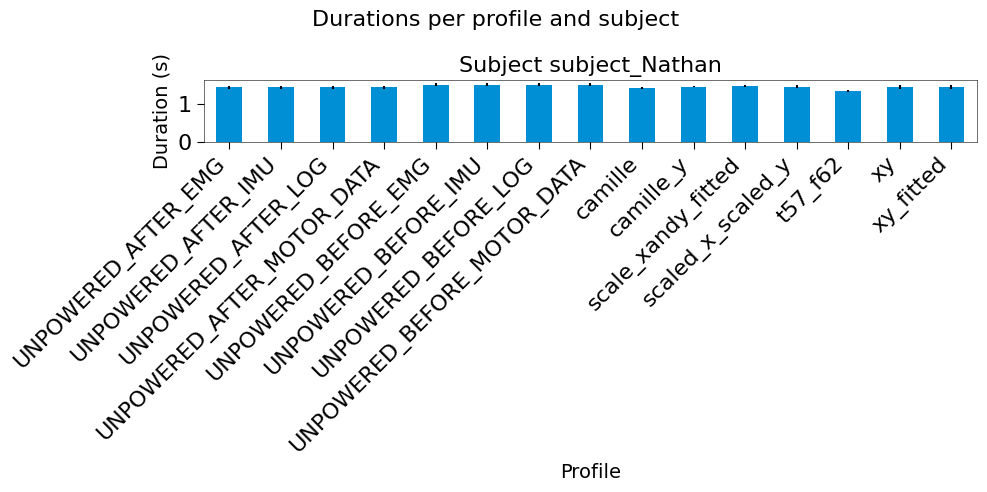

In [292]:
# Extract durations from the time ranges
fig, ax = plt.subplots(1, ncols=len(subject_data.keys()), figsize=(10, 5))
fig.suptitle("Durations per profile and subject")

# Ensure `ax` is always a list
if len(subject_data.keys()) == 1:
    ax = [ax]

for i, subject in enumerate(subject_data.keys()):
    for session in subject_data[subject].keys():
        
        relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges_imu"]

        durations = {profile: [time_range.max - time_range.min for time_range in time_ranges["ranges"]] for profile, time_ranges in relevant_time_ranges.items()}

        # Drop empty keys
        durations = {k: v for k, v in durations.items() if v}

        # Sort and create DataFrame
        durations = dict(sorted(durations.items()))
        durations_df = pd.DataFrame.from_dict(durations, orient='index').T

        # Plot mean and std of the durations
        durations_df.mean().plot(kind='bar', yerr=durations_df.std(), ax=ax[i])
        ax[i].set_ylabel("Duration (s)")
        ax[i].set_xlabel("Profile")
        ax[i].set_title(f"Subject {subject}")
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig("../paper_figures/durations_per_profile.svg", format='svg')
plt.savefig("../paper_figures/durations_per_profile.png", dpi=500, format='png')
plt.savefig(latex_figure_dir / "emg_plots" / "durations_per_profile.png", dpi=500, format="png")
plt.show()


### Time windows across all iterations

In [ ]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]

        motor_data_dfs = filtered_session_data["UNPOWERED"]["BEFORE"]["MOTOR_DATA"][0]

        for power in filtered_session_data["UNPOWERED"].keys():
            motor_data_dfs = filtered_session_data["UNPOWERED"][power]["MOTOR_DATA"]

            for j, motor_df in enumerate(motor_data_dfs):
                # Filter out data to look only for indices after 0.1 seconds
                motor_df_after_01s = motor_df[motor_df.index > 0.2]
                # print(motor_df_after_01s["Percentage"])
                start_index = motor_df_after_01s[motor_df_after_01s['Percentage'] > 10].index.min()
                stop_index = motor_df_after_01s[motor_df_after_01s['Percentage'] > 85].index.min()

                plt.plot(motor_df_after_01s.index, motor_df_after_01s["Percentage"])
                plt.axvline(x=start_index-0.05, color='r', linestyle='--')
                plt.axvline(x=stop_index+0.1, color='r', linestyle='--')
                plt.show()
                

          Percentage  target_tau_1  measured_tau_1   theta_1  velocity_1  \
time                                                                       
0.005239       100.0      0.000000       -0.005861  0.737964    -0.01221   
0.010993         0.0      0.000566       -0.017582  0.737964    -0.01221   
0.015688         0.0      0.000566       -0.005861  0.737964    -0.01221   
0.020950         0.0      0.000566       -0.005861  0.737964    -0.01221   
0.025541         0.0      0.000566       -0.005861  0.737964    -0.01221   
...              ...           ...             ...       ...         ...   
4.465839       100.0      0.000000       -0.005861  2.171550    -0.01221   
4.470262       100.0      0.000000       -0.029304  2.171550    -0.01221   
4.475416       100.0      0.000000       -0.005861  2.171550    -0.01221   
4.479917       100.0      0.000000        0.005861  2.171550    -0.01221   
4.484715       100.0      0.000000       -0.017582  2.171550    -0.01221   

          t

In [22]:
for profile in relevant_time_ranges.keys():
    # print(profile, relevant_time_ranges[profile]["ranges"])
    print(profile)
    for i, time_range in enumerate(relevant_time_ranges[profile]["ranges"]):
        print(f"Iteration {i+1}: {time_range.min:.2f} - {time_range.max:.2f}")
        print(f"Duration: {time_range.max - time_range.min:.2f}")

    print("\n")

Camille_no_counter
Iteration 1: 0.59 - 1.61
Duration: 1.01
Iteration 2: 0.73 - 1.64
Duration: 0.91
Iteration 3: 0.40 - 1.39
Duration: 1.00
Iteration 4: 0.64 - 1.67
Duration: 1.03
Iteration 5: 0.54 - 1.46
Duration: 0.92


peak_time_57_peak_force_62_scaled
Iteration 1: 0.83 - 1.73
Duration: 0.90
Iteration 2: 0.67 - 1.63
Duration: 0.95
Iteration 3: 0.76 - 1.65
Duration: 0.89
Iteration 4: 0.65 - 1.59
Duration: 0.94
Iteration 5: 0.79 - 1.58
Duration: 0.79


simulation_profile_Camille_scaled
Iteration 1: 0.50 - 1.41
Duration: 0.92
Iteration 2: 0.73 - 1.75
Duration: 1.02
Iteration 3: 0.82 - 1.62
Duration: 0.80
Iteration 4: 0.88 - 1.68
Duration: 0.80
Iteration 5: 0.72 - 1.53
Duration: 0.81


simulation_profile_Camille_scalex_scaley_scaled
Iteration 1: 0.16 - 1.17
Duration: 1.01
Iteration 2: 0.65 - 1.54
Duration: 0.88
Iteration 3: 0.55 - 1.53
Duration: 0.98
Iteration 4: 0.76 - 1.70
Duration: 0.94
Iteration 5: 0.69 - 1.53
Duration: 0.84


simulation_profile_Camille_xy_scaled
Iteration 1: 0.44 - 

In [288]:
# Manually remove one iteration
# print(filtered_session_data["UNPOWERED"]["BEFORE"]["EMG"][4])
# print(filtered_session_data["UNPOWERED"]["BEFORE"]["MOTOR_DATA"][4])

# filtered_session_data["UNPOWERED"]["BEFORE"]["EMG"].pop(4)
# filtered_session_data["UNPOWERED"]["BEFORE"]["MOTOR_DATA"].pop(4)

In [298]:
# Iterate through all profiles and calculate the mean muscle activation during the relevant time period
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]

        relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges_imu"]

        mean_muscle_activations = {}


        for profile in filtered_session_data["ASSISTED"].keys():
            mean_muscle_activations[profile] = []

            for i, emg_data in enumerate(filtered_session_data["ASSISTED"][profile]["EMG"]):
                # Remove the first 3 seconds of EMG data
                emg_data = emg_data[emg_data.index >= 3]  # Keep data from 3 seconds onwards
                emg_data.index = emg_data.index - 3  # Reset index to start from 0
                time_range = relevant_time_ranges[profile]["ranges"][i]
                emg_data = emg_data[(emg_data.index >= time_range.min) & (emg_data.index <= time_range.max)]
                # emg_data = emg_data[(emg_data.index >= 0.5) & (emg_data.index <= 1.7)]
                mean_muscle_activations[profile].append(emg_data.mean())
                

        for unpowered_time in filtered_session_data["UNPOWERED"].keys():
            mean_muscle_activations[f"UNPOWERED_{unpowered_time}"] = []

            for i, emg_data in enumerate(filtered_session_data["UNPOWERED"][unpowered_time]["EMG"]):
                emg_data = emg_data[emg_data.index >= 3]
                emg_data.index = emg_data.index - 3
                time_range = relevant_time_ranges[f"UNPOWERED_{unpowered_time}"]["ranges"][i]
                emg_data = emg_data[(emg_data.index >= time_range.min) & (emg_data.index <= time_range.max)]
                mean_muscle_activations[f"UNPOWERED_{unpowered_time}"].append(emg_data.mean())

        subject_data[subject][session]["mean_muscle_activations"] = mean_muscle_activations


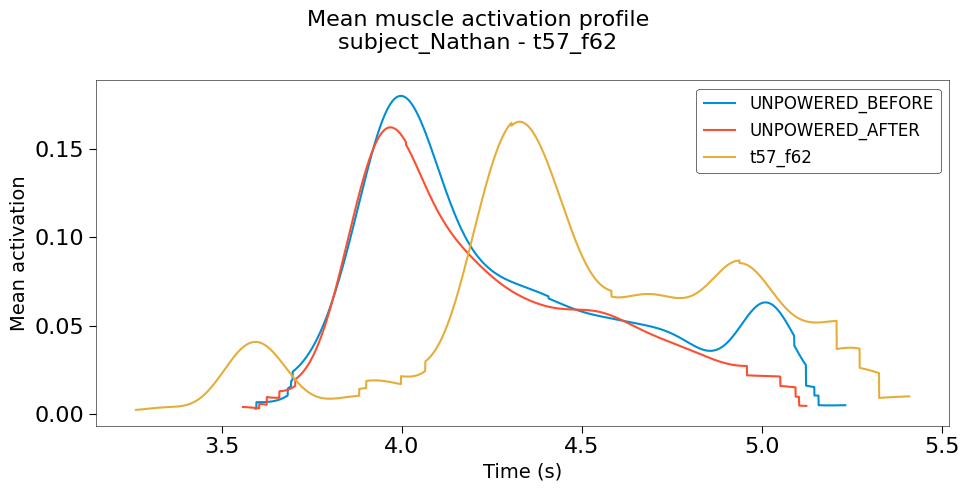

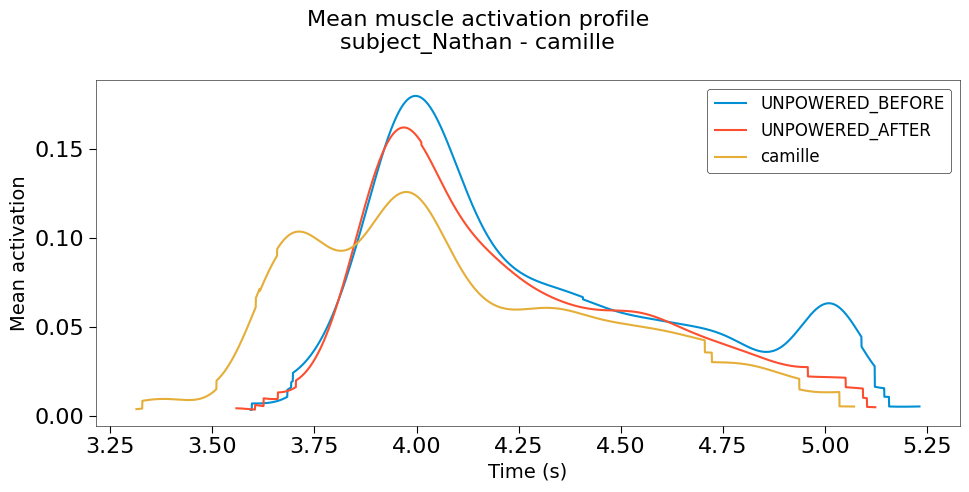

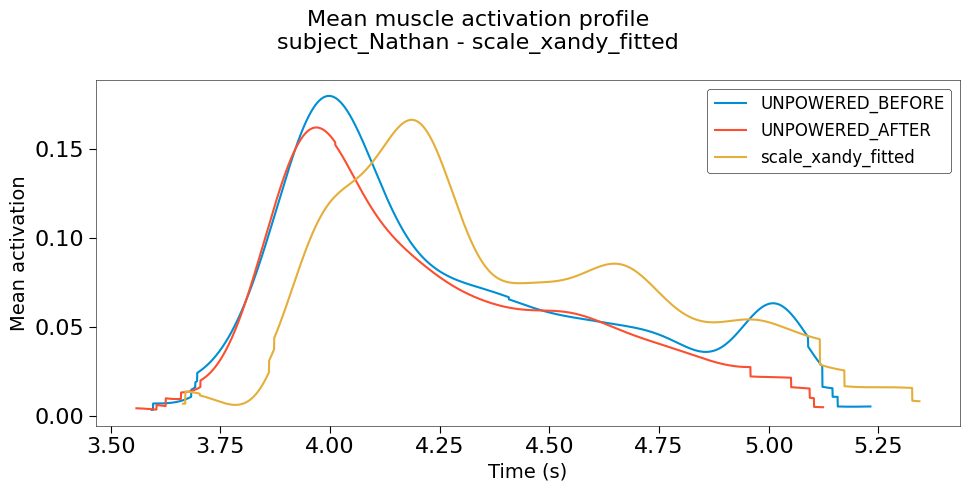

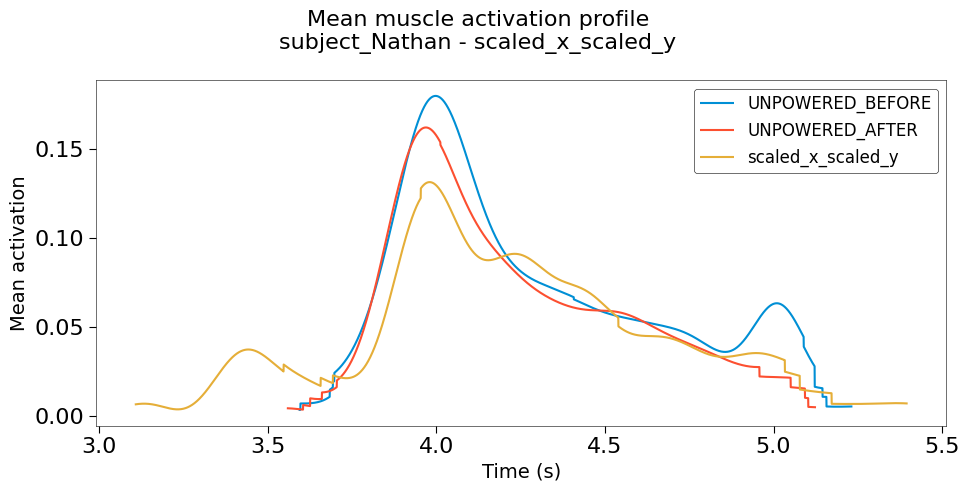

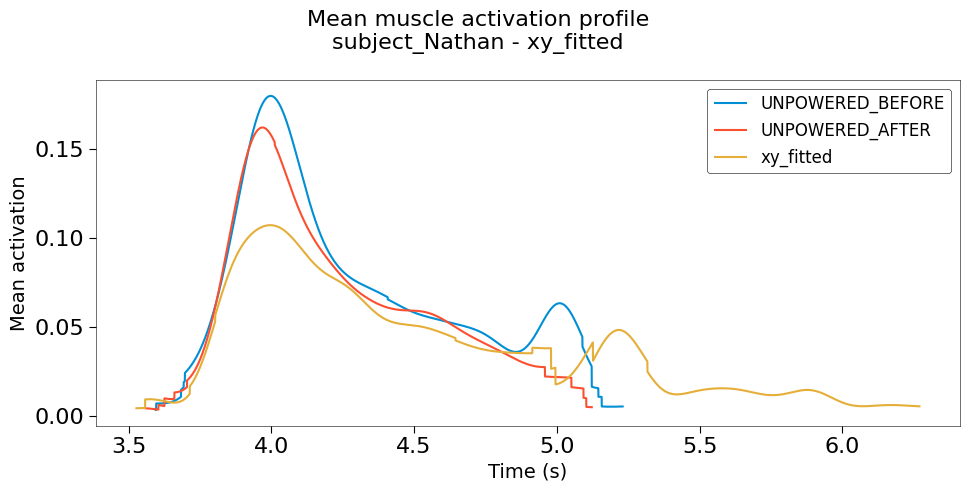

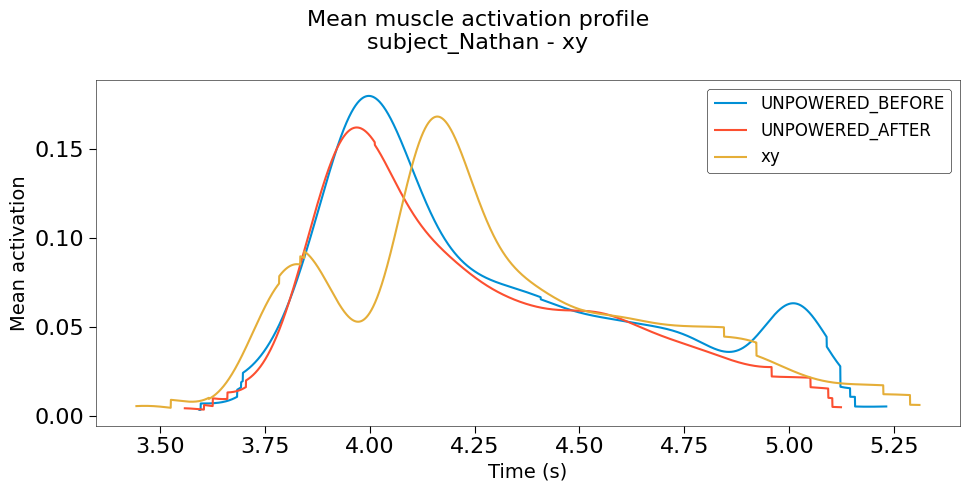

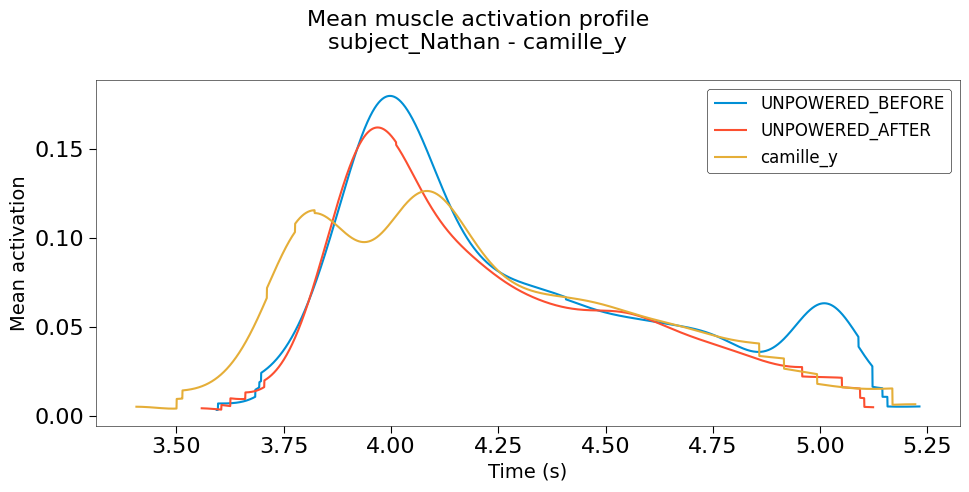

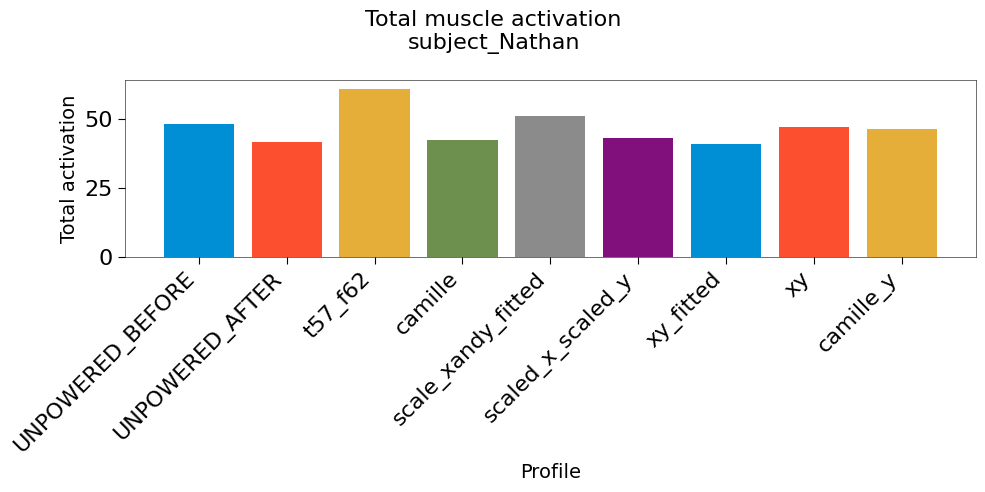

In [309]:
# Iterate through all profiles and calculate and plot a mean profile for each profile over all 5 iterations
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]

        mean_muscle_activations = {}

        mean_muscle_activations = subject_data[subject][session]["mean_muscle_activations"]

        plot_dir = subject_dirs[subject][session]["plot_dir"] / "mean_muscle_activation_profiles"
        plot_dir.mkdir(exist_ok=True)

        mean_profiles = {}
        total_activation = {}

        relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges_imu"]

        for unpowered_time in filtered_session_data["UNPOWERED"].keys():
            mean_activation_profile = pd.DataFrame()

            for i, emg_data in enumerate(filtered_session_data["UNPOWERED"][unpowered_time]["EMG"]):
                 # Remove the first 3 seconds of EMG data
                # emg_data = emg_data[emg_data.index >= 3]  # Keep data from 3 seconds onwards
                # emg_data.index = emg_data.index - 3  # Reset index to start from 0
                time_range = relevant_time_ranges[f"UNPOWERED_{unpowered_time}"]["ranges"][i]
                emg_data = emg_data[(emg_data.index >= time_range.min) & (emg_data.index <= time_range.max)]
                # emg_data = emg_data[(emg_data.index >= 0.4) & (emg_data.index <= 1.8)]
                if mean_activation_profile.empty:
                    mean_activation_profile = emg_data/len(filtered_session_data["UNPOWERED"][unpowered_time]["EMG"])
                else:
                    # Reindex both DataFrames to the union of their indices to handle different lengths
                    common_index = mean_activation_profile.index.union(emg_data.index)
                    # Reindex both DataFrames to the common index and fill missing values with 0
                    mean_activation_profile = mean_activation_profile.reindex(common_index, fill_value=0)
                    emg_data = emg_data.reindex(common_index, fill_value=0)
                    # Add the reindexed emg_data to mean_activation_profile
                    mean_activation_profile += emg_data / len(filtered_session_data["UNPOWERED"][unpowered_time]["EMG"])

            # Sum over all muscles to get mean activation profile
            mean_activation_profile = mean_activation_profile.sum(axis=1) / len(filtered_session_data["UNPOWERED"][unpowered_time]["EMG"])
            mean_profiles[f"UNPOWERED_{unpowered_time}"] = mean_activation_profile

            # Get are under the curve for the mean activation profile
            total_activation[f"UNPOWERED_{unpowered_time}"] = mean_activation_profile.sum()/len(filtered_session_data["UNPOWERED"][unpowered_time]["EMG"])

        
        for profile in filtered_session_data["ASSISTED"].keys():
            mean_activation_profile = pd.DataFrame()

            for i, emg_data in enumerate(filtered_session_data["ASSISTED"][profile]["EMG"]):
                # Remove the first 3 seconds of EMG data
                # emg_data = emg_data[emg_data.index >= 3]  # Keep data from 3 seconds onwards
                # emg_data.index = emg_data.index - 3  # Reset index to start from 0
                time_range = relevant_time_ranges[profile]["ranges"][i]
                emg_data = emg_data[(emg_data.index >= time_range.min) & (emg_data.index <= time_range.max)]
                # emg_data = emg_data[(emg_data.index >= 0.4) & (emg_data.index <= 1.8)]
                if mean_activation_profile.empty:
                    mean_activation_profile = emg_data/len(filtered_session_data["ASSISTED"][profile]["EMG"])
                else:
                    # Reindex both DataFrames to the union of their indices to handle different lengths
                    common_index = mean_activation_profile.index.union(emg_data.index)
                    # Reindex both DataFrames to the common index and fill missing values with 0
                    mean_activation_profile = mean_activation_profile.reindex(common_index, fill_value=0)
                    emg_data = emg_data.reindex(common_index, fill_value=0)
                    # Add the reindexed emg_data to mean_activation_profile
                    mean_activation_profile += emg_data / len(filtered_session_data["UNPOWERED"][unpowered_time]["EMG"])
            
            # Get are under the curve for the mean activation profile
            total_activation[profile] = mean_activation_profile.sum()/len(filtered_session_data["ASSISTED"][profile]["EMG"])

            # Sum over all muscles to get mean activation profile
            mean_activation_profile = mean_activation_profile.sum(axis=1) / len(filtered_session_data["ASSISTED"][profile]["EMG"])
            mean_profiles[profile] = mean_activation_profile
            
            filename = plot_dir / f"mean_activation_profile_percentage{profile}"
            
            # Plot both unassisted mean profiles in addition to the current assisted profile
            fig, ax = plt.subplots(1, figsize=(10, 5))
            fig.suptitle(f"Mean muscle activation profile\n{subject} - {profile}")

            for unpowered_time in filtered_session_data["UNPOWERED"].keys():
                ax.plot(mean_profiles[f"UNPOWERED_{unpowered_time}"].index, mean_profiles[f"UNPOWERED_{unpowered_time}"], label=f"UNPOWERED_{unpowered_time}")

            ax.plot(mean_profiles[profile].index, mean_profiles[profile], label=profile)
            ax.set_ylabel("Mean activation")
            ax.set_xlabel("Time (s)")
            ax.legend()
            plt.tight_layout()
            plt.savefig(filename, dpi=500, format='svg')
            plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
            plt.show()
        
        # Plot the total activation for each profile
        fig, ax = plt.subplots(1, figsize=(10, 5))
        fig.suptitle(f"Total muscle activation\n{subject}")
        for profile in total_activation.keys():
            ax.bar(profile, total_activation[profile], label=profile)
        ax.set_ylabel("Total activation")
        ax.set_xlabel("Profile")
        # ax.legend()
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(plot_dir / "total_activation_percentage", dpi=500, format='svg')
        plt.savefig(plot_dir / "total_activation_percentage.png", dpi=500, format='png')
        plt.show()


In [304]:
# Iterate through all profiles and calculate and plot all means
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]

        mean_muscle_activations = subject_data[subject][session]["mean_muscle_activations"]

        plot_dir = subject_dirs[subject][session]["plot_dir"] / "mean_muscle_activations"
        plot_dir.mkdir(exist_ok=True)

        for profile in filtered_session_data["ASSISTED"].keys():
            mean_activation_df = pd.DataFrame(mean_muscle_activations[profile])
            mean_activation_df.index = mean_activation_df.index
            filename = plot_dir / f"{profile}_mean_activation.svg"
            # mean_activation_df.plot(title=f"{profile} mean muscle activation", xlabel="Iteration", ylabel="EMG (% MVIC)", figsize=(10, 5))
            # plt.tight_layout()
            # plt.savefig(filename, dpi=500, format='svg')
            # plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
            # plt.show()    

Index(['BF_LEFT', 'BF_RIGHT', 'G_LEFT', 'G_RIGHT', 'IMU', 'RF_LEFT',
       'RF_RIGHT', 'SO_RIGHT', 'TA_RIGHT', 'VM_LEFT', 'VM_RIGHT', 'TA_LEFT',
       'SO_LEFT'],
      dtype='object')
nan


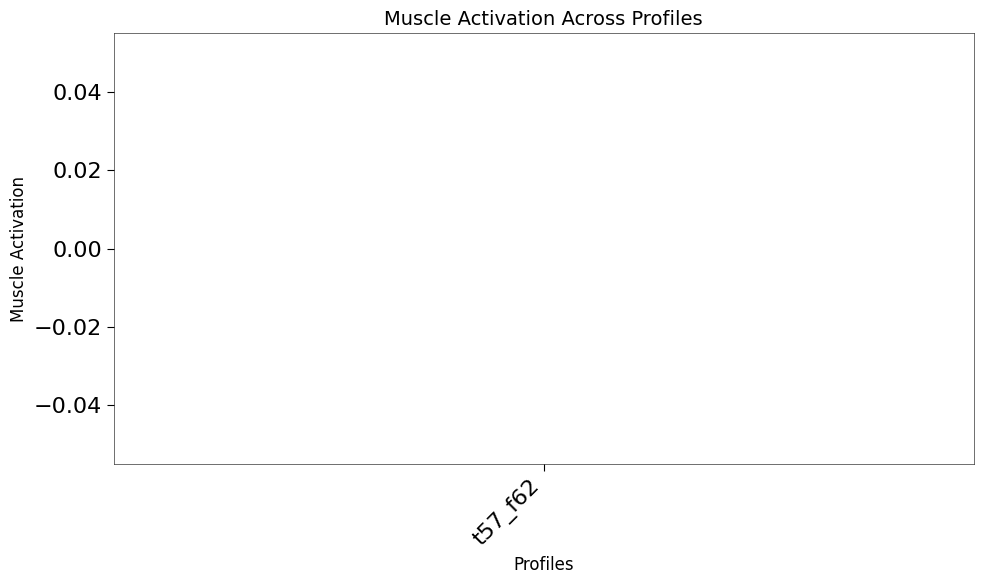

In [310]:
# plot cumulative mean muscle activations, averaged over 5 iterations
subject = "subject_Nathan"
session = "October_31"

mean_muscle_activations = subject_data[subject][session]["mean_muscle_activations"][profile]
mean_muscle_activations_df = pd.DataFrame(mean_muscle_activations)
print(mean_muscle_activations_df.keys())
# calculate mean value for each key
mean = mean_muscle_activations_df.mean()

print(sum(mean))

mean_sum_muscle_activations = {}

for profile in subject_data[subject][session]["mean_muscle_activations"].keys():
    # iterate over all 5 iterations
    mean_muscle_activations = subject_data[subject][session]["mean_muscle_activations"][profile]
    mean_muscle_activations_df = pd.DataFrame(mean_muscle_activations)
    mean = mean_muscle_activations_df.mean()
    sum_mean = sum(mean)
    mean_sum_muscle_activations[profile] = sum_mean


# Extract profile names (x-axis) and muscle activation values (y-axis)
profiles = list(mean_sum_muscle_activations.keys())
muscle_activation_values = list(mean_sum_muscle_activations.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(profiles, muscle_activation_values, color='steelblue')

# Add labels and title
plt.xlabel('Profiles', fontsize=12)
plt.ylabel('Muscle Activation', fontsize=12)
plt.title('Muscle Activation Across Profiles', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
# plot cumulative mean muscle activations, averaged over 5 iterations
subject = "subject_Nathan"
session = "October_31"

mean_activations_per_muscle = {}

for muscle in ["RF_LEFT", "RF_RIGHT", "BF_LEFT", "BF_RIGHT", "VM_LEFT", "VM_RIGHT", "G_LEFT", "G_RIGHT"]:
    mean_activations_per_muscle[muscle] = {}
    for profile in subject_data[subject][session]["mean_muscle_activations"].keys():
        # get mean muscle activations for each profile
        mean_muscle_activations = subject_data[subject][session]["mean_muscle_activations"][profile]
        mean_muscle_activations_df = pd.DataFrame(mean_muscle_activations)
        mean = mean_muscle_activations_df.mean()
        mean_activations_per_muscle[muscle][profile] = mean[muscle]
        

    # Extract profile names (x-axis) and muscle activation values (y-axis)
    profiles = list(mean_activations_per_muscle[muscle].keys())
    muscle_activation_values = list(mean_activations_per_muscle[muscle].values())

    # Create a bar plot
    # plt.figure(figsize=(10, 6))
    # plt.bar(profiles, muscle_activation_values, color='steelblue')

    # # Add labels and title
    # plt.xlabel('Profiles', fontsize=12)
    # plt.ylabel('Muscle Activation', fontsize=12)
    # plt.title('Muscle Activation ' + muscle, fontsize=14)

    # # Rotate x-axis labels for better readability
    # plt.xticks(rotation=45, ha='right')

    # # Display the plot
    # plt.tight_layout()
    # plt.show()

KeyError: 'September_26'

### Time windows across all iterations

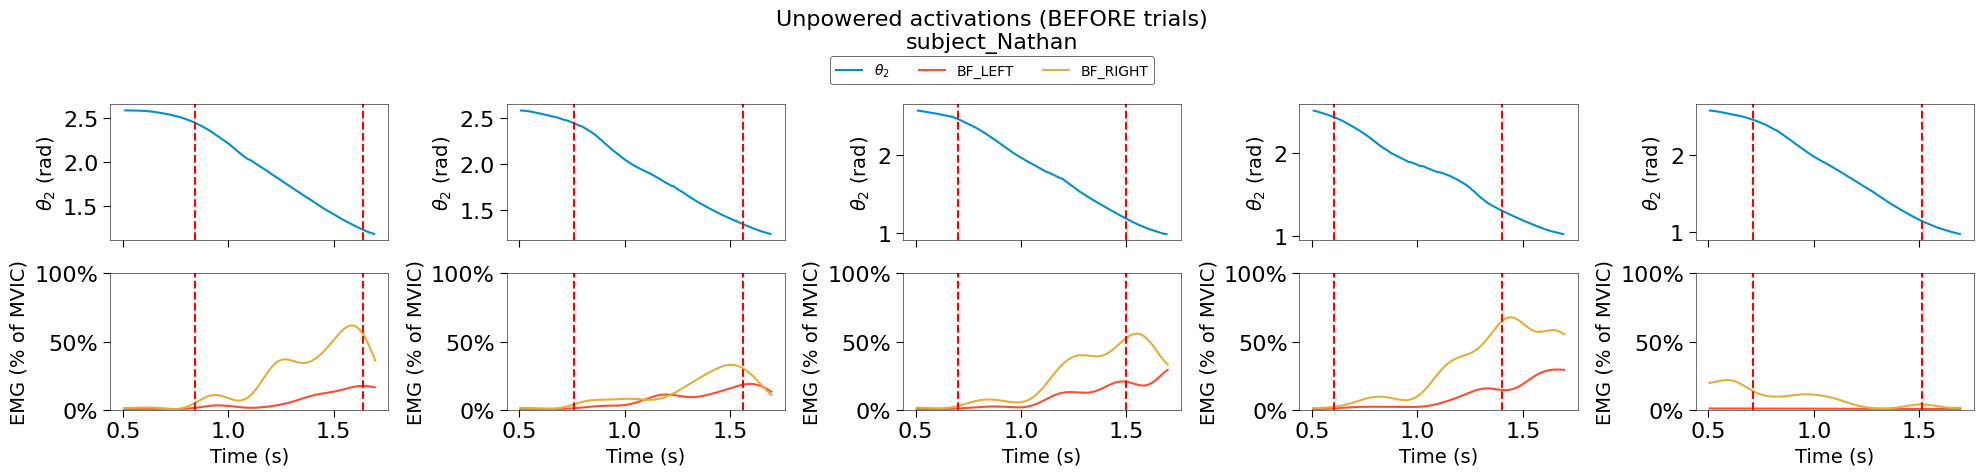

In [ ]:
subject = "subject_Nathan"
session = "Ocotber_31"
# profile = "Camille_no_counter"

filtered_session_data = subject_data[subject][session]["filtered_session_data"]
unique_muscles = get_unique_muscles(subject_data[subject][session]["filtered_session_data"])
relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges"]

filename = subject_dirs[subject][session]["plot_dir"] / f"unpowered_activations.svg"

fig, axs = plt.subplots(nrows=2, ncols=5, sharex='col', figsize=(20, 5))
fig.suptitle(f"Unpowered activations (BEFORE trials)\n{subject}")

t_unpowered = "BEFORE"

target_muscle = random.choice(unique_muscles)

for i, t_range in enumerate(relevant_time_ranges[f"UNPOWERED_{t_unpowered}"]["ranges"]):
    colors = iter(rcParams['axes.prop_cycle'].by_key()['color'])
    # marker_data = filtered_session_data["UNPOWERED"][t_unpowered]["MARKER_DATA"][i]

    # Remove the first 3 seconds of EMG data
    emg_data = filtered_session_data["UNPOWERED"][t_unpowered]["EMG"][i]
    emg_data = emg_data[emg_data.index >= 3]  # Keep data from 3 seconds onwards
    emg_data.index = emg_data.index - 3  # Reset index to start from 0
    time_range = relevant_time_ranges[profile]["ranges"][i]
    emg_data = emg_data[(emg_data.index >= time_range.min) & (emg_data.index <= time_range.max)]
    # emg_data = emg_data[(emg_data.index >= 0.5) & (emg_data.index <= 1.7)]

    motor_data = filtered_session_data["UNPOWERED"][t_unpowered]["MOTOR_DATA"][i]
    motor_data = motor_data[(motor_data.index >= time_range.min) & (motor_data.index <= time_range.max)]
    # motor_data = motor_data[(motor_data.index >= 0.5) & (motor_data.index <= 1.7)]


    # axs[0, i].set_title(f"unpowered_{i}")
    # axs[0, i].plot(marker_data.index, marker_data["Hip Left Z"], label="Hip Z", color=colors.__next__())
    # axs[0, i].set_ylabel("Hip Z (m)")
    # axs[0, i].axvline(t_range.min, linestyle='--', color="red")
    # axs[0, i].axvline(t_range.max, linestyle='--', color="red")
    
    # handles0, labels0 = axs[0, i].get_legend_handles_labels()

    axs[0, i].plot(motor_data.index, motor_data["theta_2"], colors.__next__(), label=r"$\theta_2$")
    axs[0, i].set_ylabel(r"$\theta_2$ (rad)")
    axs[0, i].axvline(t_range.min, linestyle='--', color="red")
    axs[0, i].axvline(t_range.max, linestyle='--', color="red")

    handles1, labels1 = axs[0, i].get_legend_handles_labels()

    axs[1, i].plot(emg_data.index, emg_data[f"{target_muscle}_LEFT"], label=f"{target_muscle}_LEFT", color=colors.__next__())
    axs[1, i].plot(emg_data.index, emg_data[f"{target_muscle}_RIGHT"], label=f"{target_muscle}_RIGHT", color=colors.__next__())
    axs[1, i].set_xlabel("Time (s)")
    axs[1, i].set_ylabel("EMG (% of MVIC)")
    axs[1, i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
    axs[1, i].axvline(t_range.min, linestyle='--', color="red")
    axs[1, i].axvline(t_range.max, linestyle='--', color="red")

    axs[1, i].set_ylim(0, 1)

    handles2, labels2 = axs[1, i].get_legend_handles_labels()

handles = handles1 + handles2 # + handles0
labels = labels1 + labels2 # + labels0 

fig.legend(handles, labels, loc='upper center', ncols=len(handles), bbox_to_anchor=(0.5, 0.9), fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(filename, dpi=500, format='svg')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
plt.show()

### Delete specific muscles

In [ ]:
muscles_to_remove = ["VM_LEFT", "VM_RIGHT"]

if False:
    for subject in subject_data.keys():
        for session in subject_data[subject].keys():
            filtered_session_data = subject_data[subject][session]["filtered_session_data"]

            for profile in filtered_session_data["ASSISTED"].keys():
                for emg_df in filtered_session_data["ASSISTED"][profile]["EMG"]:
                    emg_df.drop(columns=muscles_to_remove, inplace=True, errors="ignore")
            for t_unpowered in filtered_session_data["UNPOWERED"].keys():
                for emg_df in filtered_session_data["UNPOWERED"][t_unpowered]["EMG"]:
                    emg_df.drop(columns=muscles_to_remove, inplace=True, errors="ignore")
            for side in filtered_session_data["MVIC"].values():
                side.drop(columns=muscles_to_remove, inplace=True, errors="ignore")

### Full data corresponding to 1 iteration per profile

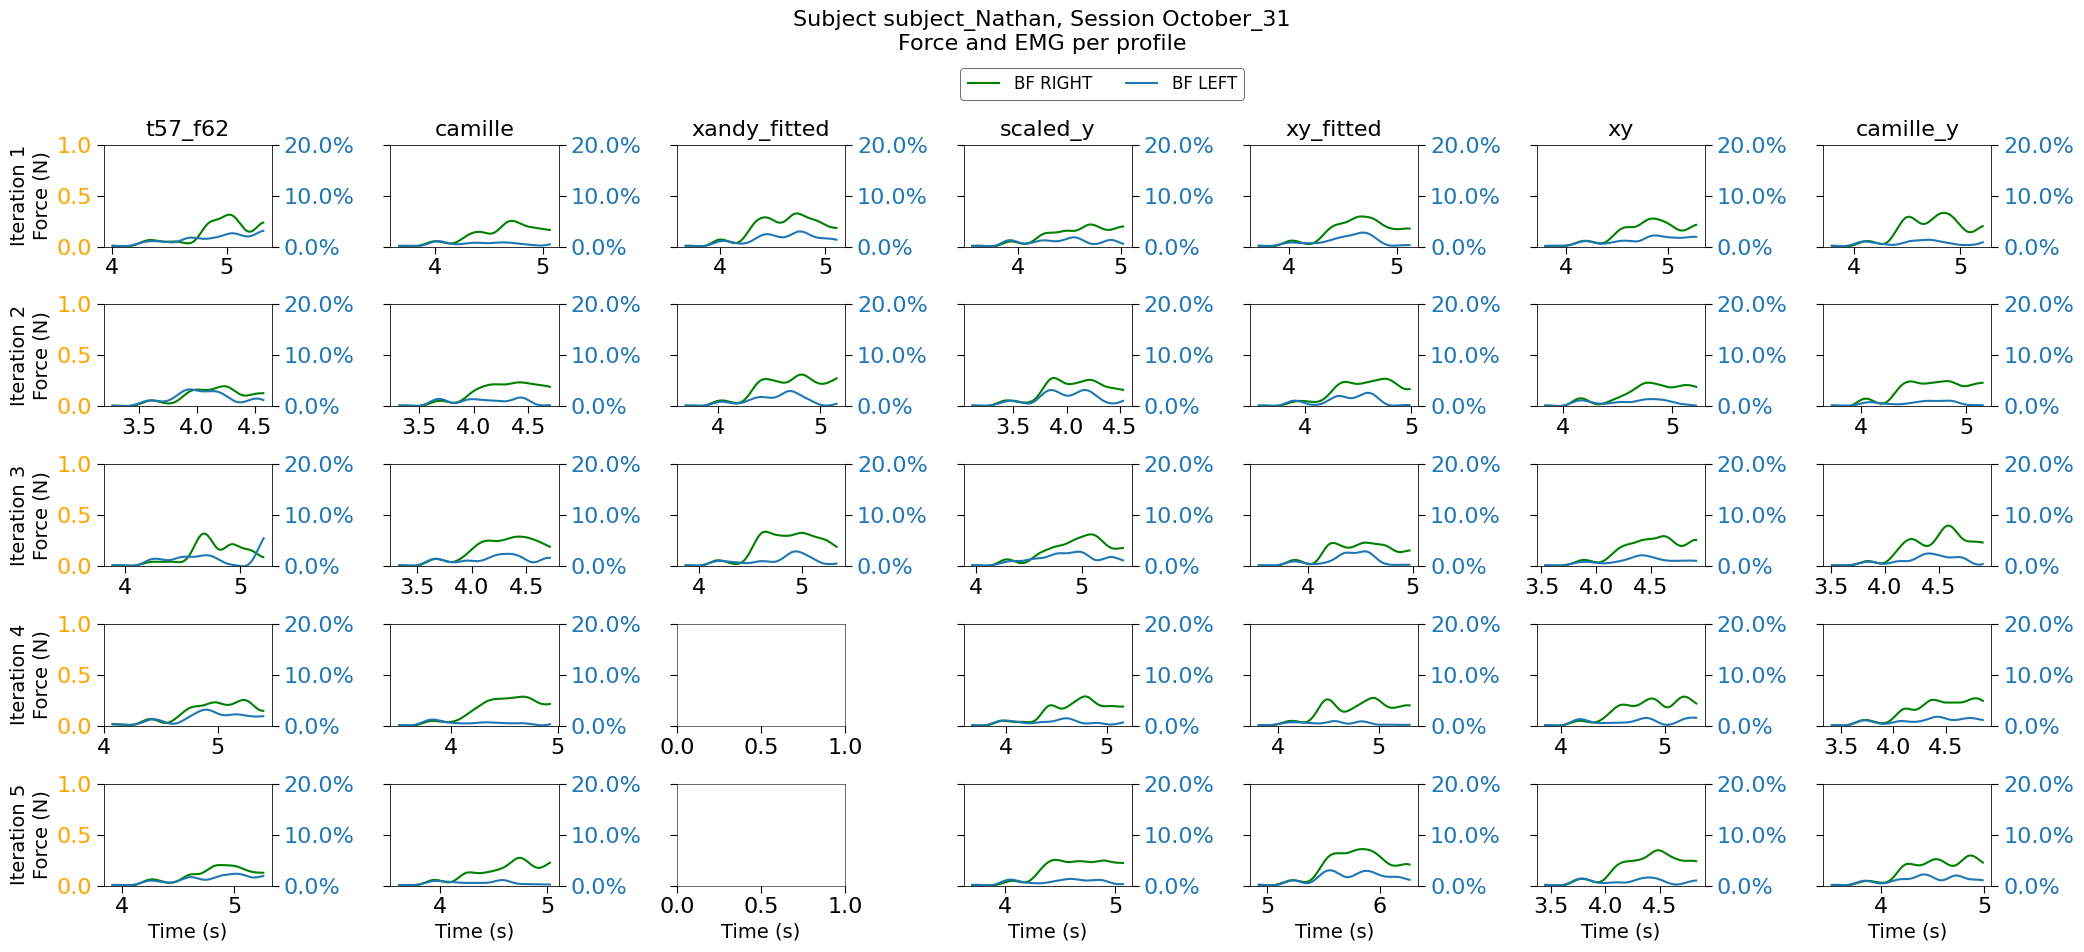

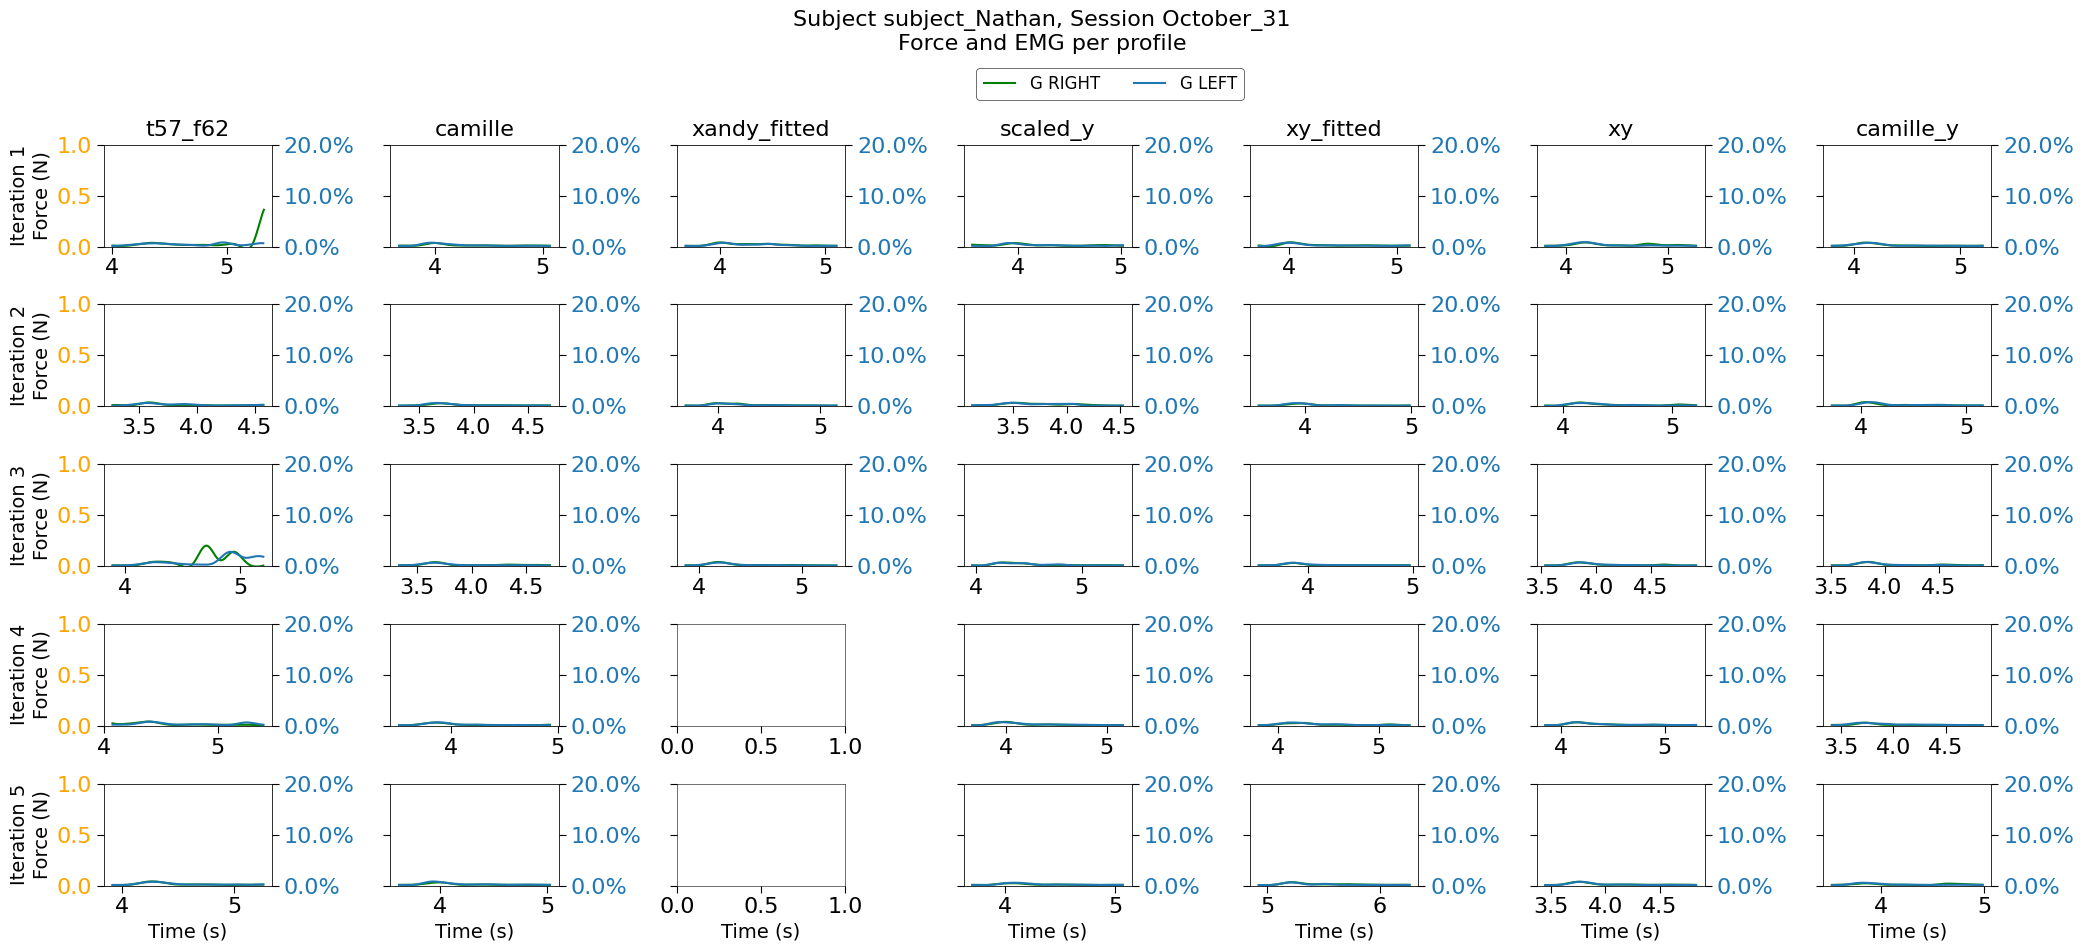

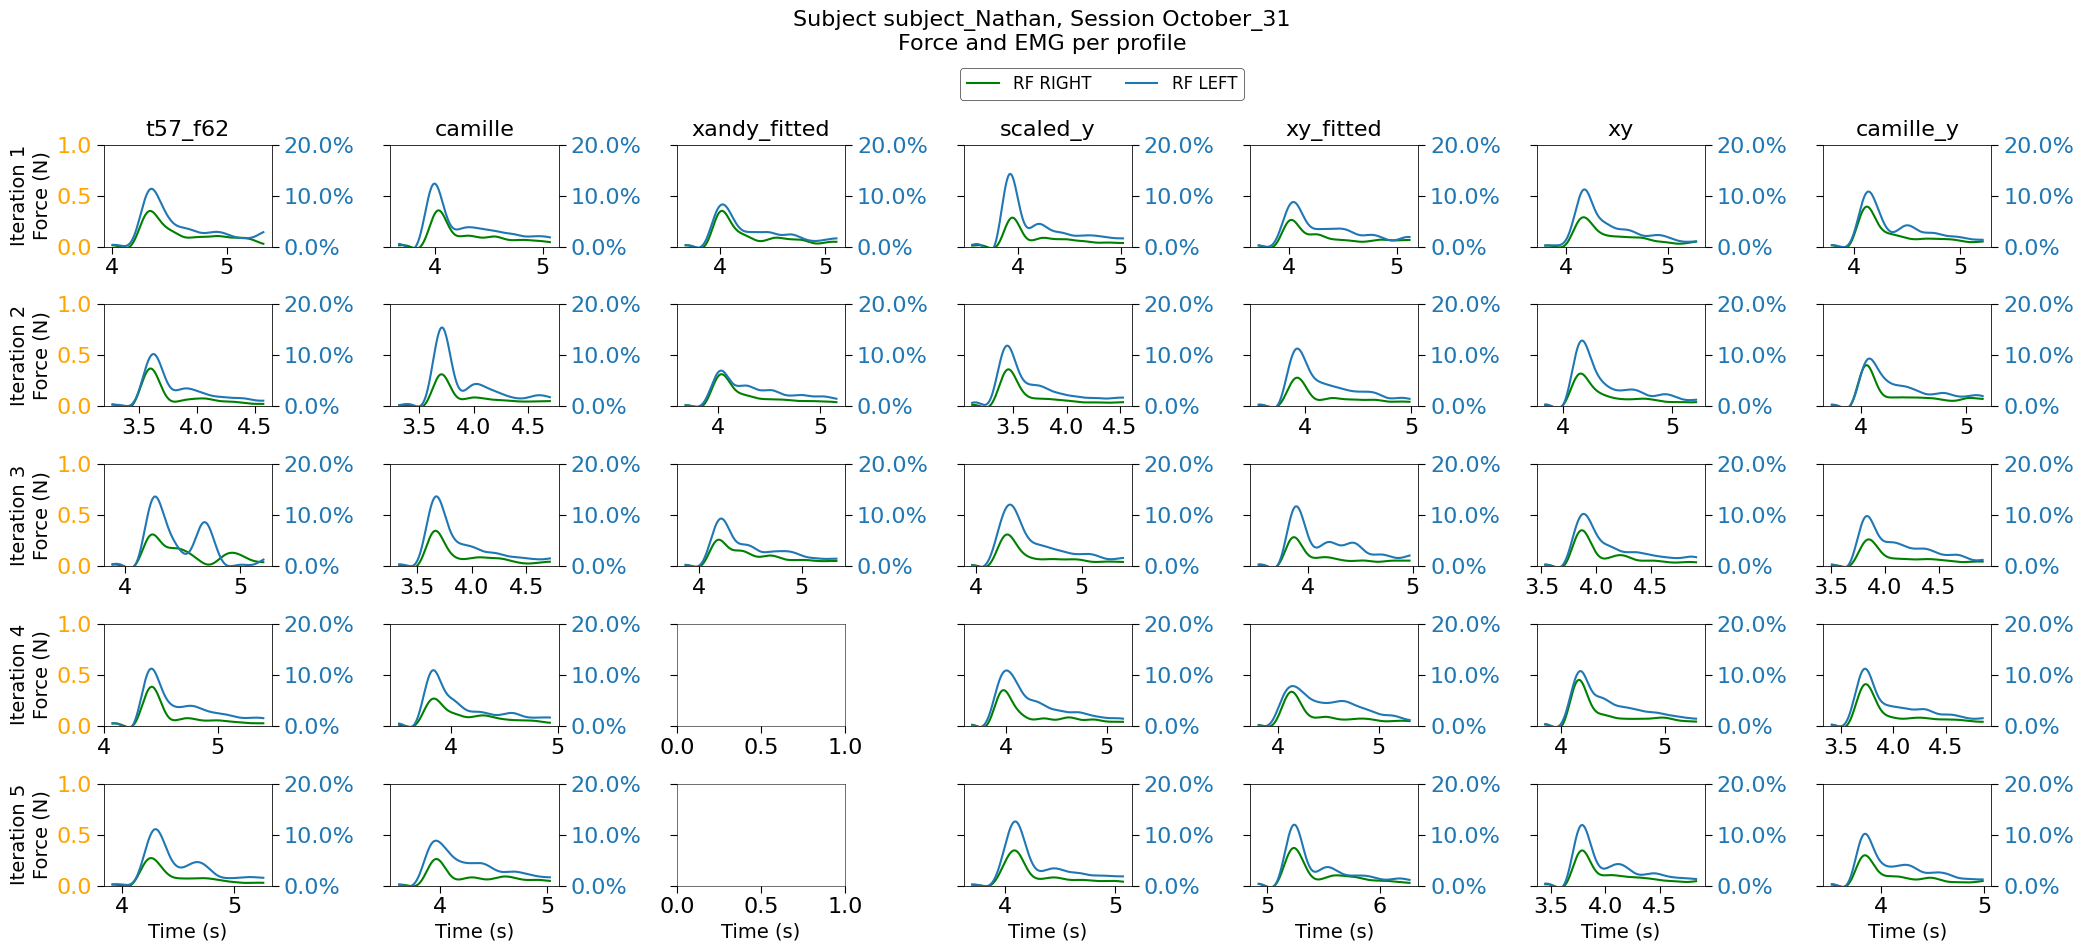

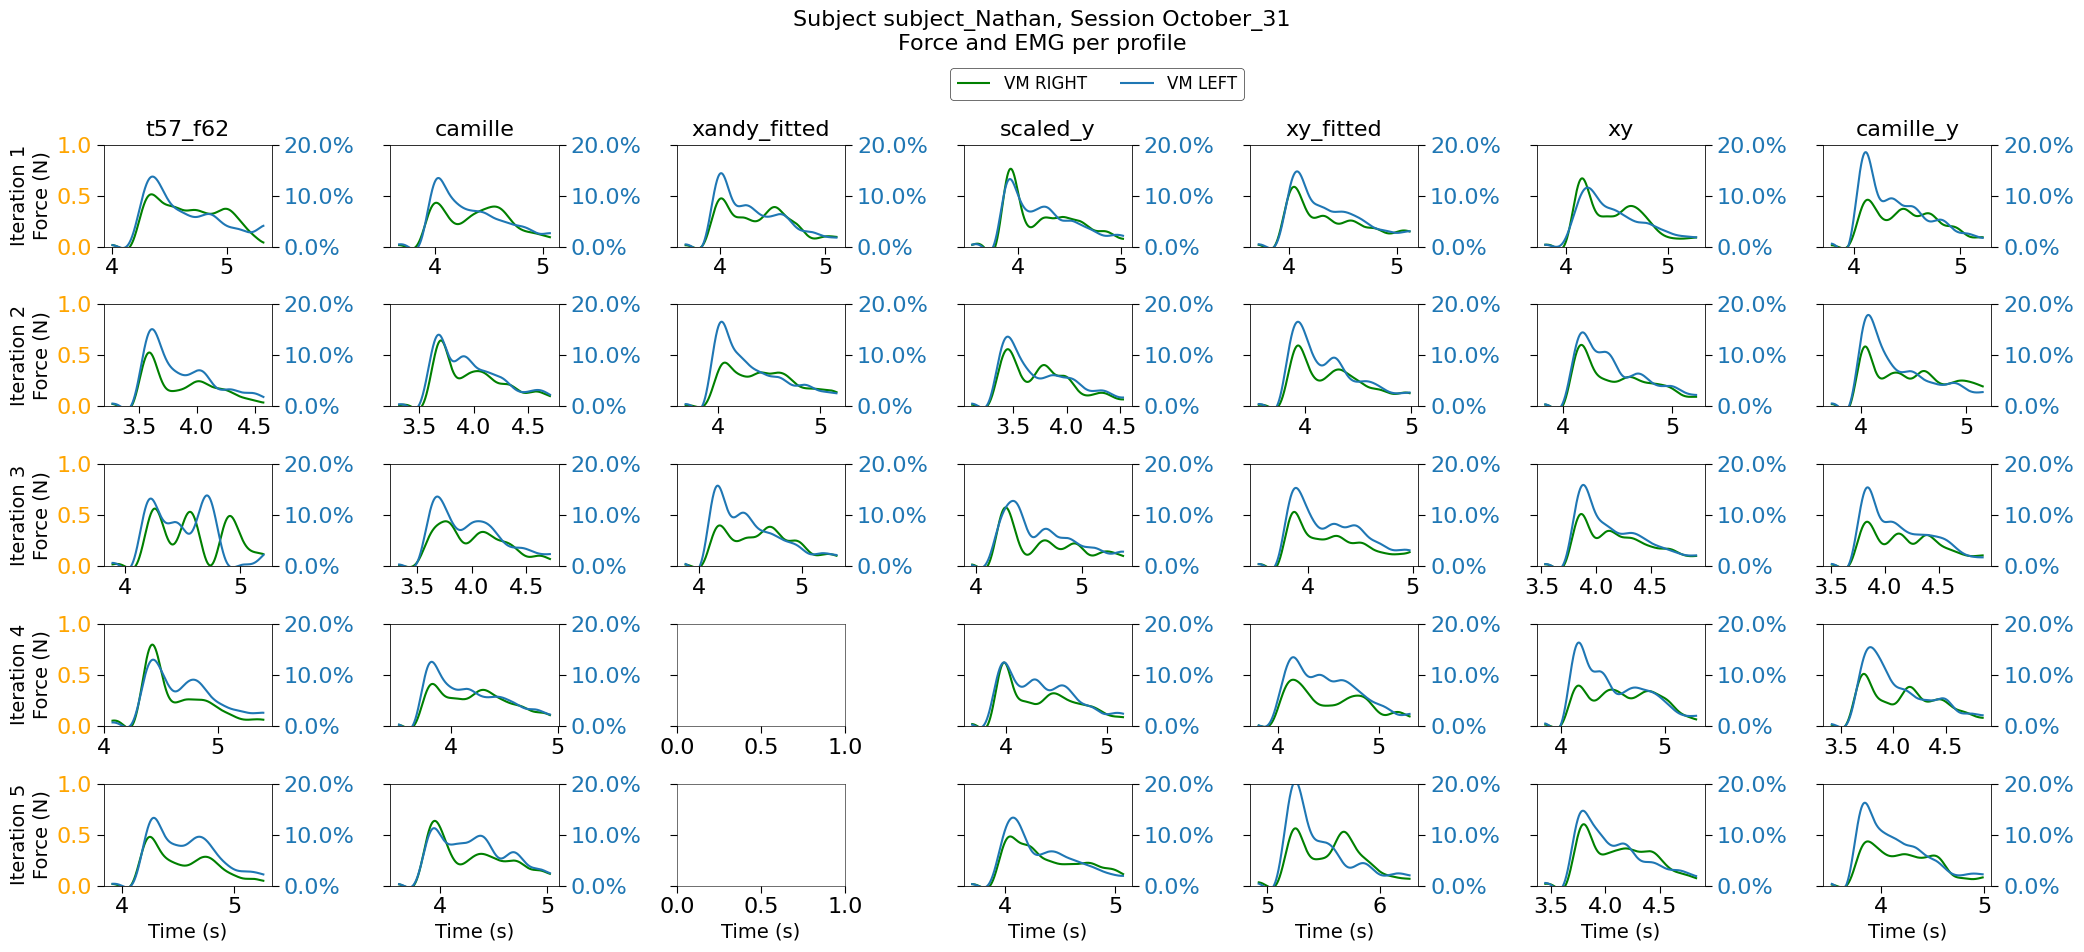

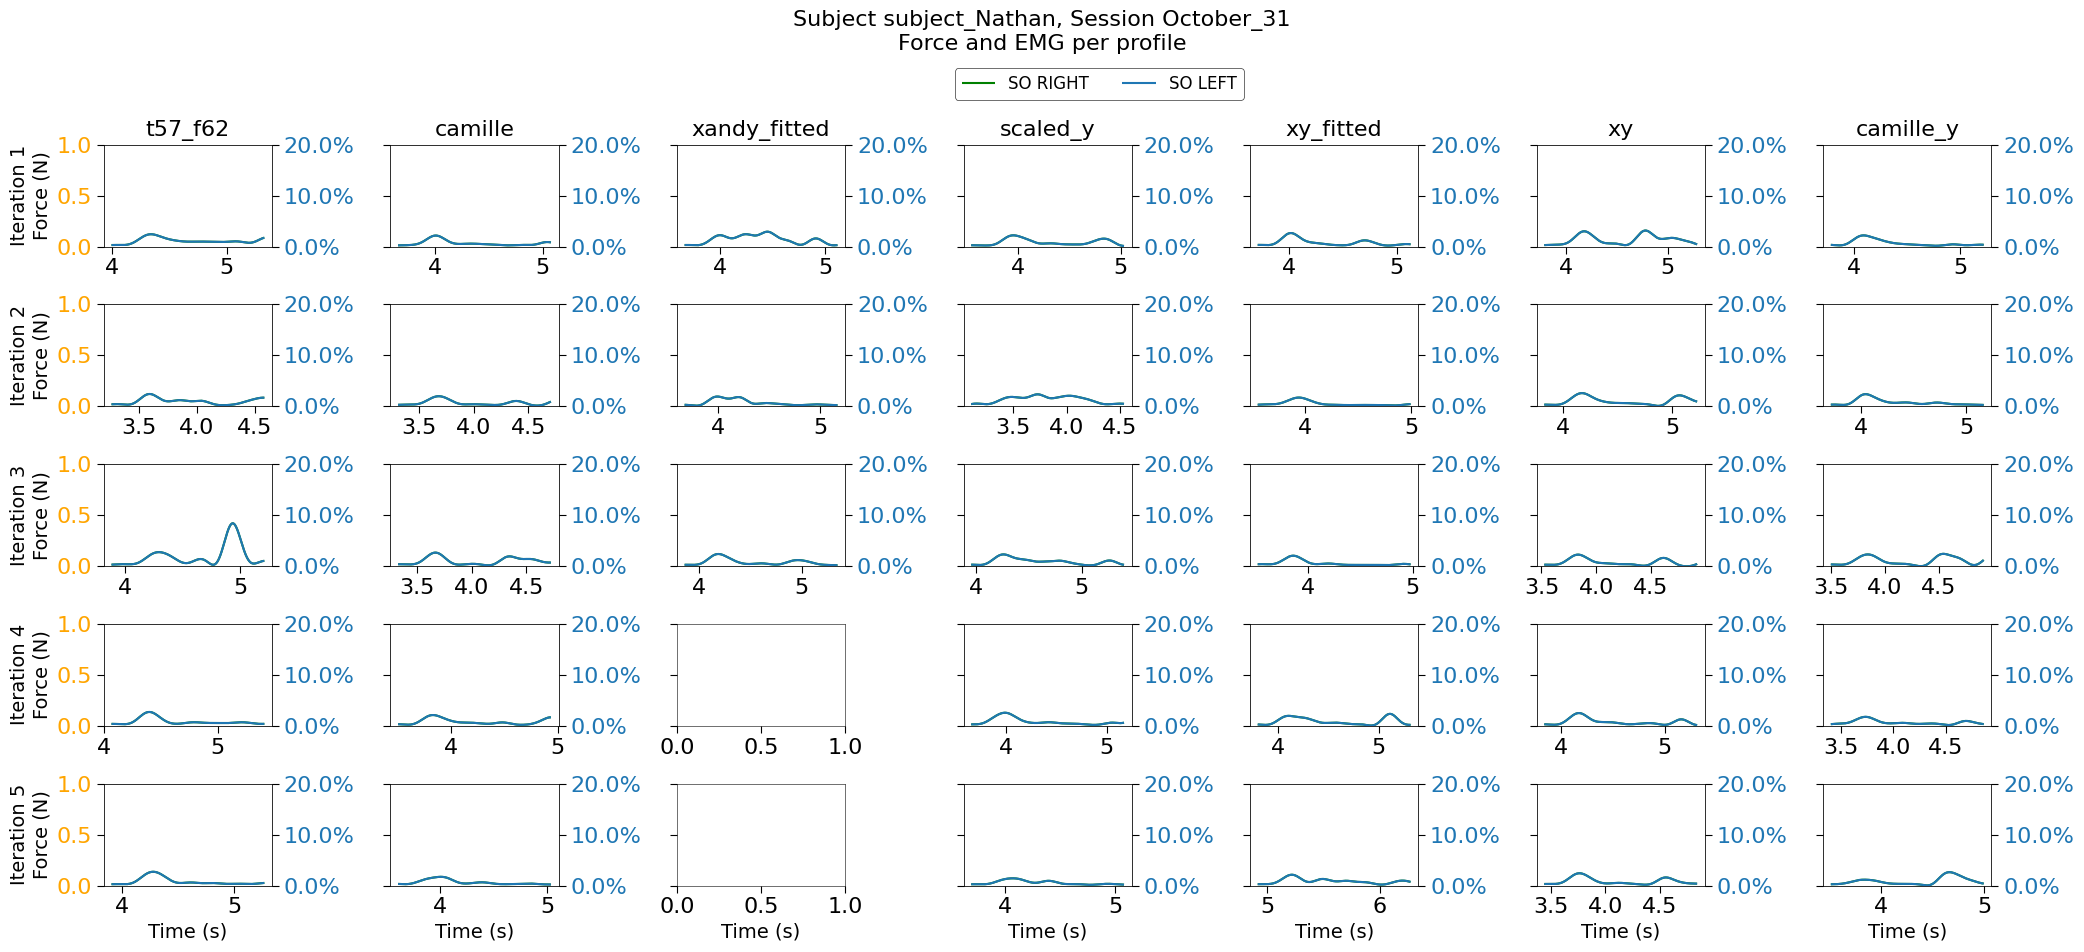

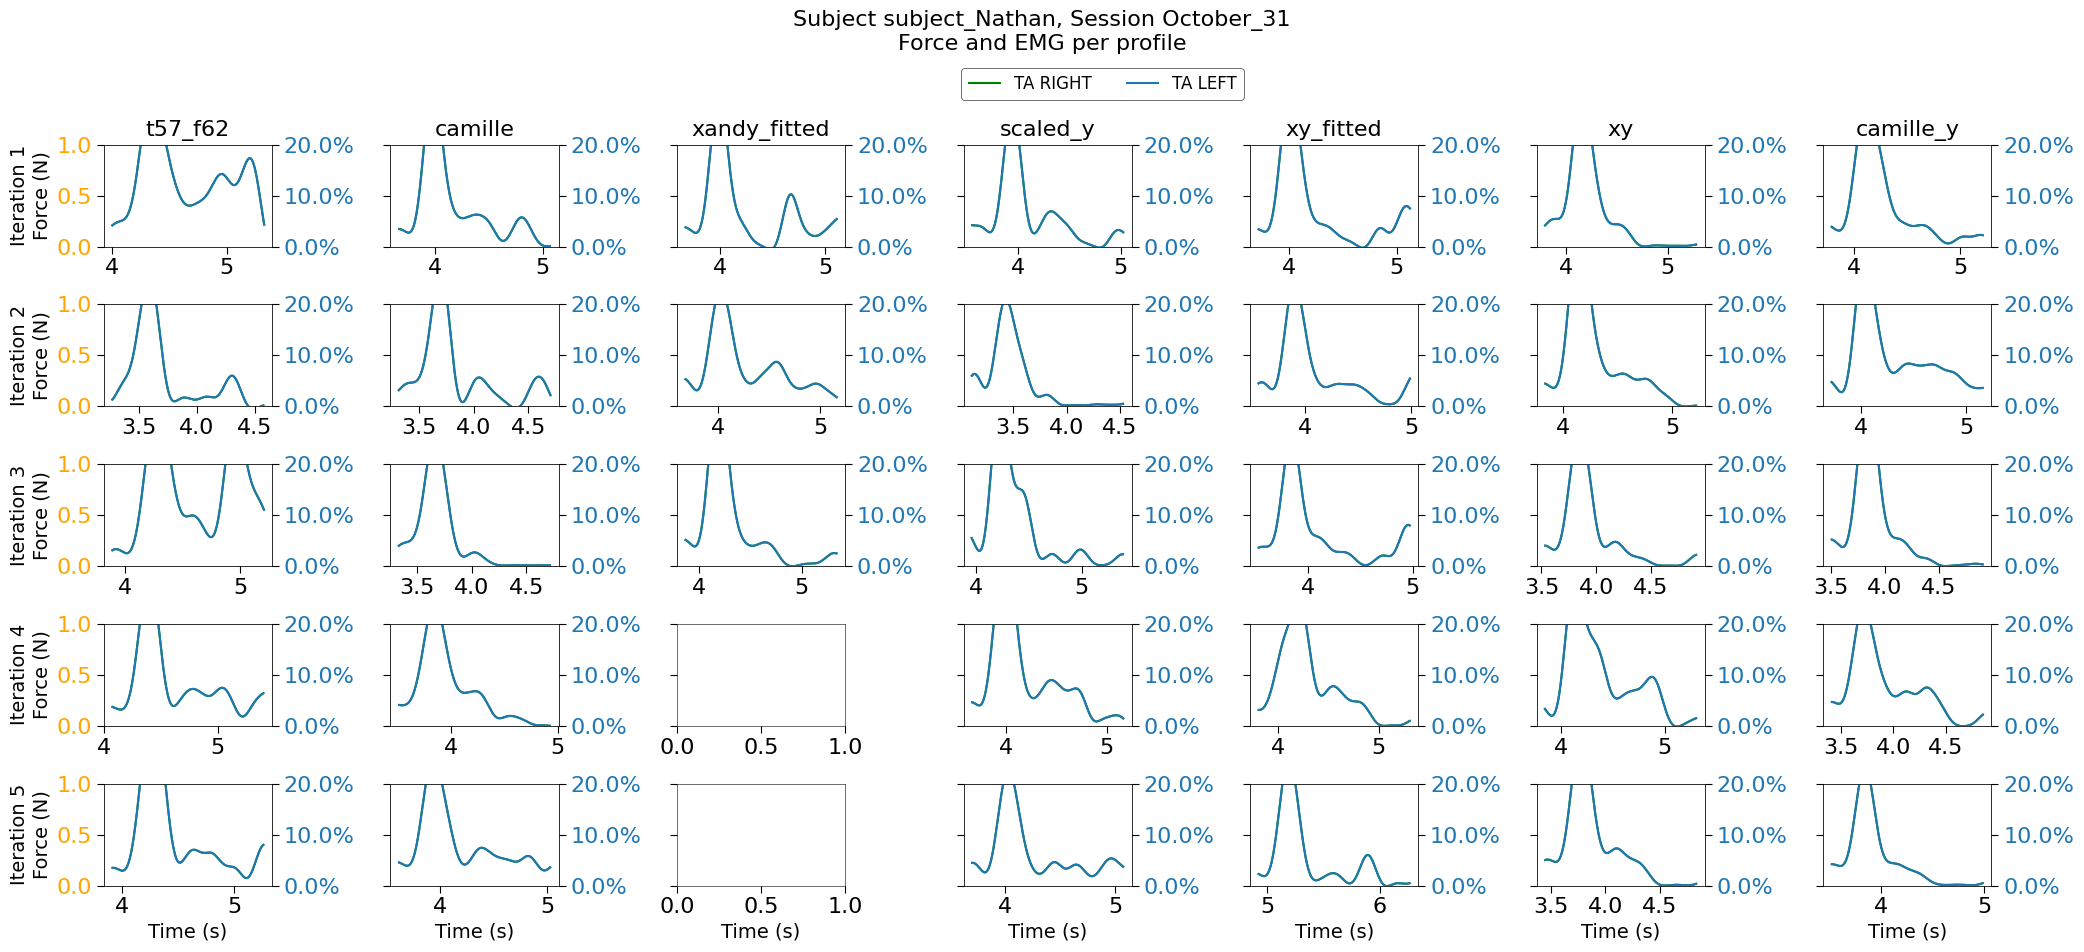

In [318]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        for target_muscle in unique_muscles:
            n_rows = 5
            n_cols = len(filtered_session_data["ASSISTED"].keys())

            plot_dir = subject_dirs[subject][session]["plot_dir"] / "force_muscle"
            filename = plot_dir / f"overview_force_muscle_crossed_{target_muscle}"

            relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges_imu"]

            fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2), sharey='row')
            fig.suptitle(f"Subject {subject}, Session {session}\nForce and EMG per profile")

            filtered_session_data = subject_data[subject][session]["filtered_session_data"]
            for i, profile in enumerate(filtered_session_data["ASSISTED"].keys()):
                words = profile.split('_')
                axs[0, i].set_title('_'.join(words[-2:]))

                
                for j, motor_df in enumerate(filtered_session_data["ASSISTED"][profile]["MOTOR_DATA"]):
                    emg_data = filtered_session_data["ASSISTED"][profile]["EMG"][j]

                    # Remove the first 3 seconds of EMG data
                    # emg_data = emg_data[emg_data.index >= 3]  # Keep data from 3 seconds onwards
                    # emg_data.index = emg_data.index - 3  # Reset index to start from 0
                    time_range = relevant_time_ranges[profile]["ranges"][j]
                    emg_data = emg_data[(emg_data.index >= time_range.min) & (emg_data.index <= time_range.max)]
                    # emg_data = emg_data[(emg_data.index >= 0.2) & (emg_data.index <= 1.9)]

                    motor_df = motor_df[(motor_df.index >= time_range.min) & (motor_df.index <= time_range.max)]
                    # motor_df = motor_df[(motor_df.index >= 0.2) & (motor_df.index <= 1.9)]

                    # Plot force values on the primary y-axis
                    # axs[j, i].plot(motor_df.index, motor_df.F_Y, label=r"$F_Y$", color='orange')
                    # axs[j, i].plot(motor_df.index, motor_df.F_X, label=r"$F_X$", color='red')
                    axs[j, i].tick_params(axis='y', labelcolor='orange')

                    # Create a secondary y-axis for EMG data
                    ax2 = axs[j, i].twinx()
                    ax2.plot(emg_data.index, emg_data[f"{target_muscle}_RIGHT"], label=f"{target_muscle} RIGHT", color='green')
                    ax2.plot(emg_data.index, emg_data[f"{target_muscle}_LEFT"], label=f"{target_muscle} LEFT", color=u'#1f77b4')
                    ax2.set_ylim(0, 0.2)  # Set EMG activation scale from 0 to 1

                    if i == len(profiles) - 1:
                        ax2.set_ylabel('EMG (% MVIC)', color=u'#1f77b4')
                    ax2.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
                    ax2.tick_params(axis='y', labelcolor=u'#1f77b4')

                    handles1, labels1 = axs[j, i].get_legend_handles_labels()
                    handles2, labels2 = ax2.get_legend_handles_labels()
                    handles = handles1 + handles2
                    labels = labels1 + labels2

                    axs[j, 0].set_ylabel(f"Iteration {j+1}\nForce (N)")
                    axs[-1, i].set_xlabel("Time (s)")

            fig.legend(handles, labels, loc="upper right", ncols=len(handles), bbox_to_anchor=(0.6, 0.93))
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.savefig(filename, dpi=500, format='svg')
            plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
            shutil.copy(filename.with_suffix('.png'), latex_figure_dir / "emg_plots")
            plt.show()

NameError: name 'profiles' is not defined

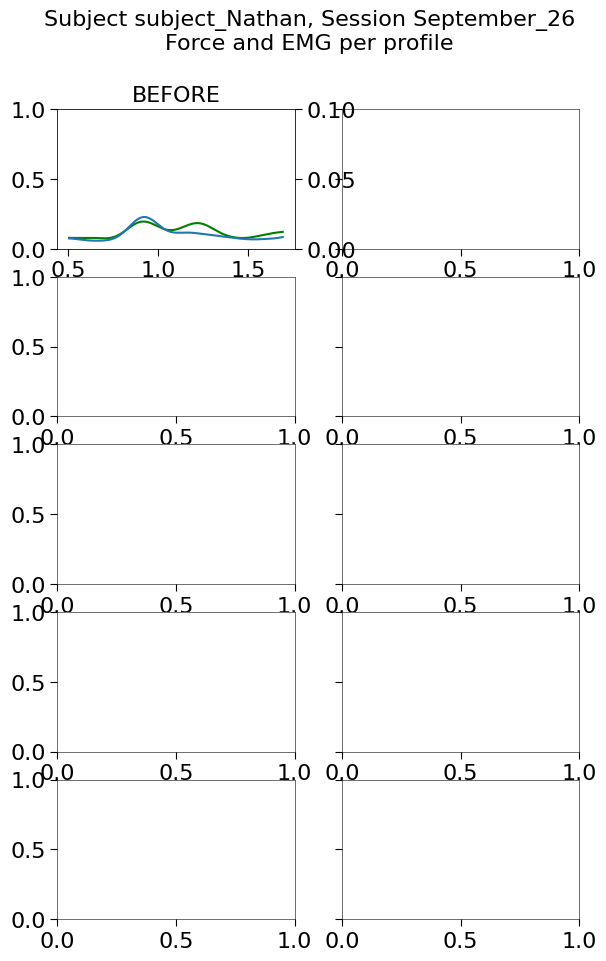

In [27]:
# same for unpowered data
subject = "subject_Nathan"
session = "September_26"
t_unpowered = "BEFORE"

filtered_session_data = subject_data[subject][session]["filtered_session_data"]

n_rows = len(filtered_session_data["UNPOWERED"][t_unpowered]["MOTOR_DATA"])
n_cols = len(filtered_session_data["UNPOWERED"].keys())

target_muscle = "G"

plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = plot_dir / f"overview_force_muscle_unpowered_{target_muscle}.svg"

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2), sharey='row')
fig.suptitle(f"Subject {subject}, Session {session}\nForce and EMG per profile")

for i, profile in enumerate(filtered_session_data["UNPOWERED"].keys()):

    words = profile.split('_')
    axs[0, i].set_title('_'.join(words[-2:]))

    
    for j, motor_df in enumerate(filtered_session_data["UNPOWERED"][profile]["MOTOR_DATA"]):
        emg_data = filtered_session_data["UNPOWERED"][profile]["EMG"][j]

        # Remove the first 3 seconds of EMG data
        emg_data = emg_data[emg_data.index >= 3]  # Keep data from 3 seconds onwards
        emg_data.index = emg_data.index - 3  # Reset index to start from 0
        # time_range = relevant_time_ranges[profile]["ranges"][j]
        # emg_data = emg_data[(emg_data.index >= time_range.min) & (emg_data.index <= time_range.max)]
        emg_data = emg_data[(emg_data.index >= 0.5) & (emg_data.index <= 1.7)]

        # motor_df = motor_df[(motor_df.index >= time_range.min) & (motor_df.index <= time_range.max)]
        motor_df = motor_df[(motor_df.index >= 0.5) & (motor_df.index <= 1.7)]

        # Plot force values on the primary y-axis
        # axs[j, i].plot(motor_df.index, motor_df.F_Y, label=r"$F_Y$", color='orange')
        # axs[j, i].tick_params(axis='y', labelcolor='orange')

        # Create a secondary y-axis for EMG data
        ax2 = axs[j, i].twinx()
        ax2.plot(emg_data.index, emg_data[f"{target_muscle}_RIGHT"], label=f"{target_muscle} RIGHT", color='green')
        ax2.plot(emg_data.index, emg_data[f"{target_muscle}_LEFT"], label=f"{target_muscle} LEFT", color=u'#1f77b4')
        ax2.set_ylim(0, 0.1)  # Set EMG activation scale from 0 to 1

        if i == len(profiles) - 1:
            ax2.set_ylabel('EMG (% MVIC)', color=u'#1f77b4')
        ax2.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
        ax2.tick_params(axis='y', labelcolor=u'#1f77b4')

        handles1, labels1 = axs[j, i].get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles = handles1 + handles2
        labels = labels1 + labels2

        axs[j, 0].set_ylabel(f"Iteration {j+1}\nForce (N)")
        axs[-1, i].set_xlabel("Time (s)")

fig.legend(handles, labels, loc="upper right", ncols=len(handles), bbox_to_anchor=(0.6, 0.93))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(filename, dpi=500, format='svg')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
shutil.copy(filename.with_suffix('.png'), latex_figure_dir / "emg_plots")
plt.show()

In [ ]:
subject_data.pop("XABI", None)

for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        filtered_session_data = subject_data[subject][session]["filtered_session_data"] 
        relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges"]

        data_to_keep = subject_data[subject][session]["data_to_keep"]

        for profile in filtered_session_data["ASSISTED"].keys():
            filtered_session_data["ASSISTED"][profile]["EMG"] = [filtered_session_data["ASSISTED"][profile]["EMG"][i] for i in data_to_keep[profile]]
            filtered_session_data["ASSISTED"][profile]["MOTOR_DATA"] = [filtered_session_data["ASSISTED"][profile]["MOTOR_DATA"][i] for i in data_to_keep[profile]]
            filtered_session_data["ASSISTED"][profile]["MARKER_DATA"] = [filtered_session_data["ASSISTED"][profile]["MARKER_DATA"][i] for i in data_to_keep[profile]]

            # Update ranges as well
            relevant_time_ranges[profile]["ranges"] = [relevant_time_ranges[profile]["ranges"][i] for i in data_to_keep[profile]]
            relevant_time_ranges[profile]["hip_vel"] = [relevant_time_ranges[profile]["hip_vel"][i] for i in data_to_keep[profile]]

            assert len(filtered_session_data["ASSISTED"][profile]["EMG"]) == len(filtered_session_data["ASSISTED"][profile]["MOTOR_DATA"]) == len(filtered_session_data["ASSISTED"][profile]["MARKER_DATA"])

### Delete specific muscles

In [ ]:
muscles_to_remove = ["VM_LEFT", "VM_RIGHT"]

if False:
    for subject in subject_data.keys():
        for session in subject_data[subject].keys():
            filtered_session_data = subject_data[subject][session]["filtered_session_data"]

            for profile in filtered_session_data["ASSISTED"].keys():
                for emg_df in filtered_session_data["ASSISTED"][profile]["EMG"]:
                    emg_df.drop(columns=muscles_to_remove, inplace=True, errors="ignore")
            for t_unpowered in filtered_session_data["UNPOWERED"].keys():
                for emg_df in filtered_session_data["UNPOWERED"][t_unpowered]["EMG"]:
                    emg_df.drop(columns=muscles_to_remove, inplace=True, errors="ignore")
            for side in filtered_session_data["MVIC"].values():
                side.drop(columns=muscles_to_remove, inplace=True, errors="ignore")

### Full data corresponding to 1 iteration per profile

In [ ]:
n_prof = len([profile for profile in relevant_time_ranges.keys() if 'unpowered' not in profile.lower()])

plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = plot_dir / f"full_data_overview.svg"
target_muscle = "BF"

fig, axs = plt.subplots(nrows=4, ncols=n_prof, sharex='col', figsize=(20, 5))
fig.suptitle("Overview of subject relevant data\nBeginning and end of iteration highlighted")

for i, (profile, range_list) in enumerate(relevant_time_ranges.items()):
    colors = iter(rcParams['axes.prop_cycle'].by_key()['color'])

    if profile.startswith("UNPOWERED"):
        continue

    df_index = 1

    rel_range = range_list["ranges"][df_index] # Get first iteration range

    marker_data = filtered_session_data["ASSISTED"][profile]["MARKER_DATA"][df_index] 
    motor_data = filtered_session_data["ASSISTED"][profile]["MOTOR_DATA"][df_index]
    emg_data = filtered_session_data["ASSISTED"][profile]["EMG"][df_index]
    
    axs[0, i].set_title(profile_names_paper[profile])
    axs[0, i].plot(marker_data.index, marker_data["Hip Left Z"], label='Hip Z', color=colors.__next__())
    axs[0, 0].set_ylabel("Hip Z (m)")
    axs[0, i].axvline(rel_range.min, linestyle='--', color="red")
    axs[0, i].axvline(rel_range.max, linestyle='--', color="red")

    axs[1, i].plot(motor_data.index, motor_data["theta_2"], label=r"$\theta_2$", color=colors.__next__())
    axs[1, 0].set_ylabel(r"$\theta_2$ (rad)")
    axs[1, i].axvline(rel_range.min, linestyle='--', color="red")
    axs[1, i].axvline(rel_range.max, linestyle='--', color="red")

    ax2 = axs[1, i].twinx()
    ax2.set_ylim(0, 100)
    ax2.plot(motor_data.index, motor_data.Percentage, label="STS %", color='g', linestyle='--')
    if i == n_prof - 1:
        ax2.set_ylabel('STS %', color='g')
    ax2.tick_params(axis='y', labelcolor='g')

    axs[2, i].plot(motor_data.index, motor_data["F_Y"], label=r"$F_Y$", color=colors.__next__())
    axs[2, 0].set_ylabel(r"$F_Y$ (N)")
    axs[2, i].axvline(rel_range.min, linestyle='--', color="red")
    axs[2, i].axvline(rel_range.max, linestyle='--', color="red")

    axs[3, i].plot(emg_data.index, emg_data[f"{target_muscle}_LEFT"], label=f"{target_muscle} LEFT", color=colors.__next__())
    axs[3, i].plot(emg_data.index, emg_data[f"{target_muscle}_RIGHT"], label=f"{target_muscle} RIGHT", color=colors.__next__())

    axs[3, i].set_xlabel("Time (s)")
    axs[3, 0].set_ylabel("EMG\n(% of MVIC)")
    axs[3, i].axvline(rel_range.min, linestyle='--', color="red")
    axs[3, i].axvline(rel_range.max, linestyle='--', color="red")

    axs[3, i].axvline(rel_range.min, linestyle='--', color="red")
    axs[3, i].axvline(rel_range.max, linestyle='--', color="red")
    
    # Get the bottom y-limit of the plot for positioning the text
    y_text_position = axs[3, i].get_ylim()[0]
    # A little padding from the bottom edge
    padding = (axs[3, i].get_ylim()[1] - y_text_position) * 0.02

    axs[3, i].text(rel_range.min, y_text_position - padding, r'$t_0$', ha='center', va='top', color="red")
    axs[3, i].text(rel_range.max, y_text_position - padding, r'$t_f$', ha='center', va='top', color="red")
    
    axs[3, i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=0, symbol=None))


plt.savefig(filename, dpi=500, format='svg')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
plt.savefig(latex_figure_dir / "emg_plots" / filename.with_suffix('.png').name, dpi=500, format="png")
plt.tight_layout()

In [ ]:
profile = "peak_27%_62N"
ranges = relevant_time_ranges[profile]["ranges"]

fig, axs = plt.subplots(3, len(ranges), figsize=(15, 5), sharex='col', sharey='row')
fig.suptitle(f"Profile {profile_names_paper[profile]}")

target_muscle = "BF"

plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = plot_dir / f"discretising_STS_overview_BF.svg"

for i, (emg_df, motor_df, marker_df) in enumerate(zip(*filtered_session_data["ASSISTED"][profile].values())):
    cur_range = ranges[i]

    colors = iter(rcParams['axes.prop_cycle'].by_key()['color'])

    axs[0, i].set_title(f"Iteration {i+1}")

    axs[0, i].plot(marker_df.index, marker_df["Hip Left Z"], label="Hip Z", color=colors.__next__())
    axs[0, i].axvline(cur_range.min, linestyle='--', color="red")
    axs[0, i].axvline(cur_range.max, linestyle='--', color="red")
    axs[0, 0].set_ylabel(f"MARKER DATA\nHip Z (m)")

    hip_vel = relevant_time_ranges[profile]['hip_vel'][i]
    ax1 = axs[0, i].twinx() 
    ax1_color = colors.__next__()
    ax1.plot(hip_vel.index, hip_vel, label="Hip Vel", color=ax1_color)
    if i == len(ranges) - 1:
        ax1.set_ylabel("Hip Vel (m/s)")
    ax1.tick_params(axis='y', labelcolor=ax1_color)
    ax1.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

    axs[1, i].plot(motor_df.index, motor_df["F_Y"], label=f"$F_Y$", color=colors.__next__())
    axs[1, 0].set_ylabel(f"MOTOR DATA\n$F_Y (N)$")
    axs[1, i].axvline(cur_range.min, linestyle='--', color="red")
    axs[1, i].axvline(cur_range.max, linestyle='--', color="red")
    
    ax2 = axs[1, i].twinx()
    ax2_color = colors.__next__()
    ax2.plot(motor_df.index, motor_df["Percentage"], label="STS %", color=ax2_color, linestyle='--')
    if i == len(ranges) - 1:
        ax2.set_ylabel('STS %')
    ax2.tick_params(axis='y', labelcolor=ax2_color)
    ax2.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100))
    ax2.set_ylim(0, 100)

    axs[2, i].plot(emg_df.index, emg_df[f"{target_muscle}_LEFT"], label=f"{target_muscle} LEFT", color=colors.__next__(), linewidth=3)
    axs[2, i].plot(emg_df.index, emg_df[f"{target_muscle}_RIGHT"], label=f"{target_muscle} RIGHT", color=colors.__next__())
    axs[2, i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
    axs[2, i].axvline(cur_range.min, linestyle='--', color="red")
    axs[2, i].axvline(cur_range.max, linestyle='--', color="red")
    axs[2, 0].set_ylabel("EMG DATA\n(% of MVIC)")
    axs[2, i].set_xlabel("Time (s)")

    handles0, labels0 = axs[0, i].get_legend_handles_labels()
    handles1, labels1 = axs[1, i].get_legend_handles_labels()
    handles2, labels2 = axs[2, i].get_legend_handles_labels()
    handles3, labels3 = ax1.get_legend_handles_labels()
    handles4, labels4 = ax2.get_legend_handles_labels()

    handles = handles0 + handles1 + handles2 + handles3 + handles4
    labels = labels0 + labels1 + labels2 + labels3 + labels4

    y_text_position = axs[2, i].get_ylim()[0]
    # A little padding from the bottom edge
    padding = (axs[2, i].get_ylim()[1] - y_text_position) * 0.02

    axs[2, i].text(cur_range.min, y_text_position - padding, r'$t_0$', ha='center', va='top', color="red")
    axs[2, i].text(cur_range.max, y_text_position - padding, r'$t_f$', ha='center', va='top', color="red")
    
    axs[2, i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, symbol=None, decimals=0))
    axs[2, i].set_ylim(0, 0.6)

fig.legend(handles, labels, loc="upper center", ncol=len(labels), bbox_to_anchor=(0.5, 0.95))
plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.savefig(filename, dpi=500, format='svg')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
plt.savefig(latex_figure_dir / "emg_plots" / filename.with_suffix('.png').name, dpi=500, format="png")
plt.show()

### Trim all dataframes based on relevant TIME window

In [ ]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]
        relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges"]

        trimmed_time_dfs = {"ASSISTED": dict(), "UNPOWERED": dict()}

        for profile in filtered_session_data["ASSISTED"].keys():
            rel_ranges = relevant_time_ranges[profile]["ranges"] # Get first iteration range
            trimmed_time_dfs["ASSISTED"][profile] = deepcopy(data_dict)

            emg_dfs, motor_dfs, marker_dfs = filtered_session_data["ASSISTED"][profile].values()


            trimmed_time_dfs["ASSISTED"][profile]["EMG"] = [emg_df.loc[rel_range.min:rel_range.max] for emg_df, rel_range in zip(emg_dfs, rel_ranges)]
            trimmed_time_dfs["ASSISTED"][profile]["MOTOR_DATA"] = [motor_df.loc[rel_range.min:rel_range.max] for motor_df, rel_range in zip(motor_dfs, rel_ranges)]
            trimmed_time_dfs["ASSISTED"][profile]["MARKER_DATA"] = [marker_df.loc[rel_range.min:rel_range.max] for marker_df, rel_range in zip(marker_dfs, rel_ranges)]

            for motor_df, rel_range in zip(motor_dfs, rel_ranges):
                if rel_range.min > motor_df.index[-1]:
                    print("Warning: cut-off range starts after motor data. Keeping whole range")
                    rel_range = rel_range._replace(min=motor_df.index[0])
                # trimmed_time_dfs["ASSISTED"][profile]["MOTOR_DATA"].append(motor_df.loc[rel_range.min:rel_range.max])

        for t_unpowered in filtered_session_data["UNPOWERED"].keys():
            rel_ranges = relevant_time_ranges[f"UNPOWERED_{t_unpowered}"]["ranges"] # Get first iteration range

            trimmed_time_dfs["UNPOWERED"][t_unpowered] = deepcopy(data_dict)

            emg_dfs, motor_dfs, marker_dfs = filtered_session_data["UNPOWERED"][t_unpowered].values()

            trimmed_time_dfs["UNPOWERED"][t_unpowered]["EMG"] = [emg_df.loc[rel_range.min:rel_range.max] for emg_df, rel_range in zip(emg_dfs, rel_ranges)]
            trimmed_time_dfs["UNPOWERED"][t_unpowered]["MARKER_DATA"] = [marker_df.loc[rel_range.min:rel_range.max] for marker_df, rel_range in zip(marker_dfs, rel_ranges)]
            trimmed_time_dfs["UNPOWERED"][t_unpowered]["MOTOR_DATA"] = [motor_df.loc[rel_range.min:rel_range.max] for motor_df, rel_range in zip(motor_dfs, rel_ranges)]
        
        subject_data[subject][session]["trimmed_time_dfs"] = trimmed_time_dfs

## Discretize STS from time to phase percentage

In [ ]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        trimmed_time_dfs = subject_data[subject][session]["trimmed_time_dfs"]

        for profile in trimmed_time_dfs["ASSISTED"].keys():
            emg, motor, marker = trimmed_time_dfs["ASSISTED"][profile].values()

            for i in range(len(emg)):
                emg[i].reset_index(inplace=True)
                motor[i].reset_index(inplace=True)
                marker[i].reset_index(inplace=True)

                emg[i].index = (emg[i].index - emg[i].index.min())/(emg[i].index.max() - emg[i].index.min()) * 100
                motor[i].index = (motor[i].index - motor[i].index.min())/(motor[i].index.max() - motor[i].index.min()) * 100
                marker[i].index = (marker[i].index - marker[i].index.min())/(marker[i].index.max() - marker[i].index.min()) * 100

                emg[i].set_index(emg[i].index, inplace=True)
                motor[i].set_index(motor[i].index, inplace=True)
                marker[i].set_index(marker[i].index, inplace=True)

                emg[i].index.name = "Percentage"
                motor[i].index.name = "Percentage"
                marker[i].index.name = "Percentage"

        for unpowered_moment in trimmed_time_dfs['UNPOWERED'].keys():
            emg, motor, marker = trimmed_time_dfs['UNPOWERED'][unpowered_moment].values()
            
            for i in range(len(emg)):
                emg[i].reset_index(inplace=True)
                motor[i].reset_index(inplace=True)
                marker[i].reset_index(inplace=True)
                
                emg[i].index = (emg[i].index - emg[i].index.min())/(emg[i].index.max() - emg[i].index.min()) * 100
                motor[i].index = (motor[i].index - motor[i].index.min())/(motor[i].index.max() - motor[i].index.min()) * 100
                marker[i].index = (marker[i].index - marker[i].index.min())/(marker[i].index.max() - marker[i].index.min()) * 100


                emg[i].set_index(emg[i].index, inplace=True)
                motor[i].set_index(motor[i].index, inplace=True)
                marker[i].set_index(marker[i].index, inplace=True)

                emg[i].index.name = "Percentage"
                motor[i].index.name = "Percentage"
                marker[i].index.name = "Percentage"

### Align force peak with peak timing percentage

In [ ]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges"]
        trimmed_time_dfs = subject_data[subject][session]["trimmed_time_dfs"]
                
        shift_motor_data = deepcopy(relevant_time_ranges)
        profile_peaks = {profile: int(profile.split("_")[1][:-1]) for profile in trimmed_time_dfs["ASSISTED"].keys()}

        for profile in trimmed_time_dfs["ASSISTED"].keys():
            for i, motor_df in enumerate(trimmed_time_dfs["ASSISTED"][profile]["MOTOR_DATA"]):
                old_range = relevant_time_ranges[profile]["ranges"][i]

                max_ind = motor_df.F_Y.argmax()
                old_peak_time = motor_df.iloc[max_ind].time

                closest_index_value = abs(motor_df.index - profile_infos[profile]["peak_time"]).argmin()
                closest_t_ind = motor_df.index[closest_index_value]
                new_peak_time = motor_df.loc[closest_t_ind].time

                shift_by = new_peak_time - old_peak_time

                new_range = time_range(old_range.min - shift_by, old_range.max - shift_by)
                shift_motor_data[profile]["ranges"][i] = new_range

        subject_data[subject][session]["time_shifted_motor_ranges"] = shift_motor_data

### Reset index to account for shifting

In [ ]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]
        relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges"]
        time_shifted_motor_ranges = subject_data[subject][session]["time_shifted_motor_ranges"]

        trimmed_time_dfs = {"ASSISTED": dict(), "UNPOWERED": dict()}

        for profile in filtered_session_data["ASSISTED"].keys():
            rel_ranges = relevant_time_ranges[profile]["ranges"] # Get first iteration range
            motor_ranges = time_shifted_motor_ranges[profile]["ranges"]
            trimmed_time_dfs["ASSISTED"][profile] = deepcopy(data_dict)

            emg_dfs, motor_dfs, marker_dfs = filtered_session_data["ASSISTED"][profile].values()

            trimmed_time_dfs["ASSISTED"][profile]["EMG"] = [emg_df.loc[rel_range.min:rel_range.max] for emg_df, rel_range in zip(emg_dfs, rel_ranges)]
            trimmed_time_dfs["ASSISTED"][profile]["MOTOR_DATA"] = [motor_df.loc[rel_range.min:rel_range.max] for motor_df, rel_range in zip(motor_dfs, motor_ranges)]
            trimmed_time_dfs["ASSISTED"][profile]["MARKER_DATA"] = [marker_df.loc[rel_range.min:rel_range.max] for marker_df, rel_range in zip(marker_dfs, rel_ranges)]

            for motor_df, rel_range in zip(motor_dfs, rel_ranges):
                if rel_range.min > motor_df.index[-1]:
                    print("Warning: cut-off range starts after motor data. Keeping whole range")
                    rel_range = rel_range._replace(min=motor_df.index[0])
                # trimmed_time_dfs["ASSISTED"][profile]["MOTOR_DATA"].append(motor_df.loc[rel_range.min:rel_range.max])

        for t_unpowered in filtered_session_data["UNPOWERED"].keys():
            rel_ranges = relevant_time_ranges[f"UNPOWERED_{t_unpowered}"]["ranges"] # Get first iteration range

            trimmed_time_dfs["UNPOWERED"][t_unpowered] = deepcopy(data_dict)

            emg_dfs, motor_dfs, marker_dfs = filtered_session_data["UNPOWERED"][t_unpowered].values()

            trimmed_time_dfs["UNPOWERED"][t_unpowered]["EMG"] = [emg_df.loc[rel_range.min:rel_range.max] for emg_df, rel_range in zip(emg_dfs, rel_ranges)]
            trimmed_time_dfs["UNPOWERED"][t_unpowered]["MARKER_DATA"] = [marker_df.loc[rel_range.min:rel_range.max] for marker_df, rel_range in zip(marker_dfs, rel_ranges)]
            trimmed_time_dfs["UNPOWERED"][t_unpowered]["MOTOR_DATA"] = [motor_df.loc[rel_range.min:rel_range.max] for motor_df, rel_range in zip(motor_dfs, rel_ranges)]
        
        subject_data[subject][session]["trimmed_time_dfs"] = trimmed_time_dfs

In [ ]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        trimmed_time_dfs = subject_data[subject][session]["trimmed_time_dfs"]

        for profile in trimmed_time_dfs["ASSISTED"].keys():
            emg, motor, marker = trimmed_time_dfs["ASSISTED"][profile].values()

            for i in range(len(emg)):
                emg[i].reset_index(inplace=True)
                motor[i].reset_index(inplace=True)
                marker[i].reset_index(inplace=True)

                emg[i].index = (emg[i].index - emg[i].index.min())/(emg[i].index.max() - emg[i].index.min()) * 100
                motor[i].index = (motor[i].index - motor[i].index.min())/(motor[i].index.max() - motor[i].index.min()) * 100
                marker[i].index = (marker[i].index - marker[i].index.min())/(marker[i].index.max() - marker[i].index.min()) * 100

                emg[i].set_index(emg[i].index, inplace=True)
                motor[i].set_index(motor[i].index, inplace=True)
                marker[i].set_index(marker[i].index, inplace=True)

                emg[i].index.name = "Percentage"
                motor[i].index.name = "Percentage"
                marker[i].index.name = "Percentage"

        for unpowered_moment in trimmed_time_dfs['UNPOWERED'].keys():
            emg, motor, marker = trimmed_time_dfs['UNPOWERED'][unpowered_moment].values()
            
            for i in range(len(emg)):
                emg[i].reset_index(inplace=True)
                motor[i].reset_index(inplace=True)
                marker[i].reset_index(inplace=True)
                
                emg[i].index = (emg[i].index - emg[i].index.min())/(emg[i].index.max() - emg[i].index.min()) * 100
                motor[i].index = (motor[i].index - motor[i].index.min())/(motor[i].index.max() - motor[i].index.min()) * 100
                marker[i].index = (marker[i].index - marker[i].index.min())/(marker[i].index.max() - marker[i].index.min()) * 100


                emg[i].set_index(emg[i].index, inplace=True)
                motor[i].set_index(motor[i].index, inplace=True)
                marker[i].set_index(marker[i].index, inplace=True)

                emg[i].index.name = "Percentage"
                motor[i].index.name = "Percentage"
                marker[i].index.name = "Percentage"

### Plotting the time-shifted data

In [ ]:
subject = "MIH02"
session = "December_20"

trimmed_time_dfs = subject_data[subject][session]["trimmed_time_dfs"]
unique_muscles = get_unique_muscles(subject_data[subject][session]["filtered_session_data"])

profiles = trimmed_time_dfs["ASSISTED"].keys()

n_rows = len(trimmed_time_dfs["ASSISTED"]["peak_77%_62N"]["MOTOR_DATA"])
n_cols = len(profiles)

target_muscle = "BF"

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 7), sharex=True, sharey='row')  # Adjust as needed
fig.suptitle(f"{subject}\nAssisted activations for {target_muscle}\n")

plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = plot_dir / f"motor_emg_{target_muscle}_assisted.svg"

for col, profile in enumerate(profiles):
    for row in range(len(trimmed_time_dfs["ASSISTED"][profile]["MARKER_DATA"])):
        motor_df = trimmed_time_dfs["ASSISTED"][profile]["MOTOR_DATA"][row]  # Adjusted for demonstration
        emg_df = trimmed_time_dfs["ASSISTED"][profile]["EMG"][row]  # Adjusted for demonstration
        cur_range = relevant_time_ranges[profile]["ranges"][row]  # Assuming relevant_time_ranges is structured similarly
        hip_vel = relevant_time_ranges[profile]["hip_vel"][row]  # Assuming relevant_time_ranges is structured similarly

        axs[row, col].plot(motor_df.index, motor_df.F_Y, label=r"$F_Y$", color="g")
        axs[row, col].set_ylim(0, 70)
        axs[row, col].tick_params(axis='y', labelcolor='g')

        ax2 = axs[row, col].twinx()
        ax2.plot(emg_df.index, emg_df[f"{target_muscle}_LEFT"], label="LEFT")
        ax2.plot(emg_df.index, emg_df[f"{target_muscle}_RIGHT"], label="RIGHT")
        ax2.set_yticklabels('')
        if col == n_cols - 1:
            # Add N to the right y-axis
            ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))

        if col == len(profiles) - 1:
            ax2.set_ylabel("EMG (% MVIC)")
        ax2.set_ylim(0, 1)  # Set EMG activation scale from 0 to 1

        handles1, labels1 = axs[row, col].get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles = handles1 + handles2
        labels = labels1 + labels2

        axs[row, 0].set_ylabel(f"Iteration {row+1}\nForce (N)")
        axs[-1, col].set_xlabel("STS (%")

        axs[0, col].set_title(profile_names_paper[profile], fontsize=16)

fig.legend(handles, labels, loc="upper center", ncol=len(handles), bbox_to_anchor=(0.5, 0.9))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(filename, dpi=500, format='svg')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
plt.savefig(latex_figure_dir / "emg_plots" / filename.with_suffix('.png').name, dpi=500, format="png")
plt.show()

## Extract metrics from EMG data

## Extract metrics from EMG data

### Average activation signals across trials

#### Equalize length of MOTOR and EMG data across iterations

In [ ]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        trimmed_time_dfs = subject_data[subject][session]["trimmed_time_dfs"]        

        interpolated_dfs = deepcopy(trimmed_time_dfs)

        for profile in trimmed_time_dfs["ASSISTED"].keys():
            emg, motor, marker = trimmed_time_dfs["ASSISTED"][profile].values()

            emg_len = min([len(emg_df) for emg_df in emg])
            motor_len = min([len(motor_df) for motor_df in motor])
            marker_len = min([len(marker_df) for marker_df in marker])

            for i in range(len(emg)):
                interpolated_dfs["ASSISTED"][profile]["EMG"][i] = interpolate_dataframe_to_length(emg[i], emg_len)
                interpolated_dfs["ASSISTED"][profile]["MOTOR_DATA"][i] = interpolate_dataframe_to_length(motor[i], motor_len)
                interpolated_dfs["ASSISTED"][profile]["MARKER_DATA"][i] = interpolate_dataframe_to_length(marker[i], marker_len)
                
        for unpowered_time in trimmed_time_dfs["UNPOWERED"].keys():
            emg, motor, marker = trimmed_time_dfs["UNPOWERED"][unpowered_time].values()

            emg_len = min([len(emg_df) for emg_df in emg])
            motor_len = min([len(motor_df) for motor_df in motor])
            marker_len = min([len(marker_df) for marker_df in marker])

            for i in range(len(emg)):
                interpolated_dfs["UNPOWERED"][unpowered_time]["EMG"][i] = interpolate_dataframe_to_length(emg[i], emg_len)
                interpolated_dfs["UNPOWERED"][unpowered_time]["MOTOR_DATA"][i] = interpolate_dataframe_to_length(motor[i], motor_len)
                interpolated_dfs["UNPOWERED"][unpowered_time]["MARKER_DATA"][i] = interpolate_dataframe_to_length(marker[i], marker_len)
        
        subject_data[subject][session]["interpolated_dfs"] = interpolated_dfs

### Average activations and motor data

In [ ]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        trimmed_time_dfs = subject_data[subject][session]["trimmed_time_dfs"]

        interpolated_dfs = deepcopy(trimmed_time_dfs)

        # Initialize variables to store the minimum lengths for each type of data
        min_emg_len = float('inf')
        min_motor_len = float('inf')
        min_marker_len = float('inf')

        # Step 1: Identify the Minimum Lengths across all "ASSISTED" profiles
        for profile in trimmed_time_dfs["ASSISTED"].keys():
            emg, motor, marker = trimmed_time_dfs["ASSISTED"][profile].values()

            min_emg_len = min(min_emg_len, min([len(emg_df) for emg_df in emg]))
            min_motor_len = min(min_motor_len, min([len(motor_df) for motor_df in motor]))
            min_marker_len = min(min_marker_len, min([len(marker_df) for marker_df in marker]))

        # Step 2: Apply Interpolation to "ASSISTED"
        for profile in trimmed_time_dfs["ASSISTED"].keys():
            emg, motor, marker = trimmed_time_dfs["ASSISTED"][profile].values()

            for i in range(len(emg)):
                interpolated_dfs["ASSISTED"][profile]["EMG"][i] = interpolate_dataframe_to_length(emg[i], min_emg_len)
            for i in range(len(motor)):
                interpolated_dfs["ASSISTED"][profile]["MOTOR_DATA"][i] = interpolate_dataframe_to_length(motor[i], min_motor_len)
            for i in range(len(marker)):
                interpolated_dfs["ASSISTED"][profile]["MARKER_DATA"][i] = interpolate_dataframe_to_length(marker[i], min_marker_len)

        # Step 3: Apply the Same Interpolation to "UNPOWERED"
        for unpowered_time in trimmed_time_dfs["UNPOWERED"].keys():
            emg, motor, marker = trimmed_time_dfs["UNPOWERED"][unpowered_time].values()

            for i in range(len(emg)):
                interpolated_dfs["UNPOWERED"][unpowered_time]["EMG"][i] = interpolate_dataframe_to_length(emg[i], min_emg_len)
            for i in range(len(motor)):
                interpolated_dfs["UNPOWERED"][unpowered_time]["MOTOR_DATA"][i] = interpolate_dataframe_to_length(motor[i], min_motor_len)
            for i in range(len(marker)):
                interpolated_dfs["UNPOWERED"][unpowered_time]["MARKER_DATA"][i] = interpolate_dataframe_to_length(marker[i], min_marker_len)
        
        subject_data[subject][session]["interpolated_dfs"] = interpolated_dfs

In [ ]:
# Drop time column
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        interpolated_dfs = subject_data[subject][session]["interpolated_dfs"]
        for profile in interpolated_dfs["ASSISTED"].keys():
            for emg_df, motor_df, marker_df in zip(*interpolated_dfs["ASSISTED"][profile].values()):
                emg_df.drop(columns="TIME", inplace=True, errors='ignore')
                marker_df.drop(columns="TIME", inplace=True, errors='ignore')

        for unpowered_time in interpolated_dfs["UNPOWERED"].keys():
            for emg_df, motor_df, marker_df in zip(*interpolated_dfs["UNPOWERED"][unpowered_time].values()):
                emg_df.drop(columns="TIME", inplace=True, errors='ignore')
                marker_df.drop(columns="TIME", inplace=True, errors='ignore')

In [ ]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        interpolated_dfs = subject_data[subject][session]["interpolated_dfs"]
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]
                
        average_profile_dfs = {"ASSISTED": {}, "UNPOWERED": {}}
        muscles = interpolated_dfs["UNPOWERED"]["BEFORE"]["EMG"][0].columns

        motor_assisted_columns = interpolated_dfs["ASSISTED"][list(interpolated_dfs["ASSISTED"].keys())[0]]["MOTOR_DATA"][0].columns
        motor_unpowered_columns = interpolated_dfs["UNPOWERED"]["BEFORE"]["MOTOR_DATA"][0].columns

        for mode, columns in zip(["ASSISTED", "UNPOWERED"], [motor_assisted_columns, motor_unpowered_columns]):
            for profile in interpolated_dfs[mode].keys():
                average_profile_dfs[mode][profile] = {"EMG": {"mean": None, "std": None}, "MOTOR_DATA": {"mean": None, "std": None}}

                # EMG Data
                muscles_means = {}
                muscles_std = {}

                for emg in interpolated_dfs[mode][profile]["EMG"]:
                    for muscle in emg.columns:
                        if muscle not in muscles_means:
                            muscles_means[muscle] = []
                            muscles_std[muscle] = []
                        muscles_means[muscle].append(emg[muscle])
                        muscles_std[muscle].append(emg[muscle])

                for muscle, dfs in muscles_means.items():
                    merged = pd.concat(dfs, axis=1)
                    muscles_means[muscle] = merged.mean(axis=1)
                    muscles_std[muscle] = merged.std(axis=1)

                average_profile_dfs[mode][profile]["EMG"]["mean"] = smooth_dataframe(pd.DataFrame.from_dict(muscles_means), window_size=1)
                average_profile_dfs[mode][profile]["EMG"]["std"] = smooth_dataframe(pd.DataFrame.from_dict(muscles_std), window_size=1)

                # MOTOR Data
                motor_means = {}
                motor_std = {}

                for motor_data in interpolated_dfs[mode][profile]["MOTOR_DATA"]:
                    for column in columns:
                        if column not in motor_means:
                            motor_means[column] = []
                            motor_std[column] = []
                        motor_means[column].append(motor_data[column])
                        motor_std[column].append(motor_data[column])

                for column, dfs in motor_means.items():
                    merged = pd.concat(dfs, axis=1)
                    motor_means[column] = merged.mean(axis=1)
                    motor_std[column] = merged.std(axis=1)

                average_profile_dfs[mode][profile]["MOTOR_DATA"]["mean"] = smooth_dataframe(pd.DataFrame.from_dict(motor_means))
                average_profile_dfs[mode][profile]["MOTOR_DATA"]["std"] = smooth_dataframe(pd.DataFrame.from_dict(motor_std))

        average_profile_dfs["UNPOWERED"]["BASELINE"] = {"EMG": {"mean": None, "std": None}, "MOTOR_DATA": {"mean": None, "std": None}}

        if "AFTER" in filtered_session_data["UNPOWERED"].keys():
            average_profile_dfs["UNPOWERED"]["BASELINE"]["EMG"]["mean"] = (average_profile_dfs["UNPOWERED"]["BEFORE"]["EMG"]["mean"] + average_profile_dfs["UNPOWERED"]["AFTER"]["EMG"]["mean"]) / 2
            average_profile_dfs["UNPOWERED"]["BASELINE"]["EMG"]["std"] = (average_profile_dfs["UNPOWERED"]["BEFORE"]["EMG"]["std"] + average_profile_dfs["UNPOWERED"]["AFTER"]["EMG"]["std"]) / 2
        else:
            average_profile_dfs["UNPOWERED"]["BASELINE"]["EMG"]["mean"] = average_profile_dfs["UNPOWERED"]["BEFORE"]["EMG"]["mean"]
            average_profile_dfs["UNPOWERED"]["BASELINE"]["EMG"]["std"] = average_profile_dfs["UNPOWERED"]["BEFORE"]["EMG"]["std"]
        
        subject_data[subject][session]["average_profile_dfs"] = average_profile_dfs

In [ ]:
subject = "MIH02"
session = "December_20"

average_profile_dfs = subject_data[subject][session]["average_profile_dfs"]
unique_muscles = get_unique_muscles(subject_data[subject][session]["session_data"])

# Since first column is TIME we ignore it
n_muscles = len(average_profile_dfs["ASSISTED"]["peak_27%_62N"]["EMG"]["mean"].columns)

plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = plot_dir / f"full_EMG_activations_and_motor.svg"

# We add 1 because we want to include the motor data in the first row
fig, ax = plt.subplots(nrows=n_muscles + 1, ncols=n_prof, figsize=(30, 20))

if enable_paper_scaling:
    fig.suptitle(f"{subject}\nEMG activations (paper match scaling)", fontsize=30)
else:
    fig.suptitle(f"{subject}\nEMG activations (MVIC scaled)", fontsize=30)

for i, profile in enumerate(average_profile_dfs["ASSISTED"].keys()):
    force_data = average_profile_dfs["ASSISTED"][profile]["MOTOR_DATA"]

    
    closest_index_value = abs(force_data["mean"].index - profile_infos[profile]["peak_time"]).argmin()
    closest_t_ind = force_data["mean"].index[closest_index_value]

    ax[0, i].set_title(profile_names_paper[profile], fontsize=20)
    ax[0, i].plot(force_data["mean"].index, force_data["mean"].F_Y, label=r"$F_Y$", color='green')
    ax[0, i].axvline(closest_t_ind, color="red")
    ax[0, i].fill_between(force_data["mean"].index, force_data["mean"].F_Y - force_data["std"].F_Y, force_data["mean"].F_Y + force_data["std"].F_Y, alpha=0.2, color='green')
    ax[0, 0].set_ylabel('Force (N)', color='green', fontsize=16)
    ax[0, i].tick_params(axis='y', labelcolor='green', labelsize=16)
    ax[0, i].yaxis.set_major_formatter("{x:.0f}N")

    ax2 = ax[0, i].twinx()
    ax2.plot(force_data["mean"].index, force_data["mean"].Percentage/100, label="STS %", linestyle="--", color="purple")
    ax2.fill_between(force_data["mean"].index, force_data["mean"].Percentage/100 - force_data["std"].Percentage/100, force_data["mean"].Percentage/100 + force_data["std"].Percentage/100, alpha=0.2, color='purple')
    if i ==len(average_profile_dfs["ASSISTED"].keys())-1:
        ax2.set_ylabel('Measured STS %', color='purple', fontsize=16)
    ax2.tick_params(axis='y', labelcolor='purple', labelsize=16)
    ax2.xaxis.set_major_formatter(mticker.PercentFormatter())
    ax2.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
    ax2.set_ylim(0, 1)

    for j in range(1, n_muscles + 1):
        muscle = average_profile_dfs["ASSISTED"][profile]["EMG"]["mean"].columns[j-1]
        peak_time = profile_infos[profile]["peak_time"]
        
        if i == 0:
            ax[j, i].set_ylabel(f"{muscle}\nEMG (% of MVIC)", fontsize=16)

        ax[-1, i].set_xlabel("Percentage of STS", fontsize=16)

        emg_mean = average_profile_dfs["ASSISTED"][profile]["EMG"]["mean"][muscle]
        emg_std = average_profile_dfs["ASSISTED"][profile]["EMG"]["std"][muscle]

        closest_peak_index = np.abs(emg_mean.index.astype(float) - peak_time).argmin()

        emg_baseline_mean = average_profile_dfs["UNPOWERED"]["BASELINE"]["EMG"]["mean"][muscle]
        emg_baseline_std = average_profile_dfs["UNPOWERED"]["BASELINE"]["EMG"]["std"][muscle]
           

        ax[j, i].plot(emg_mean.index, emg_mean, label=f"Trials")
        ax[j, i].fill_between(emg_mean.index, emg_mean - emg_std, emg_mean + emg_std, alpha=0.2)
        ax[j, i].plot(emg_baseline_mean.index, emg_baseline_mean, label=f"Baseline")
        ax[j, i].fill_between(emg_baseline_mean.index, emg_baseline_mean - emg_baseline_std, emg_baseline_mean + emg_baseline_std, alpha=0.2)
        ax[j, i].tick_params(axis='x', labelsize=16)
        ax[j, i].tick_params(axis='y', labelsize=16)
        ax[j, i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=0))
        ax[j, i].set_ylim(0, 1)
        
        force_handles, force_labels = ax[0, i].get_legend_handles_labels()

        handles1, labels1 = ax[j, i].get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles = handles1 + handles2 + force_handles
        
        labels = labels1 + labels2 + force_labels
    
legend = fig.legend(handles, labels, loc="upper center", ncols=len(labels), fontsize=20, bbox_to_anchor=(0.5, 0.93))

for line in legend.get_lines():
    line.set_linewidth(4)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(filename, dpi=500, format='svg')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
shutil.copy(filename, latex_figure_dir / "emg_plots")
plt.show()

### Calculate mean activation delta

In [ ]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        average_profile_dfs = subject_data[subject][session]["average_profile_dfs"]      

        averaged_activations = deepcopy(average_profile_dfs)

        for profile in average_profile_dfs["ASSISTED"].keys():
            averaged_activations["ASSISTED"][profile]["EMG"]["mean"] = average_profile_dfs["ASSISTED"][profile]["EMG"]["mean"].mean()
            averaged_activations["ASSISTED"][profile]["EMG"]["std"] = average_profile_dfs["ASSISTED"][profile]["EMG"]["std"].mean()


        averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["mean"] = average_profile_dfs["UNPOWERED"]["BASELINE"]["EMG"]["mean"].mean()
        averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["std"] = average_profile_dfs["UNPOWERED"]["BASELINE"]["EMG"]["std"].mean()

        averaged_activations['UNPOWERED'].pop("BEFORE", None)
        averaged_activations['UNPOWERED'].pop("AFTER", None)

        subject_data[subject][session]["averaged_activations"] = averaged_activations

In [ ]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        averaged_activations = subject_data[subject][session]["averaged_activations"]

        n_profiles = len(averaged_activations["ASSISTED"].keys())
        muscles = averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["mean"].index
        
        muscle_deltas = []  # For storing deltas
        muscle_activations = []  # For storing activations

        for muscle in muscles:
            mean_baseline = averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["mean"][muscle]
            std_baseline = averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["std"][muscle]
            
            muscle_activations.append({"Profile": "BASELINE", "Muscle": muscle, "Mean Activation": mean_baseline, "STD Activation": std_baseline})


        for profile in profiles:
            muscle_means_delta = []  # To calculate deltas
            muscle_stds_delta = []

            muscle_means_activation = []  # To store activations
            muscle_stds_activation = []

            for muscle in muscles:
                mean_assisted = averaged_activations["ASSISTED"][profile]["EMG"]["mean"][muscle]
                std_assisted = averaged_activations["ASSISTED"][profile]["EMG"]["std"][muscle]
                
                mean_baseline = averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["mean"][muscle]
                std_baseline = averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["std"][muscle]

                # Calculate deltas
                mean_delta = (mean_assisted - mean_baseline) / mean_baseline
                std_delta = (std_assisted + std_baseline)
                
                # Append delta calculations
                muscle_means_delta.append(mean_delta)
                muscle_stds_delta.append(std_delta)
                muscle_deltas.append({"Profile": profile, "Muscle": muscle, "Mean Delta": mean_delta, "STD Delta": std_delta})
                
                # Append activations
                muscle_means_activation.append(mean_assisted)
                muscle_stds_activation.append(std_assisted)
                muscle_activations.append({"Profile": profile, "Muscle": muscle, "Mean Activation": mean_assisted, "STD Activation": std_assisted})
                
            # Append average of all muscles to each profile for deltas
            muscles_delta_df = pd.DataFrame({"means": muscle_means_delta, "stds": muscle_stds_delta}, index=muscles).mean()
            muscle_deltas.append({"Profile": profile, "Muscle": "AVERAGE", "Mean Delta": muscles_delta_df.means, "STD Delta": muscles_delta_df.stds})
            
            # Append average of all muscles to each profile for activations
            muscles_activation_df = pd.DataFrame({"means": muscle_means_activation, "stds": muscle_stds_activation}, index=muscles).mean()
            muscle_activations.append({"Profile": profile, "Muscle": "AVERAGE", "Mean Activation": muscles_activation_df.means, "STD Activation": muscles_activation_df.stds})
        
            
        # Convert the collected data into DataFrames and store them under their respective keys
        df_deltas = pd.DataFrame(muscle_deltas)
        df_activations = pd.DataFrame(muscle_activations)
        subject_data[subject][session]["mean_delta_activations"] = df_deltas
        subject_data[subject][session]["absolute_mean_activations"] = df_activations

In [ ]:
fig, axs = plt.subplots(figsize=(10, 5))
fig.suptitle(f"Mean muscle activation $\Delta$\nper subject and profile", fontsize=20)

plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = plot_dir / f"mean_delta_activations.svg"

plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = plot_dir / f"mean_delta_activations.svg"

profile_deltas = {}

for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        mean_delta_activations = subject_data[subject][session]["mean_delta_activations"]
        muscle_averages = mean_delta_activations[mean_delta_activations["Muscle"] == "AVERAGE"]
        
        muscle_averages.loc[:, "Profile"] = list(profile_peaks.values())

        axs.plot(muscle_averages["Profile"], muscle_averages["Mean Delta"], label=subject, marker='*', linewidth=3, markersize=10)

        for index, row in muscle_averages.iterrows():
            if row["Profile"] not in profile_deltas:
                profile_deltas[row["Profile"]] = []
            profile_deltas[row["Profile"]].append(row["Mean Delta"])

average_deltas = {profile: np.mean(deltas) for profile, deltas in profile_deltas.items()}
average_values = list(average_deltas.values())

axs.grid(False)
axs.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
axs.hlines(0, profile_peaks['peak_27%_62N'], profile_peaks['peak_77%_62N'], color='black', linestyle='--')
axs.set_xlabel("Peak Timing of Assistance (%)")
axs.set_xticks(list(profile_peaks.values()))
axs.set_ylabel("Muscle Activity Reduction (%)")

axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
# axs.spines['bottom'].set_visible(False)  # Adjust thickness of the arrow

# Make x-axis and y-axis arrows
axs.spines['left'].set_linewidth(2)
axs.spines['bottom'].set_linewidth(2)  # Adjust thickness of the arrow
axs.spines['bottom'].set_capstyle('projecting')  # Arrow style
offset = 0.03


axs.set_ylim(-0.4, 0.2)
axs.legend(fontsize=16, title="Subjects", title_fontsize='16', loc='upper right')

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(filename, format='svg')
plt.savefig("../paper_figures/mean_delta_activations.svg", format='svg')
plt.savefig("../paper_figures/mean_delta_activations.png", dpi=500, format='png', bbox_inches='tight')
plt.savefig(latex_figure_dir / "emg_plots" / "mean_delta_activations.png", dpi=500, format="png")
plt.show()



In [ ]:
# Plot average muscle activations per profile as a line plot
n_subjects = len(subject_data.keys())


fig, axs = plt.subplots(1, n_subjects, figsize=(20, 5), sharey=True)

for i, subject in enumerate(subject_data.keys()):
    for session in subject_data[subject].keys():
        mean_activations = subject_data[subject][session]["absolute_mean_activations"]
        mean_activations = mean_activations[mean_activations["Profile"] != "BASELINE"]
        for muscle in mean_activations.Muscle.unique():
            muscle_averages = mean_activations[mean_activations["Muscle"] == muscle]

            muscle_averages.loc[:, "Profile"] = list(profile_peaks.values())

            axs[i].plot(muscle_averages["Profile"], muscle_averages["Mean Activation"], label=muscle, marker='*', linewidth=3, markersize=10)

        axs[i].set_xticks(list(profile_peaks.values()))
        axs[i].set_title(f"Subject {subject}", fontsize=20)
        axs[i].legend(loc="upper right", fontsize=10)
        axs[i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=0))
        axs[i].set_xlabel("Peak Timing of Assistance (%)")
        axs[0].set_ylabel("Mean Activation (% of MVIC)")

plt.savefig("../paper_figures/mean_absolute_activations_per_subject.svg", format='svg')
plt.savefig("../paper_figures/mean_absolute_activations_per_subject.png", dpi=500, format='png', bbox_inches='tight')
plt.savefig(latex_figure_dir / "emg_plots" / 'mean_absolute_activations_per_subject.png', dpi=500, format="png")
plt.show()

In [ ]:
n_subjects = len(subject_data.keys())

fig, axs = plt.subplots(1, n_subjects, figsize=(20, 5), sharey=True)  # Ensure axs is 2D
# Predefined colors for specific muscles
colors = {'BASELINE': '#1f77b4', 'AVERAGE': 'orange'}

for i, subject in enumerate(subject_data.keys()):
    muscle_colors = {}  # Dictionary to dynamically assign colors to each muscle
    for session in subject_data[subject].keys():
        mean_activations = subject_data[subject][session]['absolute_mean_activations']
        mean_activations = mean_activations[mean_activations["Profile"] != "BASELINE"]
        muscles = sorted(mean_activations.Muscle.unique())
        
        # Dynamically generate grey shades based on the number of muscles
        grey_count = len([m for m in muscles if m not in colors])
        grey_values = np.linspace(0.8, 0.2, grey_count)  # Light (0.8) to dark (0.2)
        grey_counter = 0
        # Assign grey shades to muscles not in the predefined colors
        for index, muscle in enumerate(muscles):
            if muscle not in colors:
                # Use the grey_counter to access grey_values
                grey = grey_values[grey_counter]
                # Convert grey value to RGB format
                rgb_grey = (grey, grey, grey)
                muscle_colors[muscle] = rgb_grey
                # Increment the grey_counter
                grey_counter += 1
        
        # Update the colors dictionary with dynamically generated grey shades
        colors.update(muscle_colors)
        
        for muscle in muscles:
            muscle_averages = mean_activations[mean_activations["Muscle"] == muscle]
            muscle_averages.loc[:, "Profile"] = list(profile_peaks.values())
            color = colors.get(muscle)
            
            # Plot line with dynamically assigned color
            axs[i].plot(muscle_averages["Profile"], muscle_averages["Mean Activation"], 
                           label=muscle, marker='*', linewidth=3, markersize=10, color=color)
            
            # Place muscle name next to the line on the right
            if not muscle_averages.empty:
                axs[i].text(muscle_averages["Profile"].iloc[-1], muscle_averages["Mean Activation"].iloc[-1], 
                               f"  {muscle}", verticalalignment='center', color=color)

        axs[i].set_xticks(list(profile_peaks.values()))
        axs[i].set_title(f"Subject {subject}", fontsize=20)
        axs[i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=0))
        axs[i].set_xlabel("Peak Timing of Assistance (%)")
        axs[0].set_ylabel("Mean Activation\n(% of MVIC)")

# Remove the legend since muscle names are annotated on the plot
for ax in axs.flat:
    ax.legend().set_visible(False)

plt.tight_layout()
plt.savefig("../paper_figures/mean_absolute_activations_per_subject_bw.svg", format='svg')
plt.savefig("../paper_figures/mean_absolute_activations_per_subject_bw.png", dpi=500, format='png')
plt.savefig(latex_figure_dir / "emg_plots" / 'mean_absolute_activations_per_subject_bw.png', dpi=500, format="png")
plt.show()

In [ ]:
all_deltas = []
all_means = []


for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        df_delta = subject_data[subject][session]["mean_delta_activations"]
        df_means = subject_data[subject][session]["absolute_mean_activations"]
        df_baseline = subject_data[subject][session]["average_profile_dfs"]["UNPOWERED"]["BASELINE"]["EMG"]["mean"]
        
        # Ensuring each DataFrame has 'Subject' and 'Session'
        df_delta['Subject'] = subject
        df_delta['Session'] = session
        df_means['Subject'] = subject
        df_means['Session'] = session
        
        all_deltas.append(df_delta)
        all_means.append(df_means)

df_all_deltas = pd.concat(all_deltas)
df_all_means = pd.concat(all_means)

df_all_deltas.sort_values(by="Muscle", ascending=True, inplace=True)
df_all_means.sort_values(by="Muscle", ascending=True, inplace=True)

In [ ]:
# Create a figure and axis for the plot
plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = Path("../paper_figures") / f"mean_delta_activation_muscle_profile_subject.svg"

fig, ax = plt.subplots(1, n_profiles, figsize=(35, 10), sharey=True)
fig.suptitle("Average Activation $\Delta$\nacross Subjects and Muscles", fontsize=24, y=1.1)


for i, profile in enumerate(sorted(profile_infos.keys())):
    df_deltas_profile = df_all_deltas[df_all_deltas['Profile'] == profile].sort_values(by="Subject")
    df_means_profile = df_all_means[df_all_means['Profile'] == profile].sort_values(by="Subject")

    df_deltas_profile[df_deltas_profile['Muscle'] == "AVERAGE"]

    # Plotting delta activations with consideration for missing data
    sns.barplot(x="Muscle", y="Mean Delta", hue="Subject", data=df_deltas_profile, ax=ax[i], dodge=True)

    # # Adding error bars for delta activations
    ax[i].set_xlabel("Muscles", fontsize=16)
    ax[i].tick_params(axis='x', labelrotation=45, labelsize=16)
    ax[i].tick_params(axis='y', labelsize=16)
    ax[i].set_ylabel("Mean Activation $\Delta$ (%)", fontsize=20)
    ax[i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
    ax[i].set_title(profile_names_paper[profile], fontsize=24)
    ax[i].tick_params(labelleft=True)

    handles, labels = ax[i].get_legend_handles_labels()

    ax[i].get_legend().remove()

    
fig.legend(handles, labels, fontsize=20, ncols=len(handles), bbox_to_anchor=(0.56, 1.02))  
plt.tight_layout()
plt.savefig(filename, format='svg')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png', bbox_inches='tight')
plt.savefig(latex_figure_dir / "emg_plots" / filename.with_suffix('.png').name, dpi=500, format="png")
plt.show()

In [ ]:
subject = "MIH02"
session = "December_20"

df_delta = subject_data[subject][session]["mean_delta_activations"]
df_means = subject_data[subject][session]["absolute_mean_activations"]

plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = plot_dir / f"mean_delta_activation_muscle_profile_{subject}.svg"

fig, axs = plt.subplots(1, n_profiles, figsize=(30, 10))
fig.suptitle(f"Subject {subject}\nMean muscle activation $\Delta$", fontsize=20, y=1.02)

for i, profile in enumerate(profiles):
    profile_df = df_delta[df_delta["Profile"] == profile]
    sns.barplot(x="Muscle", y="Mean Delta", data=profile_df, ax=axs[i], dodge=False)
    
    # Adding error bars
    for j, muscle in enumerate(profile_df["Muscle"].unique()):
        axs[i].errorbar(j, profile_df[profile_df["Muscle"] == muscle]["Mean Delta"].values[0],
                        yerr=profile_df[profile_df["Muscle"] == muscle]["STD Delta"].values[0], 
                        fmt='none', color='gray', capsize=5, elinewidth=2)
    axs[i].set_title(profile, fontsize=14)
    axs[i].set_xlabel("Muscle", fontsize=16)
    axs[i].set_ylabel("Mean activation delta (%)", fontsize=16)
    axs[i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))

    plt.setp(axs[i].get_xticklabels(), rotation=45, ha="right")

plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust the layout to make room for the suptitle
plt.savefig(filename, format='svg')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
plt.show()

### Calculate peak activation delta

In [ ]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        n_profiles = len(averaged_activations["ASSISTED"].keys())
        muscles = averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["mean"].index
        data = []

        for profile in profiles:
            muscle_means = []
            muscle_stds = []

            for muscle in muscles:
                mean_assisted = averaged_activations["ASSISTED"][profile]["EMG"]["mean"][muscle]
                std_assisted = averaged_activations["ASSISTED"][profile]["EMG"]["std"][muscle]
                
                mean_baseline = averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["mean"][muscle]
                std_baseline = averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["std"][muscle]

                mean_delta = (mean_assisted - mean_baseline) / mean_baseline
                std_delta = (std_assisted + std_baseline) #/ std_baseline

                muscle_means.append(mean_delta)
                muscle_stds.append(std_delta)
                
                data.append({"Profile": profile, "Muscle": muscle, "Mean Delta": mean_delta, "STD Delta": std_delta})
                
            muscles_delta_df = pd.DataFrame({"means": muscle_means, "stds": muscle_stds}, index=muscles).mean()
            data.append({"Profile": profile, "Muscle": "Average", "Mean Delta": muscles_delta_df.means, "STD Delta": muscles_delta_df.stds})
            # Append average of all muscles to each profile
        df = pd.DataFrame(data)

        subject_data[subject][session]["mean_delta_activations"] = df

In [ ]:
# Calculate peak EMG values for each muscle (before and after trials)
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        trimmed_time_dfs = subject_data[subject][session]["trimmed_time_dfs"]
        muscles = subject_data[subject][session]["averaged_activations"]["ASSISTED"]["peak_77%_62N"]["EMG"]["mean"].index

        peak_emg_means = []
        
        for t_unpowered in trimmed_time_dfs["UNPOWERED"].keys():
            peak_means = [df.max() for df in trimmed_time_dfs["UNPOWERED"][t_unpowered]["EMG"]]
            peak_emg_means.append(sum(peak_means) / len(peak_means))

        peak_emg_means = sum(peak_emg_means) / len(peak_emg_means)

        # Calculate average peak EMG values for each muscle (assisted trials)
        peak_values_assisted = defaultdict(dict)
        for profile in trimmed_time_dfs["ASSISTED"].keys():
            max_values_assisted = pd.DataFrame([df.max() for df in trimmed_time_dfs["ASSISTED"][profile]["EMG"]])
            peak_values_assisted[profile]["mean"] = max_values_assisted.mean()
            peak_values_assisted[profile]["std"] = max_values_assisted.std()

        peak_activation_deltas = []

        for profile in profiles:
            peak_means = []
            peak_stds = []

            for muscle in muscles:
                peak_mean = peak_values_assisted[profile]["mean"][muscle]
                peak_std = peak_values_assisted[profile]["std"][muscle]

                peak_mean_baseline = peak_emg_means[muscle]
                peak_std_baseline = peak_emg_means[muscle]

                peak_delta = (peak_mean - peak_mean_baseline) / peak_mean_baseline
                peak_std_delta = (peak_std + peak_std_baseline)


                peak_means.append(peak_delta)
                peak_stds.append(peak_std_delta)

                peak_activation_deltas.append({"Profile": profile, "Muscle": muscle, "Mean Delta": peak_delta, "STD Delta": peak_std_delta})

            peaks_df = pd.DataFrame({"means": peak_means, "stds": peak_stds}, index=muscles).mean()
            peak_activation_deltas.append({"Profile": profile, "Muscle": "Average", "Mean Delta": peaks_df.means, "STD Delta": peaks_df.stds})

        peak_activation_deltas_df = pd.DataFrame(peak_activation_deltas)

        subject_data[subject][session]["peak_activation_deltas"] = peak_activation_deltas_df

In [ ]:
all_deltas = []
all_means = []

for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        df_delta = subject_data[subject][session]["peak_activation_deltas"]
        
        # Ensuring each DataFrame has 'Subject' and 'Session'
        df_delta['Subject'] = subject
        df_delta['Session'] = session
        
        all_deltas.append(df_delta)

df_all_deltas = pd.concat(all_deltas)

df_all_deltas.sort_values(by="Muscle", ascending=True, inplace=True)

In [ ]:
# Create a figure and axis for the plot
plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = Path("../paper_figures") / f"average_peak_activation_delta_profile_subject.svg"

fig, ax = plt.subplots(1, n_profiles, figsize=(35, 10), sharey=True)
fig.suptitle("Average Peak Activation $\Delta$\nacross Subjects and Muscles", fontsize=24, y=1.1)


for i, profile in enumerate(sorted(profile_infos.keys())):
    df_peak_deltas = df_all_deltas[df_all_deltas["Profile"] == profile].sort_values(by="Subject")

    # Plotting delta activations with consideration for missing data
    sns.barplot(x="Muscle", y="Mean Delta", hue="Subject", data=df_peak_deltas, ax=ax[i], dodge=True)

    # # Adding error bars for delta activations
    ax[i].set_xlabel("Muscles", fontsize=16)
    ax[i].tick_params(axis='x', labelrotation=45, labelsize=16)
    ax[i].tick_params(axis='y', labelsize=16)
    ax[i].set_ylabel("Peak Activation $\Delta$ (%)", fontsize=20)
    ax[i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
    ax[i].set_title(profile_names_paper[profile], fontsize=24)
    ax[i].tick_params(labelleft=True)

    handles, labels = ax[i].get_legend_handles_labels()

    ax[i].get_legend().remove()

    
fig.legend(handles, labels, fontsize=20, ncols=len(handles), bbox_to_anchor=(0.56, 1.02))  
plt.tight_layout()
plt.savefig(filename, format='svg')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png', bbox_inches='tight')
plt.savefig(latex_figure_dir / "emg_plots" / filename.with_suffix('.png').name, dpi=500, format="png")
plt.show()

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
fig.suptitle(f"Average PEAK muscle activation $\Delta$\nper subject and profile", fontsize=20, y=1.02)

df_all_deltas = pd.concat(all_deltas)

df_all_deltas.sort_values(by="Muscle", ascending=True, inplace=True)

In [ ]:
# Create a figure and axis for the plot
plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = Path("../paper_figures/") / f"peak_activation_deltas_per_subject.svg"

# Initialize a dictionary to store Mean Delta values for each profile across subjects
profile_deltas = {}

for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        mean_delta_activations = subject_data[subject][session]["peak_activation_deltas"]
        muscle_averages = mean_delta_activations[mean_delta_activations["Muscle"] == "Average"]

        muscle_averages.loc[:, "Profile"] = list(profile_peaks.values())

        # Plotting each subject's data
        axs.plot(muscle_averages["Profile"], muscle_averages["Mean Delta"], label=subject, marker='*', linewidth=3, markersize=10)
        
        # Accumulate Mean Delta values for averaging later
        for index, row in muscle_averages.iterrows():
            if row["Profile"] not in profile_deltas:
                profile_deltas[row["Profile"]] = []
            profile_deltas[row["Profile"]].append(row["Mean Delta"])

# Calculate and plot the average across subjects for each profile
average_deltas = {profile: np.mean(deltas) for profile, deltas in profile_deltas.items()}
profiles = profile_names_paper
average_values = list(average_deltas.values())

axs.set_xticks(list(profile_peaks.values()))

axs.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
axs.hlines(0, profile_peaks['peak_27%_62N'], profile_peaks['peak_77%_62N'], color='black', linestyle='--')
axs.set_xlabel("Peak Timing of Assistance (%)")
axs.set_ylabel("Peak Activation Delta\n(% of baseline peak)")
axs.set_ylim(-0.4, 0.4)
axs.legend(fontsize=16, title="Subjects", title_fontsize='16', loc='upper right')

plt.savefig(filename, format='svg', bbox_inches='tight')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png', bbox_inches='tight')
plt.savefig(latex_figure_dir / "emg_plots" / filename.with_suffix('.png').name, dpi=500, format="png", bbox_inches='tight')
plt.show()

In [ ]:
assisted_average_activations = pd.concat([subject_data[subject][session]['averaged_activations']['ASSISTED'][profile]['EMG']['mean'] for profile in profile_infos.keys()], axis=1).T.mean()

In [ ]:
def label_bars(ax: plt.axes, bars: list, texts: list, orient: Literal['v', 'h'] = 'v'):
    for i, bar in enumerate(bars):
        if orient == 'v':
            # For vertical bars, position the label above the bar
            bar_height = bar.get_height()
            bar_x = bar.get_x()
            bar_width = bar.get_width()
            center = bar_x + bar_width / 2
            ax.text(center, bar_height, texts[i], ha='center', va='bottom', fontsize=14)
        else:
            # For horizontal bars, position the label to the right of the bar
            bar_width = bar.get_width()
            bar_y = bar.get_y()
            bar_height = bar.get_height()
            center = bar_y + bar_height / 2
            # Determine the horizontal alignment based on the sign of the bar width
            ha = 'left' if bar_width >= 0 else 'right'
            # Offset the text from the end of the bar by a fraction of the bar width
            offset = bar_width * 0.01 if bar_width >= 0 else bar_width * 0.01 - 0.02
            ax.text(bar_width + offset, center, texts[i], ha=ha, va='center', fontsize=14)


In [ ]:
fig, ax = plt.subplots(2, figsize=(15, 10))
fig.suptitle("Average muscle activation across all profiles", fontsize=20)

for i, subject in enumerate(subject_data.keys()):
    subject_df = df_all_means[df_all_means["Subject"] == subject].drop(columns=["Subject", "Session"])
    baseline_df = subject_df[subject_df["Profile"] == "BASELINE"].drop(columns=["Profile"])

    subject_df = subject_df[(subject_df["Profile"] != "BASELINE") & (subject_df["Muscle"] != "AVERAGE")]
    subject_df = subject_df.drop(columns='Profile').groupby('Muscle').mean().reset_index()
    subject_df['Group'] = 'Assisted'
    baseline_df['Group'] = 'Baseline'

    # Muscle activation averages by muscle and subject across profiles.
    muscle_avg_across_profiles = pd.concat([subject_df, baseline_df], ignore_index=True).sort_values(by="Group", ascending=False)
    assisted_df = muscle_avg_across_profiles[muscle_avg_across_profiles["Group"] == "Assisted"].set_index("Muscle")
    baseline_df = muscle_avg_across_profiles[muscle_avg_across_profiles["Group"] == "Baseline"].set_index("Muscle")
    
    sns.barplot(x="Muscle", y="Mean Activation", data=muscle_avg_across_profiles, hue='Group', ax=ax[i])


    percentage_change = (assisted_df['Mean Activation'] - baseline_df['Mean Activation']) / baseline_df['Mean Activation']
    percentage_change = percentage_change.reset_index()
    percentage_change.columns = ["Muscle", "Activation Delta"]
    percentage_change = percentage_change.values[:, 1]

    percentage_change = [f"{val*100:.0f}%" for val in percentage_change]


    bars = ax[i].patches[:-2]

    baseline_bars = bars[:len(bars)//2]
    assisted_bars = bars[len(bars)//2:]

    label_bars(ax[i], baseline_bars, len(bars)//2 * ["0%"])
    label_bars(ax[i], assisted_bars, percentage_change)
    
    ax[0].set_ylim(0, 0.5)
    ax[1].set_ylim(0, 0.7)
    ax[i].legend().remove()
    ax[i].set_title(f"Subject {subject}")
    ax[i].set_ylabel("Average Muscle Activation (% of MVIC)")
    ax[i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, symbol=None))
    handles, labels = ax[i].get_legend_handles_labels()

fig.legend(handles=handles, labels=labels, loc="upper right", fontsize=16, title="Condition", title_fontsize=16, bbox_to_anchor=(0.95, 1.02))
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig("../paper_figures/assisted_vs_baseline_activation_change.svg", format='svg', bbox_inches='tight')
plt.savefig("../paper_figures/assisted_vs_baseline_activation_change.png", dpi=500, format='png', bbox_inches='tight')
plt.savefig(latex_figure_dir / "emg_plots" / "assisted_vs_baseline_activation_change.png", dpi=500, format="png", bbox_inches='tight')
plt.show()


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)  # Ensure axs is always 2D
fig.suptitle("Absolute Average Muscle Activation\nAssisted vs Baseline", fontsize=20)
plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = plot_dir / f"assisted_vs_baseline_subjects.svg"

for i, subject in enumerate(subject_data.keys()):
    for session in subject_data[subject].keys():
        df = subject_data[subject][session]["absolute_mean_activations"]
        assisted_mean = df[df["Muscle"] == "AVERAGE"][["Mean Activation", "STD Activation"]].mean()
        baseline_mean = df[df["Profile"] == "BASELINE"][["Mean Activation", "STD Activation"]].mean()
        
        # Adjusted sns.barplot to plot horizontally
        sns.barplot(y=["Assisted", "Baseline"], 
                    x=[assisted_mean["Mean Activation"], baseline_mean["Mean Activation"]],
                    orient='h', ax=axs[0, i], palette=[u'#3f88c5', u'#d72638'], hue=["Assisted", "Baseline"])  # Note the swapped x and y parameters
        
        percentage_change = (assisted_mean['Mean Activation'] - baseline_mean['Mean Activation']) / baseline_mean['Mean Activation']
        print(percentage_change)

        label_bars(ax=axs[0, i], bars=axs[0, i].patches, texts=[f"{percentage_change*100:.0f}%", "0%"], orient='h')
        
        # Adjust title, labels, and tick parameters for horizontal orientation
        axs[0, i].set_title(f"Subject {subject}", fontsize=20)
        axs[0, i].set_ylabel("Condition", fontsize=16)  # Now y-axis is "Condition"
        axs[0, i].set_xlabel("Mean Activation\n(% of MVIC)", fontsize=16)  # x-axis shows Mean Activation
        
        axs[0, i].tick_params(axis='y', labelsize=14)  # Adjust y-tick labels for "Condition"
        axs[0, i].tick_params(axis='x', labelsize=14)  # Adjust x-tick labels for Mean Activation
        
        axs[0, i].set_xlim(0, 0.5)  # Adjust x-limits to fit the data
        axs[0, i].xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, symbol=None, decimals=0))  # Apply percent formatter to x-axis

plt.tight_layout()
plt.savefig(filename, format='svg')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
plt.savefig(latex_figure_dir / "emg_plots" / filename.with_suffix('.png').name, dpi=500, format="png")
plt.show()

### Calculate correlation between applied force profile and simulated profile

In [ ]:
from matplotlib.patches import FancyArrowPatch

subject = "MIH02"
session = "December_20"

data = subject_data[subject][session]

plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = plot_dir / f"osim_27_47.svg"

prof_27 = "peak_27%_62N"
prof_47 = "peak_47%_62N"

line_names = ['27% peak timing', '47% peak timing']
n_subjects = len(subject_data)  # Total number of subjects

# Creating 3 rows: one for original profiles, one for correlation plots, and one for sum of correlations bar plots
fig, axs = plt.subplots(figsize=(6, 4), constrained_layout=True)
for profile, name in zip(target_splines, profile_names_paper.values()):
    force_Y = profile.force_Y
    sim_profile_interp = interpolate_dataframe_to_length(sim_profile[["force_Y"]], len(force_Y))
    sim_profile_interp.index = profile.Percentage

    # Plot original profiles
    axs.plot(profile.Percentage, force_Y, label=name, linestyle='-', alpha=0.7, linewidth=3)
    # Remove y-axis ticks and labels
    axs.xaxis.set_major_formatter(mticker.PercentFormatter())

axs.plot(sim_profile_interp.index, sim_profile_interp["force_Y"], label='OpenSim Assistance', linestyle='--', color='black', alpha=0.7, linewidth=3)

axs.grid(False)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)

axs.spines['left'].set_visible(False)  # Adjust thickness of the arrow
axs.spines['bottom'].set_visible(False)  # Adjust thickness of the arrow

# Make x-axis and y-axis arrows
axs.spines['left'].set_linewidth(2)
axs.spines['bottom'].set_linewidth(1)  # Adjust thickness of the arrow
axs.spines['bottom'].set_capstyle('projecting')  # Arrow style
offset = 0.03

# Add padding to figure

axs.add_patch(FancyArrowPatch((offset, offset), (1 - offset, offset),
                              transform=axs.transAxes, 
                              color='black',
                              arrowstyle='-|>',
                              mutation_scale=20,
                              linewidth=2))

axs.add_patch(FancyArrowPatch((offset, offset), (offset, 1),
                              transform=axs.transAxes, 
                              color='black',
                              arrowstyle='-|>',
                              mutation_scale=20,
                              linewidth=2))
# add padding to figure
# Adjust ticks
axs.xaxis.set_major_locator(mticker.MaxNLocator(1))  # Show only initial and final values  # Remove y-axis ticks
axs.yaxis.set_major_locator(mticker.MaxNLocator(1))  # Show only initial and final values  # Remove y-axis ticks
# Set labels
axs.set_xlabel("Sit-to-Stand (%)")
axs.set_ylabel("Assistance (N)")

# Customize legend
axs.legend(loc=(0.04, 1), frameon=False, fontsize=8)

plt.savefig("../paper_figures/osim_27_47.svg", format='svg', bbox_inches='tight')
plt.savefig(filename, format='svg', bbox_inches='tight')
plt.show()

In [ ]:
n_subjects = len(subject_data)  # Total number of subjects
# Creating 3 rows: one for original profiles, one for correlation plots, and one for sum of correlations bar plots
filename = Path("../paper_figures/") / f"profile_correlations.svg"

fig, axs = plt.subplots(3, n_subjects, figsize=(10 * n_subjects, 18), constrained_layout=True)
fig.suptitle("Correlation and Sum of Correlations Across Subjects", fontsize=16)

if n_subjects == 1:
    axs = axs[:, np.newaxis]  # Ensure axs is 2D even for a single subplot

for subject_idx, (subject, sessions) in enumerate(subject_data.items(), start=1):
    colors = iter(rcParams['axes.prop_cycle'].by_key()['color'])
    colors.__next__() # Reset colors for each subject
    ax_profile = axs[0, subject_idx - 1]  # Axes for the original profiles
    ax_corr = axs[1, subject_idx - 1]  # Axes for the correlation plot
    ax_sum = axs[2, subject_idx - 1]  # Axes for the sum of correlations bar plot
    session_name = next(iter(sessions))  # Assuming there's only one session per subject
    data = sessions[session_name]

    ax_profile.set_title(f"Subject: {subject}\nSession: {session_name}\nOriginal Profiles", fontsize=14)
    ax_corr.set_title("Correlation Plots", fontsize=14)
    total_correlation = []  # List to store sum of correlations for each profile
    
    for profile in data["average_profile_dfs"]["ASSISTED"].keys():
        force_Y = data["average_profile_dfs"]["ASSISTED"][profile]["MOTOR_DATA"]["mean"].F_Y
        sim_profile_interp = interpolate_dataframe_to_length(sim_profile[["force_Y"]], len(force_Y))
        sim_profile_interp.index = force_Y.index

        # Plot original profiles
        ax_profile.plot(force_Y.index, force_Y, label=f'{profile_names_paper[profile]} Experimental', linestyle='-', alpha=0.7, linewidth=4)
        ax_profile.set_xlabel("Percentage of STS", fontsize=12)
        ax_profile.set_ylabel("Force", fontsize=12)
        ax_profile.xaxis.set_major_formatter(mticker.PercentFormatter())
        ax_profile.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}N'))
        
        # Plot simulation profile as a dashed black line

        # Calculate correlation
        corr = np.correlate(force_Y, sim_profile_interp["force_Y"], 'same')
        total_correlation.append(np.sum(corr))  # Sum of correlation for the current profile

        # Plot correlation for the current profile on the second row
        ax_corr.plot(force_Y.index, corr, label=profile_names_paper[profile], linewidth=4)
        ax_corr.set_xlabel("Percentage of STS", fontsize=12)
        ax_corr.xaxis.set_major_formatter(mticker.PercentFormatter())

    ax_profile.plot(sim_profile_interp.index, sim_profile_interp["force_Y"], label='Simulation profile', linestyle='--', color='black', alpha=0.7, linewidth=4)
    ax_profile.legend(loc='upper right', fontsize=8)  # Add legend to differentiate profiles
    ax_corr.legend(loc='best', fontsize=8)  # Add legend to differentiate profiles
    max_corr_index = np.argmax(total_correlation)  # Index of the profile with the highest sum of correlation
    
    # Bar plot for the sum of correlations on the third row
    bars = ax_sum.bar(range(len(total_correlation)), total_correlation, tick_label=list(profile_peaks.values()))
    bars[max_corr_index].set_color(colors.__next__())  # Highlight the max with red color

    ax_sum.set_title("Total Correlation by Profile", fontsize=14)
    ax_sum.set_ylabel("Sum of Correlation", fontsize=12)
    ax_sum.set_xlabel("Peak timing (%)", fontsize=12)

plt.savefig(filename, format='svg')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
plt.savefig(latex_figure_dir / "emg_plots" / filename.with_suffix('.png').name, dpi=500, format="png")
plt.show()

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
fig.suptitle(f"Average PEAK muscle activation $\Delta$\nper subject and profile", fontsize=20, y=1.02)

plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = Path("../paper_figures/") / f"peak_activation_deltas_per_subject.svg"

# Initialize a dictionary to store Mean Delta values for each profile across subjects
profile_deltas = {}

for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        mean_delta_activations = subject_data[subject][session]["peak_activation_deltas"]
        muscle_averages = mean_delta_activations[mean_delta_activations["Muscle"] == "Average"]

        muscle_averages.loc[:, "Profile"] = list(profile_peaks.values())

        # Plotting each subject's data
        axs.plot(muscle_averages["Profile"], muscle_averages["Mean Delta"], label=subject, marker='*', linewidth=3, markersize=10)
        
        # Accumulate Mean Delta values for averaging later
        for index, row in muscle_averages.iterrows():
            if row["Profile"] not in profile_deltas:
                profile_deltas[row["Profile"]] = []
            profile_deltas[row["Profile"]].append(row["Mean Delta"])

# Calculate and plot the average across subjects for each profile
average_deltas = {profile: np.mean(deltas) for profile, deltas in profile_deltas.items()}
profiles = profile_names_paper
average_values = list(average_deltas.values())

axs.set_xticks(list(profile_peaks.values()))

axs.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
axs.hlines(0, profile_peaks['peak_27%_62N'], profile_peaks['peak_77%_62N'], color='black', linestyle='--')
axs.set_xlabel("Peak Timing of Assistance (%)")
axs.set_ylabel("Peak Activation Delta\n(% of baseline peak)")
axs.set_ylim(-0.4, 0.4)
axs.legend(fontsize=16, title="Subjects", title_fontsize='16', loc='upper right')

plt.savefig(filename, format='svg', bbox_inches='tight')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png', bbox_inches='tight')
plt.savefig(latex_figure_dir / "emg_plots" / filename.with_suffix('.png').name, dpi=500, format="png", bbox_inches='tight')
plt.show()

In [ ]:
assisted_average_activations = pd.concat([subject_data[subject][session]['averaged_activations']['ASSISTED'][profile]['EMG']['mean'] for profile in profile_infos.keys()], axis=1).T.mean()

In [ ]:
def label_bars(ax: plt.axes, bars: list, texts: list, orient: Literal['v', 'h'] = 'v'):
    for i, bar in enumerate(bars):
        if orient == 'v':
            # For vertical bars, position the label above the bar
            bar_height = bar.get_height()
            bar_x = bar.get_x()
            bar_width = bar.get_width()
            center = bar_x + bar_width / 2
            ax.text(center, bar_height, texts[i], ha='center', va='bottom', fontsize=14)
        else:
            # For horizontal bars, position the label to the right of the bar
            bar_width = bar.get_width()
            bar_y = bar.get_y()
            bar_height = bar.get_height()
            center = bar_y + bar_height / 2
            # Determine the horizontal alignment based on the sign of the bar width
            ha = 'left' if bar_width >= 0 else 'right'
            # Offset the text from the end of the bar by a fraction of the bar width
            offset = bar_width * 0.01 if bar_width >= 0 else bar_width * 0.01 - 0.02
            ax.text(bar_width + offset, center, texts[i], ha=ha, va='center', fontsize=14)


In [ ]:
fig, ax = plt.subplots(2, figsize=(15, 10))
fig.suptitle("Average muscle activation across all profiles", fontsize=20)

for i, subject in enumerate(subject_data.keys()):
    subject_df = df_all_means[df_all_means["Subject"] == subject].drop(columns=["Subject", "Session"])
    baseline_df = subject_df[subject_df["Profile"] == "BASELINE"].drop(columns=["Profile"])

    subject_df = subject_df[(subject_df["Profile"] != "BASELINE") & (subject_df["Muscle"] != "AVERAGE")]
    subject_df = subject_df.drop(columns='Profile').groupby('Muscle').mean().reset_index()
    subject_df['Group'] = 'Assisted'
    baseline_df['Group'] = 'Baseline'

    # Muscle activation averages by muscle and subject across profiles.
    muscle_avg_across_profiles = pd.concat([subject_df, baseline_df], ignore_index=True).sort_values(by="Group", ascending=False)
    assisted_df = muscle_avg_across_profiles[muscle_avg_across_profiles["Group"] == "Assisted"].set_index("Muscle")
    baseline_df = muscle_avg_across_profiles[muscle_avg_across_profiles["Group"] == "Baseline"].set_index("Muscle")
    
    sns.barplot(x="Muscle", y="Mean Activation", data=muscle_avg_across_profiles, hue='Group', ax=ax[i])


    percentage_change = (assisted_df['Mean Activation'] - baseline_df['Mean Activation']) / baseline_df['Mean Activation']
    percentage_change = percentage_change.reset_index()
    percentage_change.columns = ["Muscle", "Activation Delta"]
    percentage_change = percentage_change.values[:, 1]

    percentage_change = [f"{val*100:.0f}%" for val in percentage_change]


    bars = ax[i].patches[:-2]

    baseline_bars = bars[:len(bars)//2]
    assisted_bars = bars[len(bars)//2:]

    label_bars(ax[i], baseline_bars, len(bars)//2 * ["0%"])
    label_bars(ax[i], assisted_bars, percentage_change)
    
    ax[0].set_ylim(0, 0.5)
    ax[1].set_ylim(0, 0.7)
    ax[i].legend().remove()
    ax[i].set_title(f"Subject {subject}")
    ax[i].set_ylabel("Average Muscle Activation (% of MVIC)")
    ax[i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, symbol=None))
    handles, labels = ax[i].get_legend_handles_labels()

fig.legend(handles=handles, labels=labels, loc="upper right", fontsize=16, title="Condition", title_fontsize=16, bbox_to_anchor=(0.95, 1.02))
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig("../paper_figures/assisted_vs_baseline_activation_change.svg", format='svg', bbox_inches='tight')
plt.savefig("../paper_figures/assisted_vs_baseline_activation_change.png", dpi=500, format='png', bbox_inches='tight')
plt.savefig(latex_figure_dir / "emg_plots" / "assisted_vs_baseline_activation_change.png", dpi=500, format="png", bbox_inches='tight')
plt.show()


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)  # Ensure axs is always 2D
fig.suptitle("Absolute Average Muscle Activation\nAssisted vs Baseline", fontsize=20)
plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = plot_dir / f"assisted_vs_baseline_subjects.svg"

for i, subject in enumerate(subject_data.keys()):
    for session in subject_data[subject].keys():
        df = subject_data[subject][session]["absolute_mean_activations"]
        assisted_mean = df[df["Muscle"] == "AVERAGE"][["Mean Activation", "STD Activation"]].mean()
        baseline_mean = df[df["Profile"] == "BASELINE"][["Mean Activation", "STD Activation"]].mean()
        
        # Adjusted sns.barplot to plot horizontally
        sns.barplot(y=["Assisted", "Baseline"], 
                    x=[assisted_mean["Mean Activation"], baseline_mean["Mean Activation"]],
                    orient='h', ax=axs[0, i], palette=[u'#3f88c5', u'#d72638'], hue=["Assisted", "Baseline"])  # Note the swapped x and y parameters
        
        percentage_change = (assisted_mean['Mean Activation'] - baseline_mean['Mean Activation']) / baseline_mean['Mean Activation']
        print(percentage_change)

        label_bars(ax=axs[0, i], bars=axs[0, i].patches, texts=[f"{percentage_change*100:.0f}%", "0%"], orient='h')
        
        # Adjust title, labels, and tick parameters for horizontal orientation
        axs[0, i].set_title(f"Subject {subject}", fontsize=20)
        axs[0, i].set_ylabel("Condition", fontsize=16)  # Now y-axis is "Condition"
        axs[0, i].set_xlabel("Mean Activation\n(% of MVIC)", fontsize=16)  # x-axis shows Mean Activation
        
        axs[0, i].tick_params(axis='y', labelsize=14)  # Adjust y-tick labels for "Condition"
        axs[0, i].tick_params(axis='x', labelsize=14)  # Adjust x-tick labels for Mean Activation
        
        axs[0, i].set_xlim(0, 0.5)  # Adjust x-limits to fit the data
        axs[0, i].xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, symbol=None, decimals=0))  # Apply percent formatter to x-axis

plt.tight_layout()
plt.savefig(filename, format='svg')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
plt.savefig(latex_figure_dir / "emg_plots" / filename.with_suffix('.png').name, dpi=500, format="png")
plt.show()

### Calculate correlation between applied force profile and simulated profile

In [ ]:
from matplotlib.patches import FancyArrowPatch

subject = "MIH02"
session = "December_20"

data = subject_data[subject][session]

plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = plot_dir / f"osim_27_47.svg"

prof_27 = "peak_27%_62N"
prof_47 = "peak_47%_62N"

line_names = ['27% peak timing', '47% peak timing']
n_subjects = len(subject_data)  # Total number of subjects

# Creating 3 rows: one for original profiles, one for correlation plots, and one for sum of correlations bar plots
fig, axs = plt.subplots(figsize=(6, 4), constrained_layout=True)
for profile, name in zip(target_splines, profile_names_paper.values()):
    force_Y = profile.force_Y
    sim_profile_interp = interpolate_dataframe_to_length(sim_profile[["force_Y"]], len(force_Y))
    sim_profile_interp.index = profile.Percentage

    # Plot original profiles
    axs.plot(profile.Percentage, force_Y, label=name, linestyle='-', alpha=0.7, linewidth=3)
    # Remove y-axis ticks and labels
    axs.xaxis.set_major_formatter(mticker.PercentFormatter())

axs.plot(sim_profile_interp.index, sim_profile_interp["force_Y"], label='OpenSim Assistance', linestyle='--', color='black', alpha=0.7, linewidth=3)

axs.grid(False)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)

axs.spines['left'].set_visible(False)  # Adjust thickness of the arrow
axs.spines['bottom'].set_visible(False)  # Adjust thickness of the arrow

# Make x-axis and y-axis arrows
axs.spines['left'].set_linewidth(2)
axs.spines['bottom'].set_linewidth(1)  # Adjust thickness of the arrow
axs.spines['bottom'].set_capstyle('projecting')  # Arrow style
offset = 0.03

# Add padding to figure

axs.add_patch(FancyArrowPatch((offset, offset), (1 - offset, offset),
                              transform=axs.transAxes, 
                              color='black',
                              arrowstyle='-|>',
                              mutation_scale=20,
                              linewidth=2))

axs.add_patch(FancyArrowPatch((offset, offset), (offset, 1),
                              transform=axs.transAxes, 
                              color='black',
                              arrowstyle='-|>',
                              mutation_scale=20,
                              linewidth=2))
# add padding to figure
# Adjust ticks
axs.xaxis.set_major_locator(mticker.MaxNLocator(1))  # Show only initial and final values  # Remove y-axis ticks
axs.yaxis.set_major_locator(mticker.MaxNLocator(1))  # Show only initial and final values  # Remove y-axis ticks
# Set labels
axs.set_xlabel("Sit-to-Stand (%)")
axs.set_ylabel("Assistance (N)")

# Customize legend
axs.legend(loc=(0.04, 1), frameon=False, fontsize=8)

plt.savefig("../paper_figures/osim_27_47.svg", format='svg', bbox_inches='tight')
plt.savefig(filename, format='svg', bbox_inches='tight')
plt.show()

In [ ]:
n_subjects = len(subject_data)  # Total number of subjects
# Creating 3 rows: one for original profiles, one for correlation plots, and one for sum of correlations bar plots
filename = Path("../paper_figures/") / f"profile_correlations.svg"

fig, axs = plt.subplots(3, n_subjects, figsize=(10 * n_subjects, 18), constrained_layout=True)
fig.suptitle("Correlation and Sum of Correlations Across Subjects", fontsize=16)

if n_subjects == 1:
    axs = axs[:, np.newaxis]  # Ensure axs is 2D even for a single subplot

for subject_idx, (subject, sessions) in enumerate(subject_data.items(), start=1):
    colors = iter(rcParams['axes.prop_cycle'].by_key()['color'])
    colors.__next__() # Reset colors for each subject
    ax_profile = axs[0, subject_idx - 1]  # Axes for the original profiles
    ax_corr = axs[1, subject_idx - 1]  # Axes for the correlation plot
    ax_sum = axs[2, subject_idx - 1]  # Axes for the sum of correlations bar plot
    session_name = next(iter(sessions))  # Assuming there's only one session per subject
    data = sessions[session_name]

    ax_profile.set_title(f"Subject: {subject}\nSession: {session_name}\nOriginal Profiles", fontsize=14)
    ax_corr.set_title("Correlation Plots", fontsize=14)
    total_correlation = []  # List to store sum of correlations for each profile
    
    for profile in data["average_profile_dfs"]["ASSISTED"].keys():
        force_Y = data["average_profile_dfs"]["ASSISTED"][profile]["MOTOR_DATA"]["mean"].F_Y
        sim_profile_interp = interpolate_dataframe_to_length(sim_profile[["force_Y"]], len(force_Y))
        sim_profile_interp.index = force_Y.index

        # Plot original profiles
        ax_profile.plot(force_Y.index, force_Y, label=f'{profile_names_paper[profile]} Experimental', linestyle='-', alpha=0.7, linewidth=4)
        ax_profile.set_xlabel("Percentage of STS", fontsize=12)
        ax_profile.set_ylabel("Force", fontsize=12)
        ax_profile.xaxis.set_major_formatter(mticker.PercentFormatter())
        ax_profile.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}N'))
        
        # Plot simulation profile as a dashed black line

        # Calculate correlation
        corr = np.correlate(force_Y, sim_profile_interp["force_Y"], 'same')
        total_correlation.append(np.sum(corr))  # Sum of correlation for the current profile

        # Plot correlation for the current profile on the second row
        ax_corr.plot(force_Y.index, corr, label=profile_names_paper[profile], linewidth=4)
        ax_corr.set_xlabel("Percentage of STS", fontsize=12)
        ax_corr.xaxis.set_major_formatter(mticker.PercentFormatter())

    ax_profile.plot(sim_profile_interp.index, sim_profile_interp["force_Y"], label='Simulation profile', linestyle='--', color='black', alpha=0.7, linewidth=4)
    ax_profile.legend(loc='upper right', fontsize=8)  # Add legend to differentiate profiles
    ax_corr.legend(loc='best', fontsize=8)  # Add legend to differentiate profiles
    max_corr_index = np.argmax(total_correlation)  # Index of the profile with the highest sum of correlation
    
    # Bar plot for the sum of correlations on the third row
    bars = ax_sum.bar(range(len(total_correlation)), total_correlation, tick_label=list(profile_peaks.values()))
    bars[max_corr_index].set_color(colors.__next__())  # Highlight the max with red color

    ax_sum.set_title("Total Correlation by Profile", fontsize=14)
    ax_sum.set_ylabel("Sum of Correlation", fontsize=12)
    ax_sum.set_xlabel("Peak timing (%)", fontsize=12)

plt.savefig(filename, format='svg')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
plt.savefig(latex_figure_dir / "emg_plots" / filename.with_suffix('.png').name, dpi=500, format="png")
plt.show()